<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Airbus/Airbus_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIR.PA"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  12.10  12.63  11.86  12.63      10.42  1702735
2009-01-05  12.70  13.44  12.69  13.44      11.09  2628493
2009-01-06  13.44  13.93  13.43  13.78      11.37  2797192
2009-01-07  13.65  13.80  13.32  13.60      11.23  2319050
2009-01-08  13.36  13.49  13.10  13.42      11.07  2219720
...           ...    ...    ...    ...        ...      ...
2018-12-21  82.75  84.21  82.05  83.10      81.94  3670837
2018-12-24  81.54  82.58  81.20  81.63      80.49   392591
2018-12-27  82.92  83.73  81.06  82.10      80.96  1611466
2018-12-28  82.98  84.33  82.56  83.76      82.59  1257945
2018-12-31  83.83  84.22  83.27  83.96      82.79   426473

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     45.669174    46.191111    45.140606    45.683881    42.400712  2.349697e+06
std      26.182140    26.414833    25.931632    26.170933    26.265515  1.435910e+06
min       8.580000     8.790000     8.120000     8.470000     6.990000  0.000000e+00
25%      21.252500    21.615000    21.007500    21.325000    18.210000  1.560709e+06
50%      46.435000    46.820000    45.935000    46.475000    42.165000  2.039494e+06
75%      61.010000    62.012500    60.335000    61.190000    56.575000  2.741066e+06
max     110.060000   111.160000   109.200000   110.060000   108.530000  2.689999e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13   9.90  10.09   9.46   9.78       8.07  2978923   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  10.153246  11.262303 -10.540000   9.683820  10.258445  10.678353      10.385      10.280  11.427043  10.22875   9.705797  10.2295  10.059167  10.22875   9.826667  11.429672               11.018335                 10.22875                9.439165               11.413127                 10.22875                9.044373               11.807919                 10.22875                8.649581               12.202711                 10.22875                8.254789  10.258445   9.875036  11.258020               11.048030                10.258445                9.468860               11.442822                10.258445                9.074068               11.837614                10.258445                8.679276               12.232406                10.258445   
2009-03-16  10.01  10.04   9.63   9.83       8.11  2100732   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  10.137083  11.234172 -10.324000   9.642252  10.163235  10.535271      10.115      10.200  11.269679  10.08000   9.701067  10.1015   9.970556  10.08000   9.805000  11.264015               10.628999                 10.08000                9.531001               10.903499                 10.08000                9.256501               11.177998                 10.08000                8.982002               11.452498                 10.08000                8.707502  10.163235   9.823309  11.091784               10.712234                10.163235                9.614236               10.986734                10.163235                9.339736               11.261233                10.163235                9.065237               11.535733                10.163235   
2009-03-17   9.78   9.92   9.66   9.80       

Open         High         Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.00000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     46.327961    46.855008    45.79484    46.343216    43.038619  2.345549e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    46.224964    45.970987    -1.432176    46.344950    46.239845    46.340935    46.226399    46.179230    45.957770    46.241133    46.342989    46.241198    46.275070    46.241133    46.316759    46.027674               47.870169                46.241133               44.612096               48.684688                46.241133               43.797578               49.499206                46.241133               42.983059               50.313725                46.241133               42.168541    46.239845    46.319463    46.060235               47.868882                46.239845               44.610808               48.683400                46.239845               43.796290               49.497918   
std      26.018578    26.250750    25.76733    26.006281    26.130755  1.446485e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238    25.980563    25.888568    53.076429    26.016423    25.973713    26.167360    25.968882    25.948411    25.934446    25.984992    26.009916    25.989394    25.988649    25.984992    25.994964    25.925663               26.722322                25.984992               25.283329               27.103458                25.984992               24.946820               27.492449                25.984992               24.620383               27.888968                25.984992               24.304427    25.973713    25.995411    25.936108               26.712486                25.973713               25.270541               27.094318                25.973713               24.933252               27.483988   
min       8.580000     8.790000     8.1200

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.013007  0.012699  0.013257  0.012895   0.010636  2978923   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.011332  0.018356  0.463950  0.010761  0.012819  0.018416    0.015325    0.014580  0.032095  0.013051  0.010786  0.013800  0.012089  0.013051  0.011229  0.021203                0.015921                 0.013051                0.011693                0.017196                 0.013051                0.011799                0.018244                 0.013051                0.011905                0.019047                 0.013051                0.014023  0.012819  0.011556  0.019908                0.015791                 0.012819                0.010504                0.016906                 0.012819                0.010026                0.017953                 0.012819                0.010220                0.018544                 0.012819   
2009-03-16  0.014091  0.012211  0.014939  0.013387   0.011030  2100732   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.011170  0.018069  0.464945  0.010347  0.011862  0.016970    0.012621    0.013781  0.030568  0.011554  0.010739  0.012516  0.011201  0.011554  0.011013  0.019520                0.012111                 0.011554                0.012621                0.012307                 0.011554                0.013939                0.012374                 0.011554                0.015252                0.012317                 0.011554                0.018563  0.011862  0.011041  0.018221                0.012491                 0.011862                0.011975                0.012555                 0.011862                0.012712                0.012613                 0.011862                0.014114                0.012401                 0.011862   
2009-03-17  0.011825  0.011038  0.015235  0.013092  

140474

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpybqro6lh
  JVM stdout: /tmp/tmpybqro6lh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpybqro6lh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_v7mocd
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  16.237353                   0.5  0.685653  0.470120
1  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5   0.696709                   0.5  0.501733  0.251736
2  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5   0.695978                   0.5  0.501378  0.251380
3  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  16.237353                   0.5  0.685653  0.470120
4  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  18.301423                   0.5  0.727929  0.529880
5  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  16.237353                   0.5  0.685653  0.470120
6  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  18.301423                   0.5  0.727929  0.529880
7  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  18.301423                   0.5  0.727929  0.529880
8  DeepLearning_grid_1_AutoML_20190827_131345_mod...  0.5  16.237353                   0.5  0.685653  0.470120
9              DeepLearning_1_AutoML_20190827_131345  0.5   0.693605                   0.5  0.500229  0.250229

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.001235
1                          DIV             0.968258           0.968258    0.001196
2          CDLRISEFALL3METHODS             0.887748           0.887748    0.001096
3                CDLHANGINGMAN             0.871772           0.871772    0.001076
4               CDLEVENINGSTAR             0.870237           0.870237    0.001075
...                        ...                  ...                ...         ...
1039   BBANDS_lowerband_20_7_2             0.719406           0.719406    0.000888
1040                     DX_20             0.715280           0.715280    0.000883
1041   BBANDS_upperband_12_7_5             0.713075           0.713075    0.000880
1042  BBANDS_middleband_24_2_4             0.708502           0.708502    0.000875
1043   BBANDS_lowerband_20_1_3             0.695771           0.695771    0.000859

[1044 rows x 4 columns]

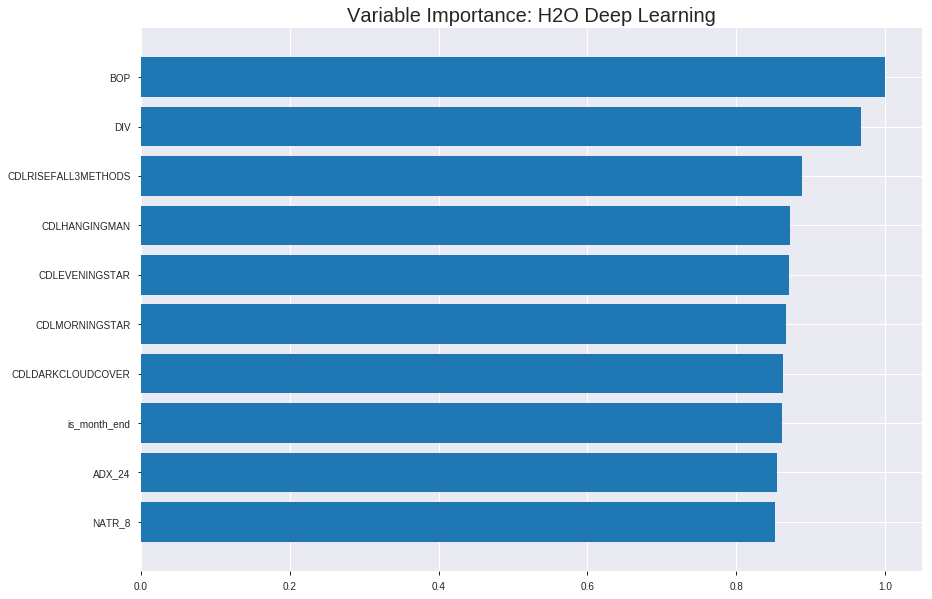

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_131345_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26481354435141696
RMSE: 0.5146003734466358
LogLoss: 1.7073410629844712
Mean Per-Class Error: 0.2803694688705436
AUC: 0.7751252934831719
pr_auc: 0.6235177863351439
Gini: 0.5502505869663439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0018822128020490546: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      423  404   0.4885   (404.0/827.0)
1      126  800   0.1361   (126.0/926.0)
Total  549  1204  0.3023   (530.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00188221   0.751174  393
max f2                       6.97642e-06  0.848452  399
max f0point5                 0.285068     0.738279  253
max accuracy                 0.0523328    0.72162   344
max precision                0.999986     0.871658  0
max recall                   6.97642e-06  1         399
max specificity              0.999986     0.970979  0
max absolute_mcc             0.0523328    0.440564  344
max min_per_class_accuracy   0.110408     0.71584   312
max mean_per_class_accuracy  0.0523328    0.719631  344

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 41.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   1                  1.89309   1.89309            1                1            1                           1                   0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   1                  1.68275   1.78792            0.888889         1            0.944444                    1                   0.0172786       0.0367171                  68.2745   78.7917
    3        0.0302339                   1                  1.44766   1.67878            0.764706         1            0.886792                    1                   0.0140389       0.0507559                  44.7656   67.8777
    4        0.040502                    1                  1.36723   1.59979            0.722222         1            0.84507                     1                   0.0140389       0.0647948                  36.7231   59.9793
    5        0.0501997                   0.999998           1.89309   1.65645            1                0.999999     0.875                       1                   0.0183585       0.0831533                  89.3089   65.6452
    6        0.100399                    0.999931           1.63494   1.6457             0.863636         0.999981     0.869318                    0.99999             0.0820734       0.165227                   63.494    64.5696
    7        0.150029                    0.99925            1.58845   1.62676            0.83908          0.999678     0.859316                    0.999887            0.0788337       0.24406                    58.8454   62.6761
    8        0.200228                    0.995527           1.5704    1.61263            0.829545         0.997622     0.851852                    0.999319            0.0788337       0.322894                   57.0403   61.2631
    9        0.300057                    0.914594           1.30894   1.51159            0.691429         0.970057     0.798479                    0.989584            0.13067         0.453564                   30.8936   51.1592
    10       0.399886                    0.565132           1.30894   1.461              0.691429         0.766732     0.771755                    0.93395             0.13067         0.584233                   30.8936   46.1
    11       0.500285                    0.139533           1.18318   1.40525            0.625            0.327532     0.742303                    0.812252            0.11879         0.703024                   18.318    40.5246
    12       0.600114                    0.0149756          0.951953  1.32984            0.502857         0.0575669    0.702471                    0.68671             0.0950324       0.798056                   -4.80469  32.9841
    13       0.699943                    0.000957985        0.7356    1.24509            0.388571         0.00563837   0.657702                    0.589573            0.0734341       0.87149                    -26.44    24.5088
    14       0.799772                    3.91573e-05        0.573335  1.16124            0.302857         0.000344264  0.613409                    0.516024            0.0572354       0.928726                   -42.6665  16.1238
    15       0.899601                    1.53837e-07        0.573335  1.096              0.302857         8.18966e-06  0.578947                    0.458762            0.0572354       0.985961                   -42.6665  9.59986
    16       1                           1.19279e-17        0.13983   1                  0.0738636        1.67113



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.41250907607055076
RMSE: 0.6422686946057318
LogLoss: 8.249457609035458
Mean Per-Class Error: 0.4326852413969391
AUC: 0.539348819375659
pr_auc: 0.31893961307024055
Gini: 0.07869763875131808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.00740133984748e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   224  0.9412   (224.0/238.0)
1      0    263  0        (0.0/263.0)
Total  14   487  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.0074e-06   0.701333  270
max f2                       8.0074e-06   0.854451  270
max f0point5                 0.00425452   0.609882  203
max accuracy                 0.00871729   0.582834  191
max precision                0.0872877    0.569482  150
max recall                   8.0074e-06   1         270
max specificity              1            0.554622  0
max absolute_mcc             0.00425452   0.179366  203
max min_per_class_accuracy   0.938725     0.516807  34
max mean_per_class_accuracy  0.00871729   0.567315  191

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 61.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.429142                    1                  0.965762  0.965762           0.506977         1           0.506977                    1                   0.414449        0.414449                   -3.42382  -3.42382
    2        0.500998                    0.938725           1.42871   1.03216            0.75             0.98221     0.541833                    0.997448            0.102662        0.51711                    42.8707   3.21603
    3        0.600798                    0.511535           1.21916   1.06322            0.64             0.76907     0.55814                     0.959512            0.121673        0.638783                   21.9163   6.3224
    4        0.700599                    0.170044           1.10487   1.06916            0.58             0.318342    0.561254                    0.868177            0.110266        0.749049                   10.4867   6.9156
    5        0.800399                    0.0149162          1.10487   1.07361            0.58             0.0644338   0.563591                    0.76796             0.110266        0.859316                   10.4867   7.36088
    6        0.9002                      0.00053314         0.838175  1.04751            0.44             0.00423679  0.549889                    0.68329             0.0836502       0.942966                   -16.1825  4.75074
    7        1                           1.41961e-12        0.571483  1                  0.3              0.00016308  0.52495                     0.615113            0.0570342       1                          -42.8517  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:13:52  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:13:55  5.365 sec         198 obs/sec       0.41757   1             732        0.631895         3.9937              -0.602277      0.657349        0.307148           1.78792          0.381061                         0.674832           9.63576               -0.826142        0.519027          0.290326             0.97011            0.449102
    2019-08-27 13:14:10  19.620 sec        222 obs/sec       2.12322   5             3722       0.545943         2.32289             -0.196031      0.746284        0.404207           1.57757          0.321734                         0.67489            9.20059               -0.826455        0.537536          0.305363             0.978686           0.463074
    2019-08-27 13:14:24  33.390 sec        227 obs/sec       3.82944   9             6713       0.549038         2.32284             -0.209628      0.738186        0.453804           1.57757          0.34227                          0.674306           9.20727               -0.823295        0.542017          0.303982             0.966143           0.44511
    2019-08-27 13:14:35  44.196 sec        230 obs/sec       5.14204   12            9014       0.579538         3.65897             -0.347757      0.663399        0.319956           1.72099          0.378209                         0.666728           8.69263               -0.782541        0.533358          0.319247             0.966014           0.439122
    2019-08-27 13:14:48  57.791 sec        233 obs/sec       6.8397    16            11990      0.5146           1.70734             -0.0626434     0.775125        0.623518           1.89309          0.302339                         0.642269           8.24946               -0.654155        0.539349          0.31894              0.965762           0.447106
    2019-08-27 13:15:01  1 min 10.947 sec  235 obs/sec       8.53109   20            14955      0.482675         1.417               0.0651181      0.804681        0.480516           1.89309          0.2664                           0.645389           8.28618               -0.670267        0.534812          0.318189             0.970275           0.437126
    2019-08-27 13:15:15  1 min 24.428 sec  236 obs/sec       10.2316   24            17936      0.490682         1.4117              0.033845       0.798166        0.596607           1.89309          0.284084                         0.651898           8.33144               -0.704125        0.52537           0.323086             0.957163           0.451098
    2019-08-27 13:15:28  1 min 37.413 sec  238 obs/sec       11.923    28            20901      0.573859         2.98898             -0.321472      0.709422        0.482713           1.78792          0.370222                         0.712429           11.1929               -1.03529         0.523325          0.322347             0.966014           0.451098
    2019-08-27 13:15:41 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0012347847634130989
DIV                       0.9682580232620239     0.9682580232620239   0.0011955902541764328
CDLRISEFALL3METHODS       0.8877479434013367     0.8877479434013367   0.0010961776342632845
CDLHANGINGMAN             0.8717717528343201     0.8717717528343201   0.0010764504775737484
CDLEVENINGSTAR            0.8702370524406433     0.8702370524406433   0.0010745554529112322
---                       ---                    ---                  ---
BBANDS_lowerband_20_7_2   0.7194061875343323     0.7194061875343323   0.0008883117990724998
DX_20                     0.715279757976532      0.715279757976532    0.0008832165467272306
BBANDS_upperband_12_7_5   0.7130753993988037     0.7130753993988037   0.0008804946383423527
BBANDS_middleband_24_2_4  0.7085015773773193     0.7085015773773193   0.0008748469525996605
BBANDS_lowerband_20_1_3   0.695770800113678      0.695770800113678    0.0008591271828081102


See the whole table with table.as_data_frame()


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5)

('logloss', 16.23735304621298)

('mean_per_class_error', 0.5)

('rmse', 0.6856526248125582)

('mse', 0.4701195219123506)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


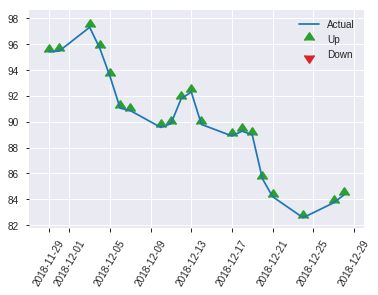


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4701195219123506
RMSE: 0.6856526248125582
LogLoss: 16.23735304621298
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.692708  0
max f2                       1            0.849298  0
max f0point5                 1            0.584872  0
max accuracy                 1            0.52988   0
max precision                1            0.52988   0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.52988          1        0.52988                     1                   1               1                          0       0

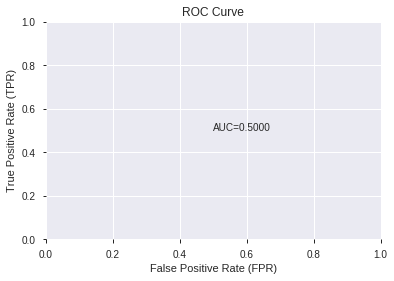

This function is available for GLM models only


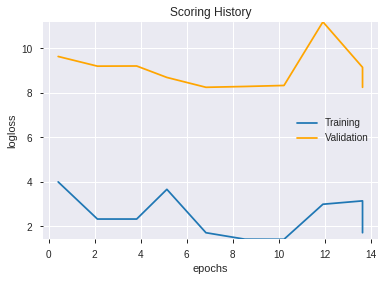

--2019-08-27 13:41:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.2MB/s    in 23s     

2019-08-27 13:41:47 (15.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_131345_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_131345_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_134159_model_8  0.507519  18.301423                   0.5  0.727929  0.529880
1               DeepLearning_1_AutoML_20190827_134159  0.500000  18.301423                   0.5  0.727929  0.529880
2  DeepLearning_grid_1_AutoML_20190827_134159_model_7  0.500000  16.237353                   0.5  0.685653  0.470120
3  DeepLearning_grid_1_AutoML_20190827_134159_model_4  0.500000  16.237353                   0.5  0.685653  0.470120
4  DeepLearning_grid_1_AutoML_20190827_134159_model_3  0.500000  16.237353                   0.5  0.685653  0.470120
5  DeepLearning_grid_1_AutoML_20190827_134159_model_1  0.500000  18.301423                   0.5  0.727929  0.529880
6  DeepLearning_grid_1_AutoML_20190827_134159_model_5  0.500000   0.694748                   0.5  0.500799  0.250800
7  DeepLearning_grid_1_AutoML_20190827_134159_model_9  0.500000  16.237353                   0.5  0.685653  0.470120
8  DeepLearning_grid_1_AutoML_20190827_134159_model_2  0.500000  16.237353                   0.5  0.685653  0.470120
9  DeepLearning_grid_1_AutoML_20190827_134159_model_6  0.500000   0.691579                   0.5  0.499215  0.249216

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.045953
1         CDLCLOSINGMARUBOZU             0.739538           0.739538    0.033984
2                        DIV             0.710599           0.710599    0.032654
3       HT_PHASOR_quadrature             0.642273           0.642273    0.029514
4               aroondown_12             0.598566           0.598566    0.027506
5                AROONOSC_24             0.570705           0.570705    0.026225
6                   WILLR_12             0.554722           0.554722    0.025491
7               HT_TRENDMODE             0.541490           0.541490    0.024883
8                      CCI_8             0.537091           0.537091    0.024681
9              days_in_month             0.528076           0.528076    0.024267
10              aroondown_30             0.524755           0.524755    0.024114
11                    ADX_24             0.524575           0.524575    0.024106
12               CDLLONGLINE             0.511451           0.511451    0.023503
13        CDLMORNINGDOJISTAR             0.504692           0.504692    0.023192
14                aroonup_30             0.487292           0.487292    0.022392
15                 CORREL_24             0.478678           0.478678    0.021997
16                   ROCP_14             0.475992           0.475992    0.021873
17         CDL3WHITESOLDIERS             0.466404           0.466404    0.021433
18                    MFI_30             0.452690           0.452690    0.020802
19                    NATR_8             0.442425           0.442425    0.020331
20             CDLHANGINGMAN             0.434650           0.434650    0.019973
21               CDLDOJISTAR             0.430453           0.430453    0.019780
22                PLUS_DI_12             0.427759           0.427759    0.019657
23                      ATAN             0.424559           0.424559    0.019510
24                 STDDEV_14             0.424114           0.424114    0.019489
25            CDLEVENINGSTAR             0.414187           0.414187    0.019033
26                    VAR_12             0.413919           0.413919    0.019021
27                MACDFIX_14             0.410617           0.410617    0.018869
28                 CDLINNECK             0.381099           0.381099    0.017513
29         CDLDARKCLOUDCOVER             0.378623           0.378623    0.017399
30       CDLRISEFALL3METHODS             0.362509           0.362509    0.016658
31                    RSI_14             0.359751           0.359751    0.016532
32            is_quarter_end             0.350989           0.350989    0.016129
33           CDLLADDERBOTTOM             0.347113           0.347113    0.015951
34              is_month_end             0.338852           0.338852    0.015571
35                       EXP             0.335437           0.335437    0.015414
36                      TANH             0.332159           0.332159    0.015264
37          CDLDRAGONFLYDOJI             0.327237           0.327237    0.015037
38  BBANDS_middleband_24_7_5             0.325570           0.325570    0.014961
39   BBANDS_upperband_20_1_3             0.320155           0.320155    0.014712
40            CDL3LINESTRIKE             0.310540           0.310540    0.014270
41            CDLMORNINGSTAR             0.308625           0.308625    0.014182
42              LINEARREG_30             0.307000           0.307000    0.014107
43   BBANDS_lowerband_12_5_2             0.303630           0.303630    0.013953
44  BBANDS_middleband_20_5_4             0.296765           0.296765    0.013637
45   BBANDS_middleband_8_4_3             0.292241           0.292241    0.013429
46           CDLADVANCEBLOCK             0.285122           0.285122    0.013102
47                    EMA_24             0.283672           0.283672    0.013036
48        CDLUPSIDEGAP2CROWS             0.281198  

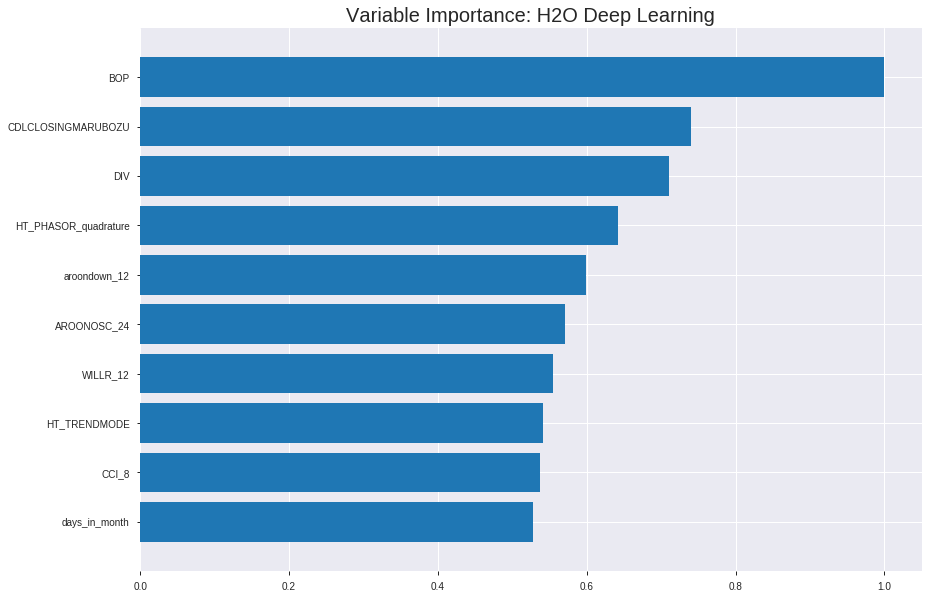

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_134159_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16895565244323532
RMSE: 0.41104215409521605
LogLoss: 0.5007317113161124
Mean Per-Class Error: 0.25693456010822646
AUC: 0.8327550724599831
pr_auc: 0.8466715474717439
Gini: 0.6655101449199663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5157694762309719: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      467  360   0.4353   (360.0/827.0)
1      99   827   0.1069   (99.0/926.0)
Total  566  1187  0.2618   (459.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515769     0.782773  228
max f2                       0.25262      0.877515  314
max f0point5                 0.665691     0.765147  138
max accuracy                 0.559339     0.74672   201
max precision                0.999312     1         0
max recall                   0.0822691    1         371
max specificity              0.999312     1         0
max absolute_mcc             0.559339     0.49144   201
max min_per_class_accuracy   0.574066     0.730022  188
max mean_per_class_accuracy  0.559339     0.743065  201

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 55.40 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.98719            1.89309    1.89309            1                0.993752   1                           0.993752            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.976616           1.89309    1.89309            1                0.982108   1                           0.98793             0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.964348           1.89309    1.89309            1                0.970187   1                           0.982239            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.952307           1.89309    1.89309            1                0.957897   1                           0.976068            0.0194384       0.0766739                  89.3089   89.3089
    5        0.0501997                   0.94067            1.89309    1.89309            1                0.944975   1                           0.970061            0.0183585       0.0950324                  89.3089   89.3089
    6        0.100399                    0.862891           1.85006    1.87158            0.977273         0.899995   0.988636                    0.935028            0.0928726       0.187905                   85.0064   87.1576
    7        0.150029                    0.802312           1.76253    1.8355             0.931034         0.830428   0.969582                    0.900427            0.087473        0.275378                   76.2531   83.5504
    8        0.200228                    0.765903           1.63494    1.78522            0.863636         0.784794   0.94302                     0.871436            0.0820734       0.357451                   63.494    78.522
    9        0.300057                    0.68072            1.40629    1.65915            0.742857         0.724233   0.876426                    0.822462            0.140389        0.49784                    40.6294   65.9152
    10       0.399886                    0.61573            1.09258    1.51771            0.577143         0.646276   0.801712                    0.778478            0.109071        0.606911                   9.25825   51.7712
    11       0.500285                    0.577636           1.10789    1.43547            0.585227         0.594333   0.758267                    0.741523            0.111231        0.718143                   10.7887   43.5466
    12       0.600114                    0.554244           1.07095    1.37483            0.565714         0.564371   0.726236                    0.712054            0.106911        0.825054                   7.09472   37.4829
    13       0.699943                    0.493445           0.800506   1.29292            0.422857         0.529927   0.682967                    0.686078            0.0799136       0.904968                   -19.9494  29.2916
    14       0.799772                    0.32894            0.594971   1.2058             0.314286         0.429189   0.636947                    0.654013            0.0593952       0.964363                   -40.5029  20.5797
    15       0.899601                    0.153226           0.324529   1.108              0.171429         0.231196   0.585289                    0.607093            0.0323974       0.99676                    -67.5471  10.8003
    16       1                           0.000234583        0.0322686  1                  0.0170455        0.0785918  0.528237  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27544789880338855
RMSE: 0.5248313050908725
LogLoss: 2.6369164943561643
Mean Per-Class Error: 0.42123845736013044
AUC: 0.5846247244144807
pr_auc: 0.5963668980959533
Gini: 0.1692494488289613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.7086781726191166e-63: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    263  0        (0.0/263.0)
Total  0    501  0.475    (238.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.70868e-63  0.688482  327
max f2                       2.70868e-63  0.846748  327
max f0point5                 0.486215     0.606226  267
max accuracy                 0.492248     0.578842  265
max precision                0.998333     1         0
max recall                   2.70868e-63  1         327
max specificity              0.998333     1         0
max absolute_mcc             0.634364     0.188216  112
max min_per_class_accuracy   0.551375     0.467681  211
max mean_per_class_accuracy  0.634364     0.578762  112

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.91802            0.952471  0.952471           0.5              0.951162     0.5                         0.951162            0.0114068       0.0114068                  -4.75285   -4.75285
    2        0.0219561                   0.886427           1.52395   1.21224            0.8              0.898058     0.636364                    0.927024            0.0152091       0.026616                   52.3954    21.2236
    3        0.0319361                   0.877968           1.14297   1.19059            0.6              0.881935     0.625                       0.912934            0.0114068       0.0380228                  14.2966    19.0589
    4        0.0419162                   0.869925           1.52395   1.26996            0.8              0.872544     0.666667                    0.903317            0.0152091       0.0532319                  52.3954    26.9962
    5        0.0518962                   0.85802            0.761977  1.17227            0.4              0.863003     0.615385                    0.895564            0.00760456      0.0608365                  -23.8023   17.2273
    6        0.101796                    0.790456           1.44776   1.30731            0.76             0.818055     0.686275                    0.85757             0.0722433       0.13308                    44.7757    30.7314
    7        0.151697                    0.723613           1.29536   1.30338            0.68             0.752796     0.684211                    0.823105            0.0646388       0.197719                   29.5361    30.3382
    8        0.201597                    0.660962           1.37156   1.32026            0.72             0.686083     0.693069                    0.789188            0.0684411       0.26616                    37.1559    32.0258
    9        0.301397                    0.586181           0.99057   1.21109            0.52             0.615266     0.635762                    0.731598            0.0988593       0.365019                   -0.942966  21.109
    10       0.401198                    0.557394           0.800076  1.10885            0.42             0.570362     0.58209                     0.69149             0.0798479       0.444867                   -19.9924   10.8847
    11       0.678643                    0.550893           1.05526   1.08694            0.553957         0.551243     0.570588                    0.634154            0.292776        0.737643                   5.52562    8.6938
    12       0.700599                    0.547305           1.03906   1.08544            0.545455         0.549561     0.569801                    0.631502            0.0228137       0.760456                   3.90598    8.54376
    13       0.800399                    0.448364           0.952471  1.06886            0.5              0.513296     0.561097                    0.616763            0.095057        0.855513                   -4.75285   6.88583
    14       0.9002                      9.38524e-34        0.533384  1.00949            0.28             0.192395     0.529933                    0.569716            0.0532319       0.908745                   -46.6616   0.949306
    15       1                           0                  0.914373  1                  0.48             2.70868e-63  0.52495                     0.512858            0.0912548       1                          -8.56274   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:49:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:49:07  1 min 12.703 sec  613 obs/sec       0.538505  1             944        0.487223         0.690244            0.0474163      0.701764        0.709834           1.78792          0.376497                         0.586092           5.57307               -0.377444        0.537847          0.402668             0.922234           0.433134
    2019-08-27 13:49:18  1 min 22.952 sec  975 obs/sec       5.99601   11            10511      0.45251          0.594885            0.178317       0.771065        0.771002           1.89309          0.298916                         0.581735           5.71759               -0.357042        0.545332          0.396365             0.959633           0.419162
    2019-08-27 13:49:28  1 min 33.257 sec  1095 obs/sec      12.5408   23            21984      0.437221         0.562487            0.232905       0.777821        0.776617           1.78792          0.293212                         0.579957           6.28387               -0.34876         0.549661          0.378227             0.9396             0.42515
    2019-08-27 13:49:39  1 min 44.024 sec  1177 obs/sec      20.0394   37            35129      0.444467         0.578091            0.207269       0.792741        0.793953           1.78792          0.289218                         0.57098            5.0682                -0.307327        0.547848          0.42319              0.854554           0.42515
    2019-08-27 13:49:49  1 min 54.447 sec  1236 obs/sec      27.6532   51            48476      0.427409         0.540758            0.26695        0.795999        0.797764           1.89309          0.286937                         0.576351           5.61795               -0.332037        0.546394          0.403286             0.930321           0.431138
    2019-08-27 13:50:00  2 min  5.375 sec  1293 obs/sec      36.2481   67            63543      0.426103         0.536254            0.27142        0.809841        0.816821           1.89309          0.281803                         0.529361           3.03335               -0.123689        0.599203          0.641554             1.58745            0.47505
    2019-08-27 13:50:10  2 min 15.483 sec  1333 obs/sec      44.2795   82            77622      0.419186         0.520309            0.294884       0.818403        0.832269           1.89309          0.284655                         0.559345           4.05704               -0.254591        0.591047          0.617167             1.26996            0.47505
    2019-08-27 13:50:21  2 min 26.183 sec  1366 obs/sec      52.9481   98            92818      0.411042         0.500732            0.322015       0.832755        0.846672           1.89309          0.261837                         0.524831           2.63692               -0.104542        0.584625          0.596367             0.952471           0.47505
    2019-08-27 13:50:31  2 m

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04595267576257911
CDLCLOSINGMARUBOZU       0.739538311958313      0.739538311958313    0.03398376426342544
DIV                      0.7105989456176758     0.7105989456176758   0.03265392294519964
HT_PHASOR_quadrature     0.6422728300094604     0.6422728300094604   0.029514155108538824
aroondown_12             0.598565936088562      0.598565936088562    0.02750570638360234
---                      ---                    ---                  ---
BBANDS_middleband_8_4_3  0.29224127531051636    0.29224127531051636  0.013429268568786774
CDLADVANCEBLOCK          0.2851216197013855     0.2851216197013855   0.013102101343039156
EMA_24                   0.2836723327636719     0.2836723327636719   0.013035502730303461
CDLUPSIDEGAP2CROWS       0.28119826316833496    0.28119826316833496  0.012921812612374888
CDLGAPSIDESIDEWHITE      0.26095470786094666    0.26095470786094666  0.011991567079052636


See the whole table with table.as_data_frame()


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5075187969924811)

('logloss', 18.30142334869768)

('mean_per_class_error', 0.49248120300751874)

('rmse', 0.7279288963131285)

('mse', 0.5298804780876494)

deeplearning prediction progress: |███████████████████████████████████████| 100%


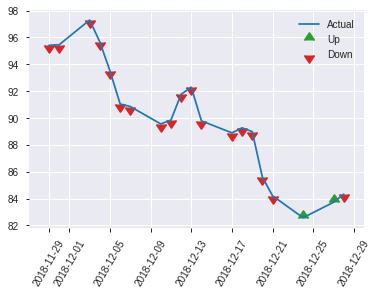


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5298804780876494
RMSE: 0.7279288963131285
LogLoss: 18.30142334869768
Mean Per-Class Error: 0.49248120300751874
AUC: 0.5075187969924811
pr_auc: 0.7609561752988048
Gini: 0.015037593984962294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6872216684565365e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.68722e-51  0.692708   2
max f2                       1.68722e-51  0.849298   2
max f0point5                 1.68722e-51  0.584872   2
max accuracy                 1.68722e-51  0.52988    2
max precision                1.61887e-20  1          0
max recall                   1.68722e-51  1          2
max specificity              1.61887e-20  1          0
max absolute_mcc             1.80391e-32  0.0844171  1
max min_per_class_accuracy   1.80391e-32  0.0150376  1
max mean_per_class_accuracy  1.80391e-32  0.507519   1

Gains/Lift Table: Avg response rate: 52.99 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   2.10059e-49        1.88722   1.88722            1                5.39625e-21   1                           5.39625e-21         0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   1.45455e-109       0.629073  1.25815            0.333333         1.23621e-87   0.666667                    2.69812e-21         0.0075188       0.0300752                  -37.0927  25.8145
    3        0.0318725                   2.31115e-168       0         0.943609           0                2.58543e-135  0.5                         2.02359e-21         0               0.0300752                  -100      -5.6391
    4        1                           0                  1.00186   1                  0.530864         2.44137e-255  0.52988                     6.4497e-23          0.969925        1                          0.185649  0

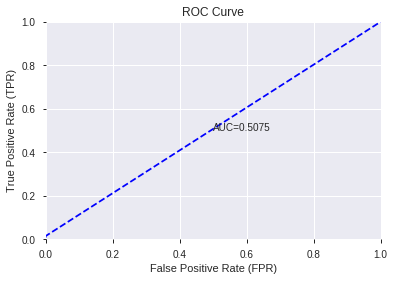

This function is available for GLM models only


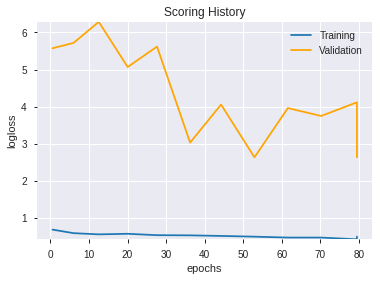

--2019-08-27 13:53:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_134159_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_134159_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'HT_PHASOR_quadrature',
 'aroondown_12',
 'AROONOSC_24',
 'WILLR_12',
 'HT_TRENDMODE',
 'CCI_8',
 'days_in_month',
 'aroondown_30',
 'ADX_24',
 'CDLLONGLINE',
 'CDLMORNINGDOJISTAR',
 'aroonup_30',
 'CORREL_24',
 'ROCP_14',
 'CDL3WHITESOLDIERS',
 'MFI_30',
 'NATR_8',
 'CDLHANGINGMAN',
 'CDLDOJISTAR',
 'PLUS_DI_12',
 'ATAN',
 'STDDEV_14',
 'CDLEVENINGSTAR',
 'VAR_12',
 'MACDFIX_14',
 'CDLINNECK',
 'CDLDARKCLOUDCOVER',
 'CDLRISEFALL3METHODS',
 'RSI_14',
 'is_quarter_end',
 'CDLLADDERBOTTOM',
 'is_month_end',
 'EXP',
 'TANH',
 'CDLDRAGONFLYDOJI',
 'BBANDS_middleband_24_7_5',
 'BBANDS_upperband_20_1_3',
 'CDL3LINESTRIKE',
 'CDLMORNINGSTAR',
 'LINEARREG_30',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_middleband_20_5_4',
 'BBANDS_middleband_8_4_3',
 'CDLADVANCEBLOCK',
 'EMA_24',
 'CDLUPSIDEGAP2CROWS',
 'CDLGAPSIDESIDEWHITE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_135354_model_1  0.5  18.301423                   0.5  0.727929  0.52988

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.118277           1.000000    0.147279
1         CDLCLOSINGMARUBOZU             0.077507           0.655304    0.096512
2                CDLLONGLINE             0.076818           0.649477    0.095654
3                   WILLR_12             0.049090           0.415042    0.061127
4                        DIV             0.045387           0.383738    0.056516
5          CDLDARKCLOUDCOVER             0.032929           0.278404    0.041003
6              CDLHANGINGMAN             0.029043           0.245553    0.036165
7                      CCI_8             0.023216           0.196287    0.028909
8             CDLEVENINGSTAR             0.021927           0.185385    0.027303
9           CDLDRAGONFLYDOJI             0.019879           0.168072    0.024753
10                    RSI_14             0.019478           0.164677    0.024253
11                    NATR_8             0.015943           0.134795    0.019852
12                 CORREL_24             0.015203           0.128538    0.018931
13                aroonup_30             0.014968           0.126547    0.018638
14                   ROCP_14             0.014236           0.120362    0.017727
15            CDLMORNINGSTAR             0.012874           0.108844    0.016030
16               AROONOSC_24             0.012725           0.107584    0.015845
17              aroondown_12             0.012362           0.104518    0.015393
18        CDLMORNINGDOJISTAR             0.012302           0.104014    0.015319
19                MACDFIX_14             0.011491           0.097156    0.014309
20                 STDDEV_14             0.011034           0.093287    0.013739
21                 CDLINNECK             0.010855           0.091777    0.013517
22       CDLRISEFALL3METHODS             0.010539           0.089101    0.013123
23         CDL3WHITESOLDIERS             0.009752           0.082447    0.012143
24                    VAR_12             0.009223           0.077980    0.011485
25            is_quarter_end             0.008180           0.069163    0.010186
26      HT_PHASOR_quadrature             0.008054           0.068093    0.010029
27       CDLGAPSIDESIDEWHITE             0.007695           0.065056    0.009581
28           CDLADVANCEBLOCK             0.006510           0.055040    0.008106
29            CDL3LINESTRIKE             0.006396           0.054079    0.007965
30                    ADX_24             0.006326           0.053483    0.007877
31                PLUS_DI_12             0.006326           0.053481    0.007877
32           CDLLADDERBOTTOM             0.005909           0.049958    0.007358
33        CDLUPSIDEGAP2CROWS             0.005649           0.047757    0.007034
34              LINEARREG_30             0.005325           0.045023    0.006631
35   BBANDS_upperband_20_1_3             0.005091           0.043045    0.006340
36  BBANDS_middleband_24_7_5             0.004873           0.041203    0.006068
37  BBANDS_middleband_20_5_4             0.004757           0.040217    0.005923
38   BBANDS_lowerband_12_5_2             0.004535           0.038338    0.005646
39   BBANDS_middleband_8_4_3             0.004500           0.038048    0.005604
40                    EMA_24             0.004359           0.036853    0.005428
41              aroondown_30             0.004325           0.036569    0.005386
42              is_month_end             0.004195           0.035469    0.005224
43                      TANH             0.004001           0.033828    0.004982
44                      ATAN             0.002709           0.022900    0.003373
45                    MFI_30             0.002514           0.021257    0.003131
46             days_in_month             0.002016           0.017047    0.002511
47               CDLDOJISTAR             0.000987           0.008343    0.001229
48              HT_TRENDMODE             0.000782  

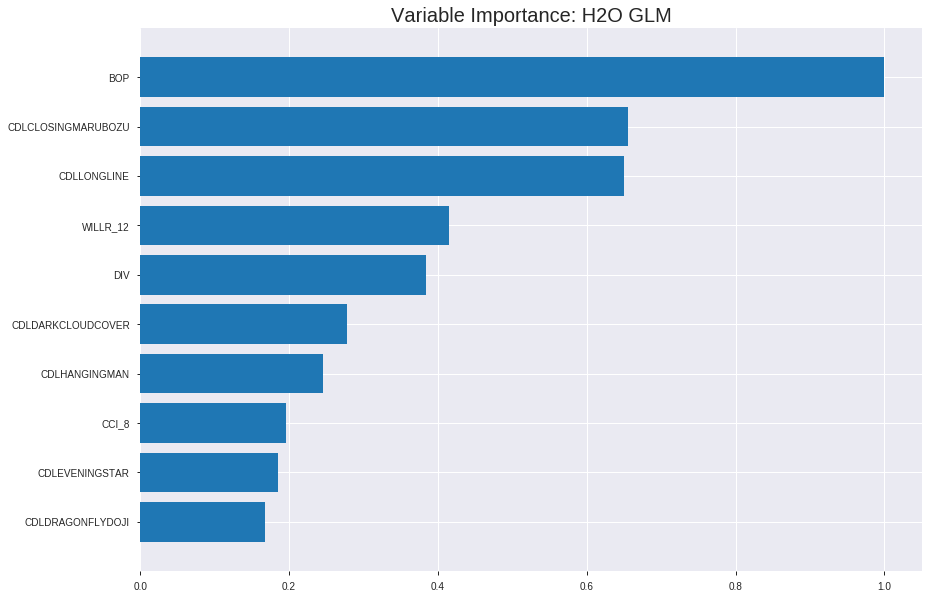

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135354_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22260817312996195
RMSE: 0.4718137059581482
LogLoss: 0.6372420713608787
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2424.5800523999424
Residual deviance: 2234.1707021912407
AIC: 2336.1707021912407
AUC: 0.7466446940592999
pr_auc: 0.746812846138361
Gini: 0.4932893881185998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4673570228466326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      268  559   0.6759   (559.0/827.0)
1      54   872   0.0583   (54.0/926.0)
Total  322  1431  0.3497   (613.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467357     0.739924  287
max f2                       0.435397     0.859806  320
max f0point5                 0.527954     0.702886  199
max accuracy                 0.524857     0.685682  203
max precision                0.764003     1         0
max recall                   0.373642     1         371
max specificity              0.764003     1         0
max absolute_mcc             0.508297     0.369083  228
max min_per_class_accuracy   0.529028     0.678356  197
max mean_per_class_accuracy  0.527954     0.684556  199

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.691757           1.78792   1.78792            0.944444         0.710046  0.944444                    0.710046            0.0183585       0.0183585                  78.7917   78.7917
    2        0.0205362                   0.681115           1.57757   1.68275            0.833333         0.685171  0.888889                    0.697609            0.0161987       0.0345572                  57.7574   68.2745
    3        0.0302339                   0.673998           1.55901   1.64306            0.823529         0.677706  0.867925                    0.691225            0.0151188       0.049676                   55.9014   64.3058
    4        0.040502                    0.666125           1.89309   1.70645            1                0.670576  0.901408                    0.68599             0.0194384       0.0691145                  89.3089   70.6446
    5        0.0501997                   0.658955           1.55901   1.67796            0.823529         0.661602  0.886364                    0.681279            0.0151188       0.0842333                  55.9014   67.7965
    6        0.100399                    0.628724           1.52738   1.60267            0.806818         0.64284   0.846591                    0.662059            0.0766739       0.160907                   52.7378   60.2672
    7        0.150029                    0.601883           1.54493   1.58357            0.816092         0.614736  0.836502                    0.646405            0.0766739       0.237581                   54.4934   58.3572
    8        0.200228                    0.584473           1.29074   1.51016            0.681818         0.592825  0.797721                    0.632972            0.0647948       0.302376                   29.0742   51.0156
    9        0.300057                    0.563521           1.30894   1.44321            0.691429         0.572686  0.762357                    0.612915            0.13067         0.433045                   30.8936   44.321
    10       0.399886                    0.545558           1.27648   1.40159            0.674286         0.554742  0.740371                    0.598392            0.12743         0.560475                   27.6483   40.1588
    11       0.500285                    0.530473           1.08637   1.33833            0.573864         0.53772   0.706956                    0.586216            0.109071        0.669546                   8.63747   33.8329
    12       0.600114                    0.513747           0.984406  1.27945            0.52             0.522356  0.675856                    0.575593            0.0982721       0.767819                   -1.5594   27.9454
    13       0.699943                    0.497928           0.843777  1.21732            0.445714         0.5059    0.643032                    0.565653            0.0842333       0.852052                   -15.6223  21.7316
    14       0.799772                    0.471479           0.757235  1.15989            0.4              0.485827  0.612696                    0.555689            0.075594        0.927646                   -24.2765  15.9888
    15       0.899601                    0.425984           0.508429  1.0876             0.268571         0.451735  0.574509                    0.544153            0.0507559       0.978402                   -49.1571  8.75956
    16       1                           0.302483           0.215124  1                  0.113636         0.385626  0.528237                    0.528237          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2637475300644026
RMSE: 0.5135635599070505
LogLoss: 2.788063526979048
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.3071704359105
Residual deviance: 36036.36766260128
AIC: 36138.36766260128
AUC: 0.6715659647889574
pr_auc: 0.7008121551115244
Gini: 0.3431319295779147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45858774267216373: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   141  0.5924   (141.0/238.0)
1      46   217  0.1749   (46.0/263.0)
Total  143  358  0.3733   (187.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458588     0.698873  322
max f2                       3.78197e-07  0.846748  399
max f0point5                 0.492469     0.655391  262
max accuracy                 0.492469     0.640719  262
max precision                0.73982      1         0
max recall                   3.78197e-07  1         399
max specificity              0.73982      1         0
max absolute_mcc             0.566537     0.327294  87
max min_per_class_accuracy   0.503215     0.62605   232
max mean_per_class_accuracy  0.492469     0.637226  262

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 44.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.675841           1.58745   1.58745            0.833333         0.689642      0.833333                    0.689642            0.0190114       0.0190114                  58.7452    58.7452
    2        0.0219561                   0.655124           1.14297   1.38541            0.6              0.662377      0.727273                    0.677249            0.0114068       0.0304183                  14.2966    38.5413
    3        0.0319361                   0.640851           1.90494   1.54777            1                0.642256      0.8125                      0.666314            0.0190114       0.0494297                  90.4943    54.7766
    4        0.0419162                   0.635165           1.90494   1.63281            1                0.637599      0.857143                    0.659477            0.0190114       0.0684411                  90.4943    63.2808
    5        0.0518962                   0.630818           1.14297   1.53861            0.6              0.632816      0.807692                    0.65435             0.0114068       0.0798479                  14.2966    53.8608
    6        0.101796                    0.597439           1.75255   1.64348            0.92             0.61361       0.862745                    0.634379            0.0874525       0.1673                     75.2548    64.348
    7        0.151697                    0.575574           1.52395   1.60416            0.8              0.58576       0.842105                    0.618386            0.0760456       0.243346                   52.3954    60.4162
    8        0.201597                    0.562314           1.44776   1.56545            0.76             0.568673      0.821782                    0.606081            0.0722433       0.315589                   44.7757    56.5448
    9        0.301397                    0.541924           0.952471  1.36248            0.5              0.549641      0.715232                    0.587392            0.095057        0.410646                   -4.75285   36.2476
    10       0.401198                    0.523238           1.10487   1.29839            0.58             0.532352      0.681592                    0.573701            0.110266        0.520913                   10.4867    29.8394
    11       0.500998                    0.504758           1.02867   1.24466            0.54             0.513321      0.653386                    0.561673            0.102662        0.623574                   2.86692    24.4664
    12       0.600798                    0.489779           0.99057   1.20246            0.52             0.496616      0.631229                    0.550866            0.0988593       0.722433                   -0.942966  20.2456
    13       0.700599                    0.465438           0.876274  1.15599            0.46             0.4797        0.606838                    0.540728            0.0874525       0.809886                   -12.3726   15.5991
    14       0.800399                    0.405912           0.380989  1.05936            0.2              0.4406        0.55611                     0.528243            0.0380228       0.847909                   -61.9011   5.93573
    15       0.9002                      3.38713e-124       0.609582  1.00949            0.32             0.209885      0.529933                    0.492949            0.0608365       0.908745                   -39.0418   0.949306
    16       1                           0                  0.914373  1     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:53:54  0.000 sec   2            20        51            1.37158           95.0137
    2019-08-27 13:53:55  0.095 sec   4            13        51            1.36516           100.576
    2019-08-27 13:53:55  0.174 sec   6            7.8       51            1.35566           103.398
    2019-08-27 13:53:55  0.256 sec   8            4.8       51            1.34211           106.172
    2019-08-27 13:53:55  0.343 sec   10           3         51            1.32387           106.161
    2019-08-27 13:53:55  0.439 sec   12           1.9       51            1.30096           103.363
    2019-08-27 13:53:55  0.527 sec   14           1.2       51            1.27448           71.9289
    2019-08-27 13:53:55  0.562 sec   16           0.72      51            1.24668           93.6252
    2019-08-27 13:53:55  0.594 sec   18           0.45      51            1.22008           96.9203
    2019-08-27 13:53:55  0.626 sec   20           0.28      51            1.19673           99.5445
    2019-08-27 13:53:55  0.658 sec   22           0.17      51            1.17762           103.194
    2019-08-27 13:53:55  0.688 sec   24           0.11      51            1.16274           106.909

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5)

('logloss', 18.30142334869768)

('mean_per_class_error', 0.5)

('rmse', 0.7279288963131285)

('mse', 0.5298804780876494)

glm prediction progress: |████████████████████████████████████████████████| 100%


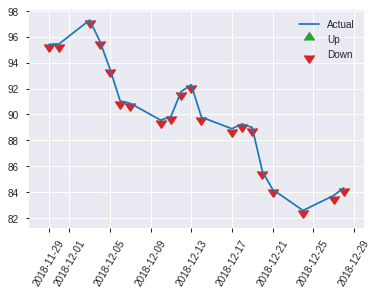


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5298804780876494
RMSE: 0.7279288963131285
LogLoss: 18.30142334869768
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.0656557889856
Residual deviance: 185905.25474774328
AIC: 186007.25474774328
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.251747485241255e-77: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.25175e-77  0.692708  0
max f2                       2.25175e-77  0.849298  0
max f0point5                 2.25175e-77  0.584872  0
max accuracy                 2.25175e-77  0.52988   0
max precision                2.25175e-77  0.52988   0
max recall                   2.25175e-77  1         0
max specificity              2.25175e-77  0         0
max absolute_mcc             2.25175e-77  0         0
max min_per_class_accuracy   2.25175e-77  0         0
max mean_per_class_accuracy  2.25175e-77  0.5       0

Gains/Lift Table: Avg response rate: 52.99 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   6.27685e-182       1.88722   1.88722            1                1.88396e-75  1                           1.88396e-75         0.0225564       0.0225564                  88.7218   88.7218
    2        1                           0                  0.989268  1                  0.524194         0            0.52988                     2.25175e-77         0.977444        1                          -1.07325  0

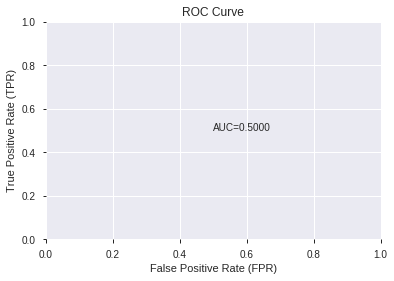

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


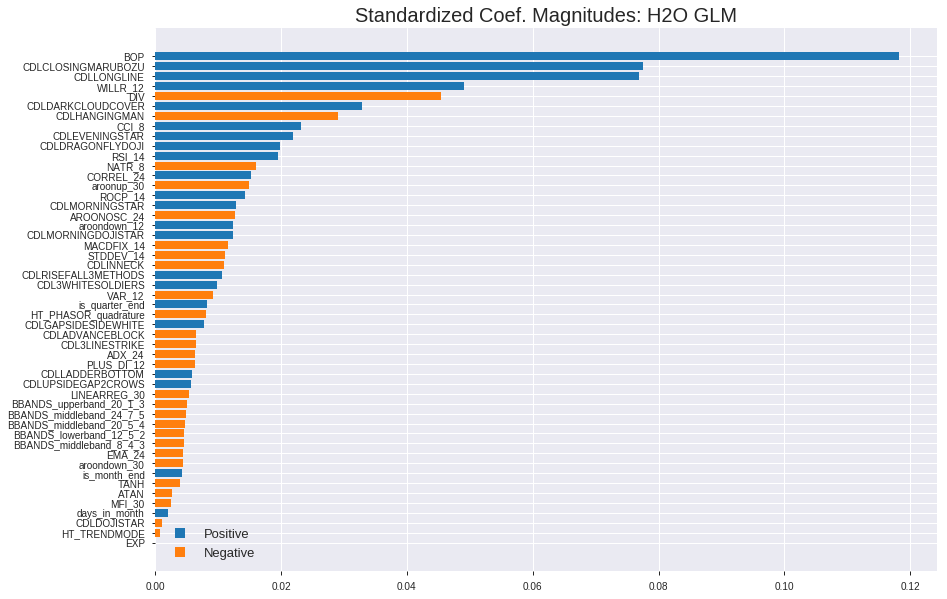

'log_likelihood'
--2019-08-27 13:54:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.130
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.130|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135354_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135354_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'WILLR_12',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CCI_8',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'RSI_14',
 'NATR_8',
 'CORREL_24',
 'aroonup_30',
 'ROCP_14',
 'CDLMORNINGSTAR',
 'AROONOSC_24',
 'aroondown_12',
 'CDLMORNINGDOJISTAR',
 'MACDFIX_14',
 'STDDEV_14',
 'CDLINNECK',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'VAR_12',
 'is_quarter_end',
 'HT_PHASOR_quadrature',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'ADX_24',
 'PLUS_DI_12',
 'CDLLADDERBOTTOM',
 'CDLUPSIDEGAP2CROWS',
 'LINEARREG_30',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_24_7_5',
 'BBANDS_middleband_20_5_4',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_middleband_8_4_3',
 'EMA_24',
 'aroondown_30',
 'is_month_end',
 'TANH',
 'ATAN',
 'MFI_30',
 'days_in_month',
 'CDLDOJISTAR',
 'HT_TRENDMODE',
 'EXP']

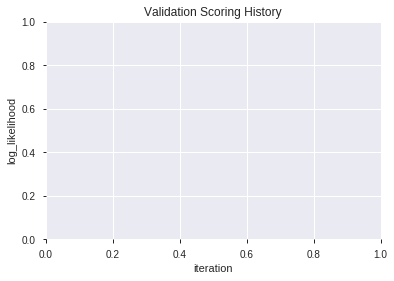

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_135411_model_4  0.729260  0.611536              0.328947  0.460090  0.211683
1               XGBoost_3_AutoML_20190827_135411  0.721167  0.637193              0.356761  0.472004  0.222788
2               XGBoost_2_AutoML_20190827_135411  0.711864  0.640201              0.357238  0.472724  0.223468
3  XGBoost_grid_1_AutoML_20190827_135411_model_5  0.707340  0.652016              0.345897  0.478390  0.228857
4  XGBoost_grid_1_AutoML_20190827_135411_model_7  0.702816  0.636807              0.404390  0.471945  0.222732
5  XGBoost_grid_1_AutoML_20190827_135411_model_3  0.701096  0.638374              0.379381  0.472437  0.223196
6  XGBoost_grid_1_AutoML_20190827_135411_model_1  0.698898  0.643457              0.378903  0.475976  0.226553
7  XGBoost_grid_1_AutoML_20190827_135411_model_2  0.696317  0.636582              0.359150  0.472516  0.223272
8  XGBoost_grid_1_AutoML_20190827_135411_model_6  0.694724  0.648668              0.357716  0.478230  0.228704
9               XGBoost_1_AutoML_20190827_135411  0.691220  0.643426              0.349656  0.474691  0.225331

variable  relative_importance  scaled_importance  percentage
0                        BOP          2255.374512           1.000000    0.470667
1                        DIV           418.386353           0.185506    0.087312
2                   WILLR_12           245.725174           0.108951    0.051280
3       HT_PHASOR_quadrature           149.721909           0.066384    0.031245
4                      CCI_8           147.600906           0.065444    0.030802
5         CDLCLOSINGMARUBOZU           136.216095           0.060396    0.028426
6               aroondown_12           127.392975           0.056484    0.026585
7                 PLUS_DI_12           123.587265           0.054797    0.025791
8                  CORREL_24           115.765602           0.051329    0.024159
9                 aroonup_30            84.468475           0.037452    0.017627
10                   ROCP_14            82.426414           0.036547    0.017201
11                MACDFIX_14            80.405594           0.035651    0.016780
12               AROONOSC_24            78.843201           0.034958    0.016454
13                    NATR_8            67.272438           0.029828    0.014039
14                    ADX_24            66.167130           0.029338    0.013808
15   BBANDS_middleband_8_4_3            60.406429           0.026783    0.012606
16                    MFI_30            59.437187           0.026354    0.012404
17              aroondown_30            58.717693           0.026035    0.012254
18              LINEARREG_30            56.189571           0.024914    0.011726
19                 STDDEV_14            52.800114           0.023411    0.011019
20                    VAR_12            52.578457           0.023313    0.010972
21  BBANDS_middleband_20_5_4            51.063774           0.022641    0.010656
22                    RSI_14            39.136528           0.017353    0.008167
23   BBANDS_upperband_20_1_3            37.436790           0.016599    0.007813
24               CDLLONGLINE            36.095856           0.016004    0.007533
25   BBANDS_lowerband_12_5_2            34.191208           0.015160    0.007135
26  BBANDS_middleband_24_7_5            31.767490           0.014085    0.006629
27             days_in_month            16.193748           0.007180    0.003379
28                      ATAN            16.117188           0.007146    0.003363
29                    EMA_24            10.384157           0.004604    0.002167

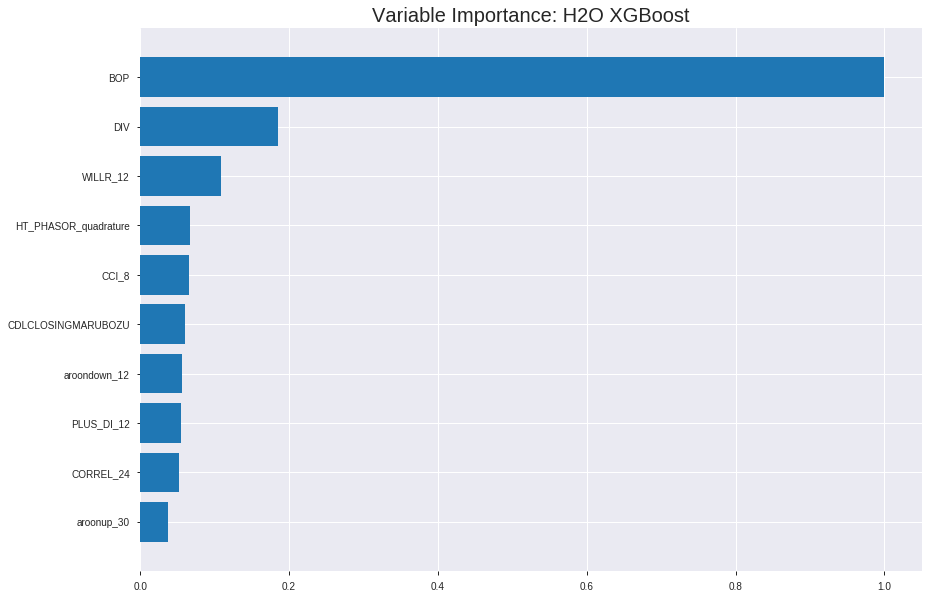

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_135411_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17930841531589994
RMSE: 0.42344824396365127
LogLoss: 0.538461265002119
Mean Per-Class Error: 0.2576534143290302
AUC: 0.8163448254248488
pr_auc: 0.8272666707024051
Gini: 0.6326896508496975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43579696615537006: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      465  362   0.4377   (362.0/827.0)
1      115  811   0.1242   (115.0/926.0)
Total  580  1173  0.2721   (477.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435797     0.772749  245
max f2                       0.189808     0.864804  361
max f0point5                 0.59757      0.765379  159
max accuracy                 0.548173     0.743297  187
max precision                0.874401     1         0
max recall                   0.160319     1         377
max specificity              0.874401     1         0
max absolute_mcc             0.548173     0.484824  187
max min_per_class_accuracy   0.562385     0.739741  179
max mean_per_class_accuracy  0.548173     0.742347  187

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.84956            1.89309   1.89309            1                0.861044  1                           0.861044            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.835583           1.89309   1.89309            1                0.842655  1                           0.851849            0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.827345           1.89309   1.89309            1                0.830391  1                           0.844966            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.819631           1.68275   1.83976            0.888889         0.823385  0.971831                    0.839495            0.0172786       0.074514                   68.2745   83.9762
    5        0.0501997                   0.810461           1.89309   1.85006            1                0.814016  0.977273                    0.834573            0.0183585       0.0928726                  89.3089   85.0064
    6        0.100399                    0.777997           1.7425    1.79628            0.920455         0.793662  0.948864                    0.814118            0.087473        0.180346                   74.2502   79.6283
    7        0.150029                    0.747792           1.56669   1.72034            0.827586         0.76266   0.908745                    0.797095            0.0777538       0.258099                   56.6694   72.0335
    8        0.200228                    0.723251           1.63494   1.69893            0.863636         0.735498  0.897436                    0.781652            0.0820734       0.340173                   63.494    69.8926
    9        0.300057                    0.680715           1.41711   1.60517            0.748571         0.70145   0.847909                    0.754969            0.141469        0.481641                   41.7112   60.5166
    10       0.399886                    0.636829           1.29812   1.52851            0.685714         0.659782  0.807418                    0.731206            0.12959         0.611231                   29.8118   52.8514
    11       0.500285                    0.570598           1.11864   1.44626            0.590909         0.604574  0.763968                    0.705793            0.112311        0.723542                   11.8643   44.6259
    12       0.600114                    0.49834            0.962771  1.36583            0.508571         0.534803  0.721483                    0.677349            0.0961123       0.819654                   -3.72293  36.5831
    13       0.699943                    0.398861           0.69233   1.26977            0.365714         0.45271   0.670742                    0.64531             0.0691145       0.888769                   -30.767   26.9773
    14       0.799772                    0.294192           0.584153  1.18419            0.308571         0.347294  0.625535                    0.608111            0.0583153       0.947084                   -41.5847  18.4193
    15       0.899601                    0.198631           0.389435  1.096              0.205714         0.247789  0.578947                    0.568126            0.0388769       0.985961                   -61.0565  9.59986
    16       1                           0.114168           0.13983   1                  0.0738636        0.159442  0.528237                    0.527094         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2100064120480594
RMSE: 0.4582645655601788
LogLoss: 0.6083445518327766
Mean Per-Class Error: 0.3030641914560501
AUC: 0.7427788605936672
pr_auc: 0.7429963762923265
Gini: 0.4855577211873343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3627324104309082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   160  0.6723   (160.0/238.0)
1      22   241  0.0837   (22.0/263.0)
Total  100  401  0.3633   (182.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362732     0.725904  315
max f2                       0.248102     0.854785  366
max f0point5                 0.614806     0.727449  145
max accuracy                 0.614806     0.690619  145
max precision                0.800906     1         0
max recall                   0.166196     1         395
max specificity              0.800906     1         0
max absolute_mcc             0.614806     0.404568  145
max min_per_class_accuracy   0.564403     0.684411  193
max mean_per_class_accuracy  0.614806     0.696936  145

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 52.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.778569           1.26996   1.26996            0.666667         0.788091  0.666667                    0.788091            0.0152091       0.0152091                  26.9962   26.9962
    2        0.0219561                   0.755024           1.52395   1.38541            0.8              0.761973  0.727273                    0.776219            0.0152091       0.0304183                  52.3954   38.5413
    3        0.0319361                   0.749667           1.90494   1.54777            1                0.751313  0.8125                      0.768436            0.0190114       0.0494297                  90.4943   54.7766
    4        0.0419162                   0.744902           1.90494   1.63281            1                0.747015  0.857143                    0.763336            0.0190114       0.0684411                  90.4943   63.2808
    5        0.0518962                   0.734594           1.90494   1.68514            1                0.739604  0.884615                    0.758772            0.0190114       0.0874525                  90.4943   68.5142
    6        0.101796                    0.713603           1.60015   1.64348            0.84             0.722955  0.862745                    0.741215            0.0798479       0.1673                     60.0152   64.348
    7        0.151697                    0.687418           1.29536   1.52897            0.68             0.700273  0.802632                    0.727747            0.0646388       0.231939                   29.5361   52.8967
    8        0.201597                    0.669792           1.60015   1.54659            0.84             0.679044  0.811881                    0.715692            0.0798479       0.311787                   60.0152   54.6587
    9        0.301397                    0.637975           1.48586   1.52648            0.78             0.655012  0.801325                    0.695599            0.148289        0.460076                   48.5856   52.6477
    10       0.401198                    0.608471           1.25726   1.45951            0.66             0.623323  0.766169                    0.67762             0.125475        0.585551                   25.7262   45.9509
    11       0.500998                    0.567707           0.876274  1.34333            0.46             0.590334  0.705179                    0.660232            0.0874525       0.673004                   -12.3726  34.3326
    12       0.600798                    0.524108           0.800076  1.25309            0.42             0.546572  0.657807                    0.641352            0.0798479       0.752852                   -19.9924  25.3085
    13       0.700599                    0.463668           0.838175  1.19398            0.44             0.495928  0.626781                    0.620636            0.0836502       0.836502                   -16.1825  19.3981
    14       0.800399                    0.362732           0.800076  1.14487            0.42             0.416729  0.600998                    0.595211            0.0798479       0.91635                    -19.9924  14.4866
    15       0.9002                      0.261486           0.419087  1.0644             0.22             0.315033  0.558758                    0.564149            0.0418251       0.958175                   -58.0913  6.44027
    16       1                           0.130851           0.419087  1                  0.22             0.205923  0.52495                     0.528398          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:54:23  4.588 sec   0                  0.5              0.693147            0.5             0                  1                0.471763                         0.5                0.693147              0.5               0                    1                  0.47505
    2019-08-27 13:54:23  4.721 sec   5                  0.479208         0.652215            0.775204        0.778404           1.89309          0.312037                         0.487504           0.668383              0.717585          0.71031              1.58745            0.37525
    2019-08-27 13:54:23  4.797 sec   10                 0.464872         0.624222            0.78207         0.79161            1.89309          0.317171                         0.479233           0.652033              0.733289          0.726132             1.36067            0.363273
    2019-08-27 13:54:23  4.883 sec   15                 0.454887         0.604486            0.790375        0.80208            1.89309          0.308043                         0.472581           0.638766              0.742563          0.739026             1.36067            0.361277
    2019-08-27 13:54:23  4.969 sec   20                 0.447955         0.590382            0.793215        0.804874           1.89309          0.288078                         0.468109           0.629678              0.745487          0.744944             1.58745            0.367265
    2019-08-27 13:54:23  5.088 sec   25                 0.442742         0.579576            0.795803        0.811954           1.89309          0.310325                         0.465873           0.625041              0.745239          0.746833             1.90494            0.341317
    2019-08-27 13:54:23  5.203 sec   30                 0.438409         0.570623            0.799667        0.814127           1.89309          0.286366                         0.463744           0.620512              0.745862          0.747413             1.90494            0.365269
    2019-08-27 13:54:24  5.334 sec   35                 0.435266         0.563793            0.80203         0.816131           1.89309          0.279521                         0.462037           0.6168                0.747875          0.752493             1.58745            0.359281
    2019-08-27 13:54:24  5.471 sec   40                 0.432758         0.558291            0.804696        0.818464           1.89309          0.281232                         0.461157           0.614806              0.747636          0.751057             1.58745            0.359281
    2019-08-27 13:54:24  5.592 sec   45                 0.429994         0.552406            0.807427        0.819787           1.89309          0.281232                         0.460838           0.613946              0.742619          0.741787             1.58745            0.359281
    2019-08-27 13:54:24  5.730 sec   50                 0.427652         0.547376            0.810727        0.824903           1.89309          0.277239                         0.459713           0.611549              0.742308          0.738668             1.58745            0.359281
    2019-08-27 13:54:24  5.854 sec   55                 0.42557          0.542837            0.813022        0.824379           1.89309          0.277809                         0.458585           0.60911               0.742923          0.7

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       2255.37451171875       1.0                   0.4706668590344071
DIV                       418.3863525390625      0.18550637615400886   0.08731170339526258
WILLR_12                  245.7251739501953      0.10895094037527979   0.051279596895277904
HT_PHASOR_quadrature      149.72190856933594     0.06638449968791994   0.031244983956683854
CCI_8                     147.6009063720703      0.06544407840256575   0.030802358824137097
---                       ---                    ---                   ---
BBANDS_lowerband_12_5_2   34.19120788574219      0.015159880413690648  0.0071352532976490055
BBANDS_middleband_24_7_5  31.76749038696289      0.014085239600741026  0.006629455481627825
days_in_month             16.193748474121094     0.007180070711085737  0.003379421329231666
ATAN                      16.1171875             0.007146124697364606  0.0033634440655768024
EMA_24                    10.384157180786133     0.004604183086591988  0.0021670363917855925


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7368421052631579)

('auc', 0.7292595896520964)

('logloss', 0.6115359249224732)

('mean_per_class_error', 0.32117369695425)

('rmse', 0.4600904550614008)

('mse', 0.21168322683860685)

xgboost prediction progress: |████████████████████████████████████████████| 100%


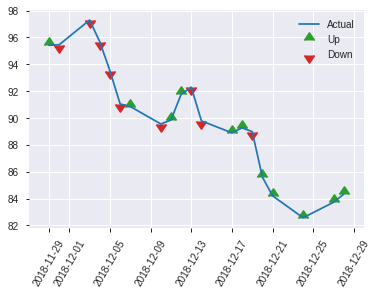


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21168322683860685
RMSE: 0.4600904550614008
LogLoss: 0.6115359249224732
Mean Per-Class Error: 0.32117369695425
AUC: 0.7292595896520964
pr_auc: 0.7371532574560972
Gini: 0.4585191793041927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40361878275871277: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   59   0.5      (59.0/118.0)
1      21   112  0.1579   (21.0/133.0)
Total  80   171  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403619     0.736842  170
max f2                       0.175472     0.862516  238
max f0point5                 0.560076     0.705244  104
max accuracy                 0.403619     0.681275  170
max precision                0.810809     1         0
max recall                   0.175472     1         238
max specificity              0.810809     1         0
max absolute_mcc             0.403619     0.366424  170
max min_per_class_accuracy   0.516872     0.661654  125
max mean_per_class_accuracy  0.560076     0.678826  104

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772022           1.88722   1.88722            1                0.787277  1                           0.787277            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.754541           1.88722   1.88722            1                0.76194   1                           0.774608            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.745824           1.88722   1.88722            1                0.753159  1                           0.769246            0.0150376       0.0601504                  88.7218   88.7218
    4        0.0438247                   0.73229            1.88722   1.88722            1                0.736522  1                           0.760321            0.0225564       0.0827068                  88.7218   88.7218
    5        0.0517928                   0.730281           0.943609  1.74205            0.5              0.731081  0.923077                    0.755823            0.0075188       0.0902256                  -5.6391   74.2047
    6        0.103586                    0.67608            1.45171   1.59688            0.769231         0.700918  0.846154                    0.72837             0.075188        0.165414                   45.1706   59.6877
    7        0.151394                    0.646507           1.25815   1.48991            0.666667         0.654547  0.789474                    0.705058            0.0601504       0.225564                   25.8145   48.9909
    8        0.203187                    0.636253           1.45171   1.48017            0.769231         0.641535  0.784314                    0.688866            0.075188        0.300752                   45.1706   48.0171
    9        0.302789                    0.605958           1.13233   1.36575            0.6              0.620145  0.723684                    0.66626             0.112782        0.413534                   13.2331   36.575
    10       0.40239                     0.563373           1.43429   1.38271            0.76             0.586816  0.732673                    0.646596            0.142857        0.556391                   43.4286   38.2714
    11       0.501992                    0.516872           1.05684   1.31806            0.56             0.543268  0.698413                    0.626094            0.105263        0.661654                   5.68421   31.8057
    12       0.601594                    0.44782            0.905865  1.24981            0.48             0.487526  0.662252                    0.603153            0.0902256       0.75188                    -9.41353  24.9813
    13       0.701195                    0.388228           0.905865  1.20096            0.48             0.420589  0.636364                    0.57722             0.0902256       0.842105                   -9.41353  20.0957
    14       0.800797                    0.307632           0.754887  1.14548            0.4              0.352765  0.606965                    0.549303            0.075188        0.917293                   -24.5113  14.5476
    15       0.900398                    0.21233            0.528421  1.07722            0.28             0.263282  0.570796                    0.517663            0.0526316       0.969925                   -47.1579  7.72174
    16       1                           0.115341           0.301955  1                  0.16             0.171492  0.52988                     0.483184          

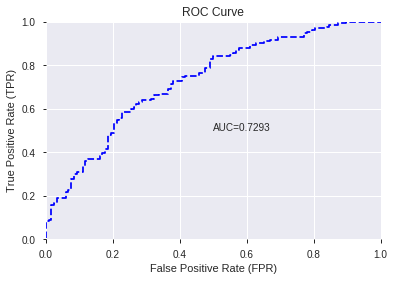

This function is available for GLM models only


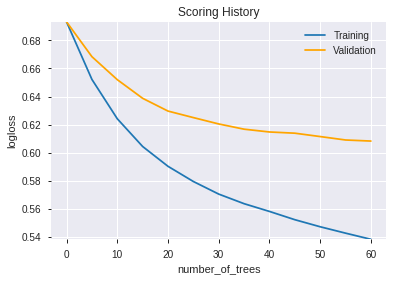

--2019-08-27 13:54:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_135411_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_135411_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'WILLR_12',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'PLUS_DI_12',
 'CORREL_24',
 'aroonup_30',
 'ROCP_14',
 'MACDFIX_14',
 'AROONOSC_24',
 'NATR_8',
 'ADX_24',
 'BBANDS_middleband_8_4_3',
 'MFI_30',
 'aroondown_30',
 'LINEARREG_30',
 'STDDEV_14',
 'VAR_12',
 'BBANDS_middleband_20_5_4',
 'RSI_14',
 'BBANDS_upperband_20_1_3',
 'CDLLONGLINE',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_middleband_24_7_5',
 'days_in_month',
 'ATAN',
 'EMA_24']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_135447_model_1  0.5  16.237353                   0.5  0.685653  0.47012

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.009258           1.000000    0.029338
1                  CDLLONGLINE             0.006696           0.723312    0.021221
2           CDLCLOSINGMARUBOZU             0.006605           0.713441    0.020931
3               STOCHRSI_fastk             0.005958           0.643622    0.018883
4                 STOCHF_fastk             0.005763           0.622534    0.018264
...                        ...                  ...                ...         ...
1039  BBANDS_middleband_30_1_4             0.000000           0.000000    0.000000
1040  BBANDS_middleband_30_1_5             0.000000           0.000000    0.000000
1041   BBANDS_lowerband_30_6_4             0.000000           0.000000    0.000000
1042   BBANDS_lowerband_30_6_5             0.000000           0.000000    0.000000
1043              HT_TRENDMODE             0.000000           0.000000    0.000000

[1044 rows x 4 columns]

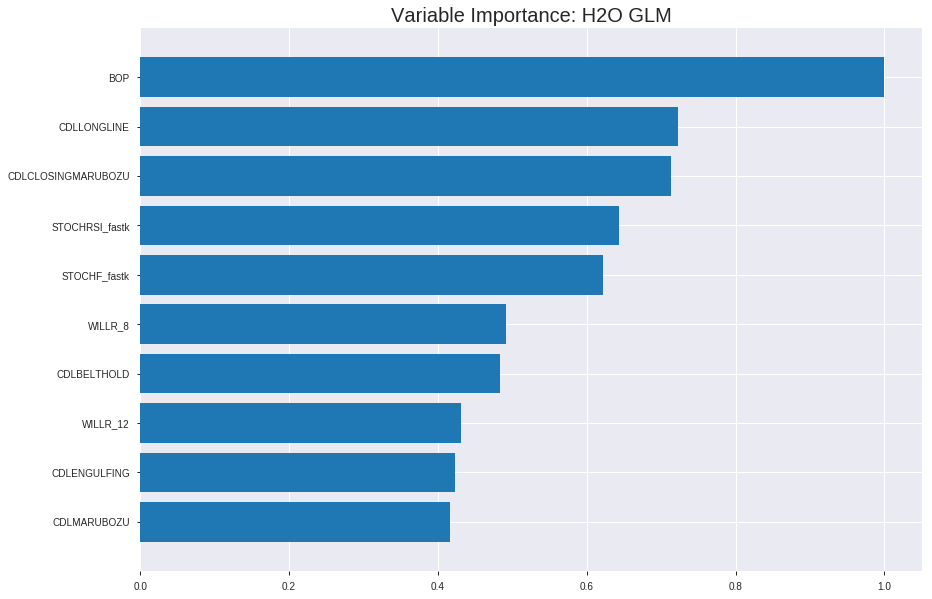

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135447_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24242866145180406
RMSE: 0.49237045144058356
LogLoss: 0.6779367650568529
Null degrees of freedom: 1752
Residual degrees of freedom: 715
Null deviance: 2424.5800523999424
Residual deviance: 2376.846298289326
AIC: 4452.846298289326
AUC: 0.6572292838096532
pr_auc: 0.6653166693589543
Gini: 0.31445856761930635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4943852269688666: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      161  666   0.8053   (666.0/827.0)
1      61   865   0.0659   (61.0/926.0)
Total  222  1531  0.4147   (727.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494385     0.704111  316
max f2                       0.467496     0.851613  378
max f0point5                 0.528868     0.641497  188
max accuracy                 0.528868     0.621221  188
max precision                0.5745       0.8125    23
max recall                   0.435552     1         399
max specificity              0.595658     0.998791  0
max absolute_mcc             0.528868     0.240117  188
max min_per_class_accuracy   0.530527     0.614268  182
max mean_per_class_accuracy  0.528868     0.620073  188

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.581569           1.26206   1.26206            0.666667         0.58627   0.666667                    0.58627             0.012959        0.012959                   26.2059   26.2059
    2        0.0205362                   0.576734           1.57757   1.41982            0.833333         0.57913   0.75                        0.5827              0.0161987       0.0291577                  57.7574   41.9816
    3        0.0302339                   0.573797           1.78173   1.5359             0.941176         0.574796  0.811321                    0.580165            0.0172786       0.0464363                  78.173    53.5902
    4        0.040502                    0.571499           1.4724    1.5198             0.777778         0.572359  0.802817                    0.578186            0.0151188       0.0615551                  47.2402   51.9803
    5        0.0501997                   0.5698             1.44766   1.50587            0.764706         0.57031   0.795455                    0.576665            0.0140389       0.075594                   44.7656   50.5866
    6        0.100399                    0.563274           1.35528   1.43057            0.715909         0.566533  0.755682                    0.571599            0.0680346       0.143629                   35.5279   43.0573
    7        0.150029                    0.556467           1.32734   1.39642            0.701149         0.5597    0.737643                    0.567663            0.0658747       0.209503                   32.7338   39.6423
    8        0.200228                    0.551274           1.35528   1.38611            0.715909         0.553726  0.732194                    0.564169            0.0680346       0.277538                   35.5279   38.6108
    9        0.300057                    0.544181           1.11422   1.29565            0.588571         0.547583  0.684411                    0.558651            0.111231        0.388769                   11.4218   29.565
    10       0.399886                    0.537828           1.11422   1.25036            0.588571         0.54127   0.660485                    0.554312            0.111231        0.5                        11.4218   25.0357
    11       0.500285                    0.530977           1.08637   1.21745            0.573864         0.534412  0.643101                    0.550318            0.109071        0.609071                   8.63747   21.7448
    12       0.600114                    0.52363            0.962771  1.17508            0.508571         0.527123  0.620722                    0.54646             0.0961123       0.705184                   -3.72293  17.5083
    13       0.699943                    0.51519            0.865412  1.13092            0.457143         0.519498  0.597392                    0.542614            0.0863931       0.791577                   -13.4588  13.0916
    14       0.799772                    0.504881           0.778871  1.08697            0.411429         0.509917  0.57418                     0.538533            0.0777538       0.86933                    -22.1129  8.69731
    15       0.899601                    0.490201           0.757235  1.05038            0.4              0.497879  0.554851                    0.534021            0.075594        0.944924                   -24.2765  5.0382
    16       1                           0.435552           0.548565  1                  0.289773         0.47641   0.528237                    0.528237           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3114879736856332
RMSE: 0.5581110764763885
LogLoss: 3.5466397428379635
Null degrees of freedom: 500
Residual degrees of freedom: -537
Null deviance: 693.3071704359105
Residual deviance: 54766.91382476253
AIC: 56842.91382476253
AUC: 0.5270553088155414
pr_auc: 0.4557736662129624
Gini: 0.054110617631082825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4846585035150145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   212  0.8908   (212.0/238.0)
1      11   252  0.0418   (11.0/263.0)
Total  37   464  0.4451   (223.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484659     0.69326   363
max f2                       0.450094     0.846748  399
max f0point5                 0.493074     0.601504  333
max accuracy                 0.493074     0.568862  333
max precision                0.527957     0.569721  160
max recall                   0.450094     1         399
max specificity              1            0.815126  0
max absolute_mcc             0.493074     0.14817   333
max min_per_class_accuracy   0.527957     0.543726  160
max mean_per_class_accuracy  0.493074     0.550812  333

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 64.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.145709                    1                  0.913329  0.913329           0.479452         1         0.479452                    1                   0.13308         0.13308                    -8.66712  -8.66712
    2        0.151697                    1                  0.634981  0.902341           0.333333         1         0.473684                    1                   0.00380228      0.136882                   -36.5019  -9.76586
    3        0.201597                    0.989283           0.761977  0.867598           0.4              0.997735  0.455446                    0.999439            0.0380228       0.174905                   -23.8023  -13.2402
    4        0.301397                    0.607875           1.14297   0.958779           0.6              0.804609  0.503311                    0.934926            0.114068        0.288973                   14.2966   -4.12208
    5        0.401198                    0.540656           1.25726   1.03303            0.66             0.558846  0.542289                    0.841374            0.125475        0.414449                   25.7262   3.30288
    6        0.500998                    0.527957           1.29536   1.08529            0.68             0.534352  0.569721                    0.780214            0.129278        0.543726                   29.5361   8.52862
    7        0.600798                    0.520858           0.838175  1.04424            0.44             0.524043  0.548173                    0.737661            0.0836502       0.627376                   -16.1825  4.42378
    8        0.700599                    0.510049           1.02867   1.04202            0.54             0.515897  0.547009                    0.70607             0.102662        0.730038                   2.86692   4.20201
    9        0.800399                    0.498827           1.10487   1.04986            0.58             0.505144  0.551122                    0.681017            0.110266        0.840304                   10.4867   4.98563
    10       0.9002                      0.487579           0.914373  1.03484            0.48             0.493984  0.543237                    0.660282            0.0912548       0.931559                   -8.56274  3.4836
    11       1                           0.450094           0.685779  1                  0.36             0.47854   0.52495                     0.642144            0.0684411       1                          -31.4221  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:54:51  0.000 sec   2            20        1038          1.35587           109.315
    2019-08-27 13:54:53  2.364 sec   4            15        1044          1.34831           109.554
    2019-08-27 13:54:56  4.665 sec   6            11        1044          1.33897           109.864
    2019-08-27 13:54:58  7.080 sec   8            7.8       1044          1.32767           118.309
    2019-08-27 13:55:00  9.412 sec   10           5.7       1045          1.31423           126.812

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5)

('logloss', 16.23735304621298)

('mean_per_class_error', 0.5)

('rmse', 0.6856526248125582)

('mse', 0.4701195219123506)

glm prediction progress: |████████████████████████████████████████████████| 100%


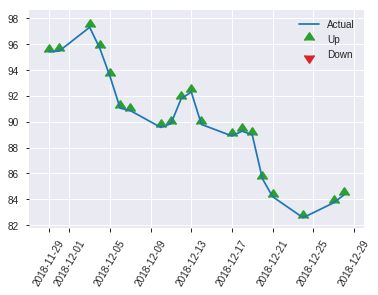


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4701195219123506
RMSE: 0.6856526248125582
LogLoss: 16.23735304621298
Null degrees of freedom: 250
Residual degrees of freedom: -787
Null deviance: 347.0656557889856
Residual deviance: 167181.55477361436
AIC: 169257.55477361436
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.692708  0
max f2                       1            0.849298  0
max f0point5                 1            0.584872  0
max accuracy                 1            0.52988   0
max precision                1            0.52988   0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.52988          1        0.52988                     1                   1               1                          0       0

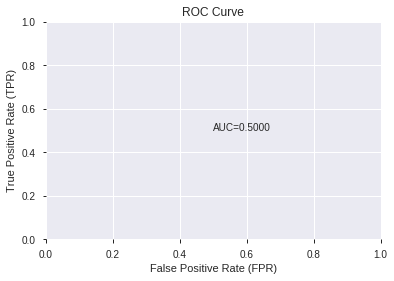

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


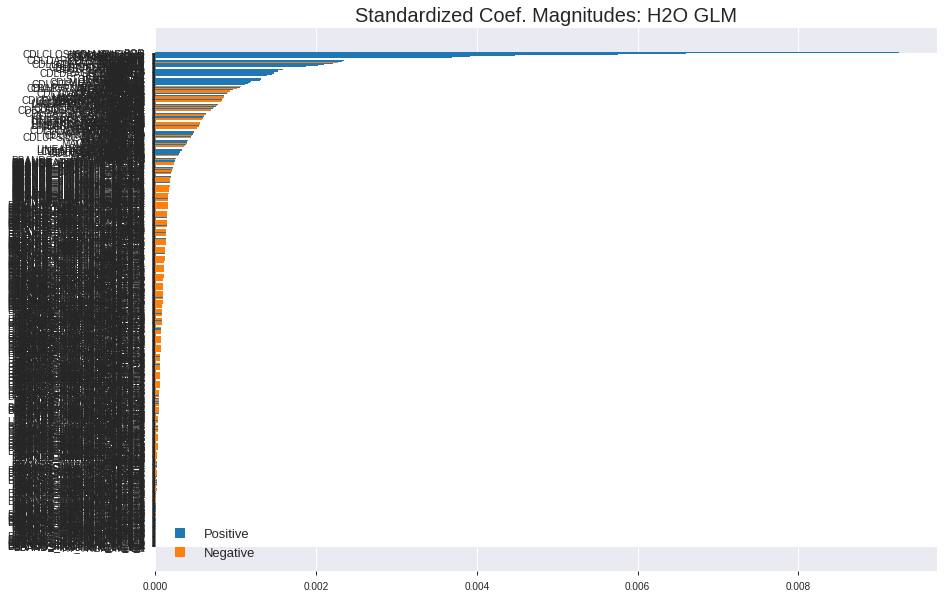

'log_likelihood'
--2019-08-27 13:55:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135447_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135447_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

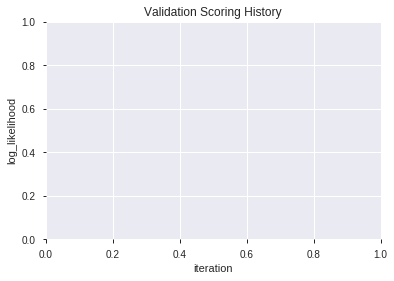

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_135536_model_3  0.767618  0.623734              0.288964  0.465323  0.216526
1               XGBoost_1_AutoML_20190827_135536  0.733019  0.638263              0.337964  0.473401  0.224108
2  XGBoost_grid_1_AutoML_20190827_135536_model_7  0.726838  0.623267              0.337486  0.464804  0.216043
3               XGBoost_3_AutoML_20190827_135536  0.719128  0.628084              0.327100  0.467840  0.218874
4  XGBoost_grid_1_AutoML_20190827_135536_model_4  0.715050  0.620548              0.353001  0.464480  0.215741
5  XGBoost_grid_1_AutoML_20190827_135536_model_1  0.714923  0.626571              0.349242  0.466420  0.217548
6  XGBoost_grid_1_AutoML_20190827_135536_model_2  0.712756  0.647083              0.343093  0.477228  0.227746
7               XGBoost_2_AutoML_20190827_135536  0.712247  0.629051              0.340767  0.468385  0.219385
8  XGBoost_grid_1_AutoML_20190827_135536_model_6  0.703008  0.646314              0.337008  0.477135  0.227658
9  XGBoost_grid_1_AutoML_20190827_135536_model_5  0.701415  0.655025              0.389289  0.481045  0.231405

variable  relative_importance  scaled_importance  percentage
0                       BOP          1632.651123           1.000000    0.204531
1                       DIV           281.222961           0.172249    0.035230
2              STOCHF_fastk           230.788330           0.141358    0.028912
3            STOCHRSI_fastk           224.912781           0.137759    0.028176
4        CDLCLOSINGMARUBOZU           157.355835           0.096381    0.019713
..                      ...                  ...                ...         ...
270                    Open             0.670008           0.000410    0.000084
271  LINEARREG_INTERCEPT_14             0.413963           0.000254    0.000052
272                 ROCP_14             0.309230           0.000189    0.000039
273                  VAR_12             0.228926           0.000140    0.000029
274  BBANDS_lowerband_8_1_5             0.037011           0.000023    0.000005

[275 rows x 4 columns]

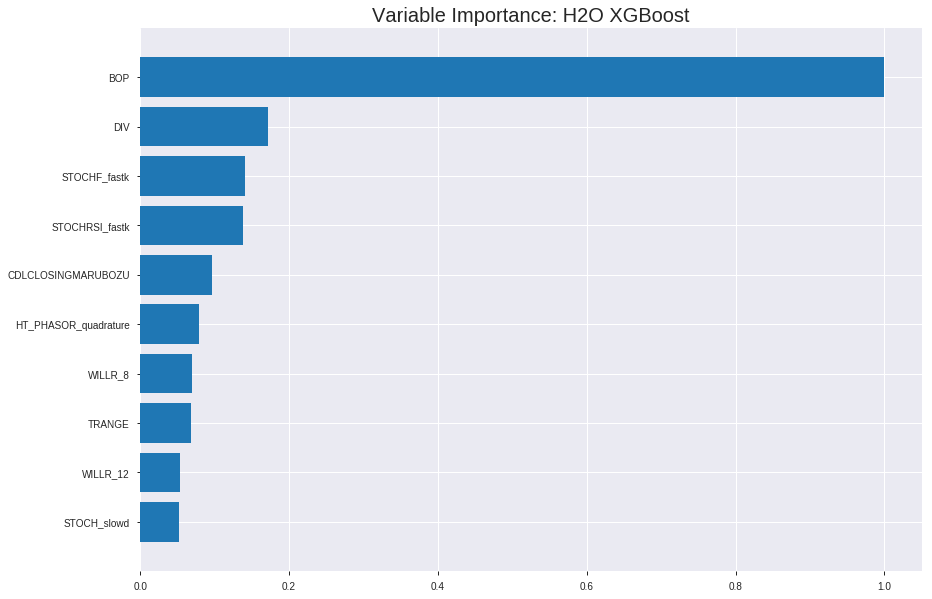

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_135536_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13606853973884186
RMSE: 0.3688746938173475
LogLoss: 0.4405596980602159
Mean Per-Class Error: 0.1553586958508857
AUC: 0.9282686647462398
pr_auc: 0.9392183778277041
Gini: 0.8565373294924796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5504305213689804: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      690  137  0.1657   (137.0/827.0)
1      137  789  0.1479   (137.0/926.0)
Total  827  926  0.1563   (274.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.550431     0.852052  189
max f2                       0.35594      0.907545  280
max f0point5                 0.626743     0.881266  147
max accuracy                 0.562058     0.844267  183
max precision                0.906721     1         0
max recall                   0.200134     1         346
max specificity              0.906721     1         0
max absolute_mcc             0.562058     0.688409  183
max min_per_class_accuracy   0.555265     0.841596  186
max mean_per_class_accuracy  0.562058     0.844641  183

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.87317            1.89309    1.89309            1                0.887923  1                           0.887923            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.861801           1.89309    1.89309            1                0.867513  1                           0.877718            0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.850419           1.89309    1.89309            1                0.854308  1                           0.870209            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.837367           1.89309    1.89309            1                0.842586  1                           0.863206            0.0194384       0.0766739                  89.3089   89.3089
    5        0.0501997                   0.831284           1.89309    1.89309            1                0.834254  1                           0.857613            0.0183585       0.0950324                  89.3089   89.3089
    6        0.100399                    0.795021           1.89309    1.89309            1                0.810456  1                           0.834035            0.0950324       0.190065                   89.3089   89.3089
    7        0.150029                    0.765174           1.89309    1.89309            1                0.78006   1                           0.81618             0.0939525       0.284017                   89.3089   89.3089
    8        0.200228                    0.739541           1.87158    1.8877             0.988636         0.752342  0.997151                    0.800175            0.0939525       0.37797                    87.1576   88.7695
    9        0.300057                    0.688159           1.79573    1.8571             0.948571         0.713408  0.980989                    0.771308            0.179266        0.557235                   79.573    85.7098
    10       0.399886                    0.633446           1.50365    1.76886            0.794286         0.65855   0.934379                    0.743158            0.150108        0.707343                   50.3653   76.8863
    11       0.500285                    0.567672           1.17242    1.64917            0.619318         0.597979  0.871152                    0.714023            0.117711        0.825054                   17.2424   64.9167
    12       0.600114                    0.490393           0.724782   1.4954             0.382857         0.532715  0.789924                    0.683863            0.0723542       0.897408                   -27.5218  49.5396
    13       0.699943                    0.388778           0.594971   1.36697            0.314286         0.441223  0.722086                    0.649256            0.0593952       0.956803                   -40.5029  36.6973
    14       0.799772                    0.284786           0.400253   1.24631            0.211429         0.339459  0.658345                    0.610587            0.0399568       0.99676                    -59.9747  24.6306
    15       0.899601                    0.187644           0.0324529  1.1116             0.0171429        0.234877  0.587191                    0.568894            0.00323974      1                          -96.7547  11.1604
    16       1                           0.0704987          0          1                  0                0.142174  0.528237                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22045815534083593
RMSE: 0.4695297172073733
LogLoss: 0.6306443802211679
Mean Per-Class Error: 0.3491628590599738
AUC: 0.6941799533501614
pr_auc: 0.6945118914434403
Gini: 0.3883599067003227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3439953923225403: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   169  0.7101   (169.0/238.0)
1      19   244  0.0722   (19.0/263.0)
Total  88   413  0.3752   (188.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343995     0.721893  322
max f2                       0.283293     0.854388  355
max f0point5                 0.481147     0.666667  239
max accuracy                 0.481147     0.656687  239
max precision                0.822916     1         0
max recall                   0.171715     1         393
max specificity              0.822916     1         0
max absolute_mcc             0.466418     0.313919  250
max min_per_class_accuracy   0.527345     0.630252  198
max mean_per_class_accuracy  0.481147     0.650837  239

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.784695           1.58745   1.58745            0.833333         0.809603  0.833333                    0.809603            0.0190114       0.0190114                  58.7452    58.7452
    2        0.0219561                   0.761733           1.14297   1.38541            0.6              0.767226  0.727273                    0.790341            0.0114068       0.0304183                  14.2966    38.5413
    3        0.0319361                   0.748728           1.52395   1.42871            0.8              0.754595  0.75                        0.77917             0.0152091       0.0456274                  52.3954    42.8707
    4        0.0419162                   0.735299           1.90494   1.5421             1                0.742353  0.809524                    0.770404            0.0190114       0.0646388                  90.4943    54.2097
    5        0.0518962                   0.727575           1.90494   1.61187            1                0.729617  0.846154                    0.762561            0.0190114       0.0836502                  90.4943    61.1875
    6        0.101796                    0.688807           1.67635   1.64348            0.88             0.703569  0.862745                    0.733643            0.0836502       0.1673                     67.635     64.348
    7        0.151697                    0.663548           1.21916   1.5039             0.64             0.676711  0.789474                    0.714915            0.0608365       0.228137                   21.9163    50.3902
    8        0.201597                    0.641407           1.14297   1.41456            0.6              0.651908  0.742574                    0.69932             0.0570342       0.285171                   14.2966    41.4562
    9        0.301397                    0.604316           1.25726   1.36248            0.66             0.624888  0.715232                    0.674673            0.125475        0.410646                   25.7262    36.2476
    10       0.401198                    0.566312           1.10487   1.29839            0.58             0.585929  0.681592                    0.652598            0.110266        0.520913                   10.4867    29.8394
    11       0.500998                    0.528926           1.02867   1.24466            0.54             0.5484    0.653386                    0.631841            0.102662        0.623574                   2.86692    24.4664
    12       0.600798                    0.49415            0.99057   1.20246            0.52             0.510537  0.631229                    0.611691            0.0988593       0.722433                   -0.942966  20.2456
    13       0.700599                    0.441452           0.952471  1.16685            0.5              0.467514  0.612536                    0.591153            0.095057        0.81749                    -4.75285   16.6845
    14       0.800399                    0.35971            0.838175  1.12586            0.44             0.405243  0.591022                    0.567972            0.0836502       0.901141                   -16.1825   12.5864
    15       0.9002                      0.284234           0.723878  1.0813             0.38             0.324575  0.567627                    0.540988            0.0722433       0.973384                   -27.6122   8.1298
    16       1                           0.0965669          0.266692  1                  0.14             0.218115  0.52495                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:56:05  8.829 sec   0                  0.5              0.693147            0.5             0                  1                0.471763                         0.5                0.693147              0.5               0                    1                  0.47505
    2019-08-27 13:56:06  10.117 sec  5                  0.472277         0.638901            0.839467        0.849268           1.89309          0.266971                         0.491452           0.676111              0.651253          0.647527             1.58745            0.367265
    2019-08-27 13:56:07  10.531 sec  10                 0.451596         0.599419            0.861307        0.873008           1.89309          0.248716                         0.485003           0.663289              0.675951          0.652149             0.952471           0.367265
    2019-08-27 13:56:07  10.951 sec  15                 0.435008         0.567683            0.870228        0.882899           1.89309          0.247576                         0.478807           0.650908              0.688788          0.669827             0.634981           0.347305
    2019-08-27 13:56:08  11.361 sec  20                 0.420145         0.539325            0.883813        0.899232           1.89309          0.225328                         0.475862           0.644799              0.684459          0.666069             1.26996            0.371257
    2019-08-27 13:56:08  11.797 sec  25                 0.409036         0.517724            0.890428        0.904889           1.89309          0.218483                         0.474413           0.641588              0.684163          0.671228             1.26996            0.365269
    2019-08-27 13:56:08  12.208 sec  30                 0.400134         0.500097            0.89693         0.912549           1.89309          0.21506                          0.472879           0.638147              0.6862            0.675558             1.26996            0.37525
    2019-08-27 13:56:09  12.616 sec  35                 0.392456         0.485387            0.903907        0.918507           1.89309          0.199087                         0.472973           0.638274              0.685082          0.682861             1.58745            0.37525
    2019-08-27 13:56:09  13.032 sec  40                 0.386362         0.473594            0.911207        0.925495           1.89309          0.180833                         0.472481           0.636908              0.684171          0.684238             1.58745            0.383234
    2019-08-27 13:56:10  13.481 sec  45                 0.380515         0.462019            0.914372        0.928356           1.89309          0.183115                         0.469389           0.630675              0.69656           0.69552              1.58745            0.371257
    2019-08-27 13:56:10  13.888 sec  50                 0.375208         0.452467            0.922286        0.934718           1.89309          0.160297                         0.470059           0.631922              0.693645          0.695537             1.58745            0.373253
    2019-08-27 13:56:10  14.306 sec  55                 0.368875         0.44056             0.928269        0.939218           1.89309          0.156303                         0.46953            0.630644              0.69418           0.69

Variable Importances: 


variable                relative_importance    scaled_importance       percentage
----------------------  ---------------------  ----------------------  ----------------------
BOP                     1632.651123046875      1.0                     0.20453136494039487
DIV                     281.22296142578125     0.17224926835621762     0.035230377966881554
STOCHF_fastk            230.788330078125       0.14135801998373343     0.028912148772544614
STOCHRSI_fastk          224.91278076171875     0.13775924175520338     0.028176085749345586
CDLCLOSINGMARUBOZU      157.3558349609375      0.09638056333019755     0.019712848171649474
---                     ---                    ---                     ---
Open                    0.6700077056884766     0.00041038020691040186  8.393562386390616e-05
LINEARREG_INTERCEPT_14  0.41396331787109375    0.0002535528331971805   5.18595070583236e-05
ROCP_14                 0.30922985076904297    0.00018940350844334346  3.873895810641664e-05
VAR_12                  0.2289257049560547     0.0001402171607421128   2.8678807274651087e-05
BBANDS_lowerband_8_1_5  0.037011146545410156   2.2669354170620033e-05  4.636593950834148e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7697368421052632)

('auc', 0.7676181980374666)

('logloss', 0.623733606388496)

('mean_per_class_error', 0.2690837262648146)

('rmse', 0.4653232758754815)

('mse', 0.21652575107148947)

xgboost prediction progress: |████████████████████████████████████████████| 100%


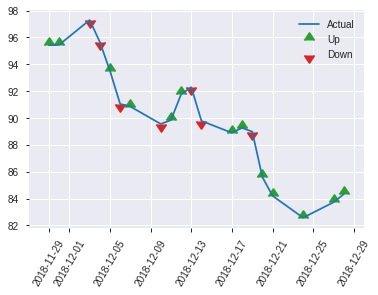


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21652575107148947
RMSE: 0.4653232758754815
LogLoss: 0.623733606388496
Mean Per-Class Error: 0.2690837262648146
AUC: 0.7676181980374666
pr_auc: 0.7421769077808092
Gini: 0.5352363960749331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38796424865722656: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   54   0.4576   (54.0/118.0)
1      16   117  0.1203   (16.0/133.0)
Total  80   171  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387964     0.769737  170
max f2                       0.300877     0.866035  206
max f0point5                 0.431762     0.744526  137
max accuracy                 0.431762     0.733068  137
max precision                0.766951     1         0
max recall                   0.0972252    1         250
max specificity              0.766951     1         0
max absolute_mcc             0.431762     0.463311  137
max min_per_class_accuracy   0.441945     0.706767  126
max mean_per_class_accuracy  0.431762     0.730916  137

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 43.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.656152           1.25815   1.25815            0.666667         0.70354   0.666667                    0.70354             0.0150376       0.0150376                  25.8145   25.8145
    2        0.0239044                   0.643091           1.88722   1.57268            1                0.645307  0.833333                    0.674424            0.0225564       0.037594                   88.7218   57.2682
    3        0.0318725                   0.63201            1.88722   1.65132            1                0.637614  0.875                       0.665221            0.0150376       0.0526316                  88.7218   65.1316
    4        0.0438247                   0.612609           1.25815   1.54409            0.666667         0.624857  0.818182                    0.654213            0.0150376       0.0676692                  25.8145   54.4087
    5        0.0517928                   0.611731           1.88722   1.59688            1                0.61175   0.846154                    0.64768             0.0150376       0.0827068                  88.7218   59.6877
    6        0.103586                    0.581938           1.45171   1.52429            0.769231         0.598203  0.807692                    0.622941            0.075188        0.157895                   45.1706   52.4291
    7        0.151394                    0.570147           1.57268   1.53957            0.833333         0.576168  0.815789                    0.608171            0.075188        0.233083                   57.2682   53.9573
    8        0.203187                    0.553809           1.45171   1.51718            0.769231         0.562562  0.803922                    0.596545            0.075188        0.308271                   45.1706   51.7175
    9        0.302789                    0.508573           1.3588    1.46508            0.72             0.534756  0.776316                    0.57622             0.135338        0.443609                   35.8797   46.5077
    10       0.40239                     0.474734           1.13233   1.38271            0.6              0.490469  0.732673                    0.554994            0.112782        0.556391                   13.2331   38.2714
    11       0.501992                    0.444317           1.43429   1.39295            0.76             0.460763  0.738095                    0.536298            0.142857        0.699248                   43.4286   39.2947
    12       0.601594                    0.416162           0.981353  1.3248             0.52             0.430289  0.701987                    0.518746            0.0977444       0.796992                   -1.86466  32.4802
    13       0.701195                    0.373813           0.905865  1.26529            0.48             0.398604  0.670455                    0.501681            0.0902256       0.887218                   -9.41353  26.5294
    14       0.800797                    0.316987           0.528421  1.17364            0.28             0.34623   0.621891                    0.482346            0.0526316       0.93985                    -47.1579  17.3643
    15       0.900398                    0.231392           0.377444  1.08557            0.2              0.283375  0.575221                    0.460336            0.037594        0.977444                   -62.2556  8.55679
    16       1                           0.0972252          0.226466  1                  0.12             0.187099  0.52988                     0.433121         

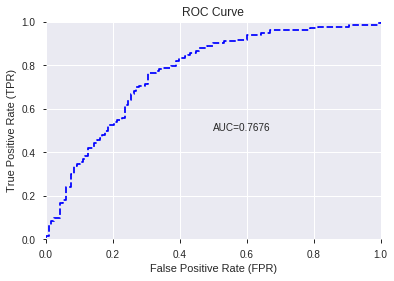

This function is available for GLM models only


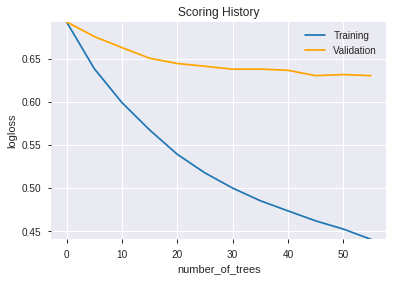

--2019-08-27 13:56:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.89.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.89.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_135536_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_135536_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_135653_model_4  0.5  16.237353                   0.5  0.685653  0.470120
1  DeepLearning_grid_1_AutoML_20190827_135653_model_6  0.5   0.692654                   0.5  0.499748  0.249748
2  DeepLearning_grid_1_AutoML_20190827_135653_model_9  0.5  18.301423                   0.5  0.727929  0.529880
3               DeepLearning_1_AutoML_20190827_135653  0.5  18.301423                   0.5  0.727929  0.529880
4  DeepLearning_grid_1_AutoML_20190827_135653_model_5  0.5   0.691514                   0.5  0.499183  0.249184
5  DeepLearning_grid_1_AutoML_20190827_135653_model_7  0.5  16.237353                   0.5  0.685653  0.470120
6  DeepLearning_grid_1_AutoML_20190827_135653_model_1  0.5  18.301423                   0.5  0.727929  0.529880
7  DeepLearning_grid_1_AutoML_20190827_135653_model_2  0.5  18.301423                   0.5  0.727929  0.529880
8  DeepLearning_grid_1_AutoML_20190827_135653_model_8  0.5   0.691361                   0.5  0.499107  0.249108
9  DeepLearning_grid_1_AutoML_20190827_135653_model_3  0.5  18.301423                   0.5  0.727929  0.529880

variable  relative_importance  scaled_importance  percentage
0          CDL3WHITESOLDIERS             1.000000           1.000000    0.027436
1        CDLRISEFALL3METHODS             0.961194           0.961194    0.026372
2             CDL3LINESTRIKE             0.953311           0.953311    0.026155
3            CDLLADDERBOTTOM             0.950711           0.950711    0.026084
4                  CDLINNECK             0.942580           0.942580    0.025861
5         CDLMORNINGDOJISTAR             0.928931           0.928931    0.025487
6         CDLUPSIDEGAP2CROWS             0.901492           0.901492    0.024734
7                       TANH             0.870146           0.870146    0.023874
8             CDLEVENINGSTAR             0.857980           0.857980    0.023540
9             CDLMORNINGSTAR             0.857897           0.857897    0.023538
10       CDLGAPSIDESIDEWHITE             0.854998           0.854998    0.023458
11           CDLADVANCEBLOCK             0.826254           0.826254    0.022669
12             CDLHANGINGMAN             0.803426           0.803426    0.022043
13          CDLDRAGONFLYDOJI             0.798222           0.798222    0.021900
14                       EXP             0.795246           0.795246    0.021819
15         CDLDARKCLOUDCOVER             0.786298           0.786298    0.021573
16            is_quarter_end             0.764764           0.764764    0.020982
17               CDLDOJISTAR             0.739704           0.739704    0.020295
18               CDLLONGLINE             0.701043           0.701043    0.019234
19                       BOP             0.690957           0.690957    0.018957
20              HT_TRENDMODE             0.682990           0.682990    0.018739
21              is_month_end             0.678181           0.678181    0.018607
22                      ATAN             0.676620           0.676620    0.018564
23                 CORREL_24             0.670772           0.670772    0.018404
24                       DIV             0.661796           0.661796    0.018157
25             days_in_month             0.661505           0.661505    0.018149
26              aroondown_30             0.660208           0.660208    0.018114
27  BBANDS_middleband_24_7_5             0.657781           0.657781    0.018047
28                MACDFIX_14             0.656386           0.656386    0.018009
29              aroondown_12             0.654864           0.654864    0.017967
30        CDLCLOSINGMARUBOZU             0.654802           0.654802    0.017965
31                    RSI_14             0.653830           0.653830    0.017939
32                 STDDEV_14             0.652621           0.652621    0.017906
33   BBANDS_middleband_8_4_3             0.651809           0.651809    0.017883
34                    VAR_12             0.650353           0.650353    0.017843
35   BBANDS_lowerband_12_5_2             0.648026           0.648026    0.017780
36                    ADX_24             0.647298           0.647298    0.017760
37               AROONOSC_24             0.647162           0.647162    0.017756
38                   ROCP_14             0.647030           0.647030    0.017752
39                     CCI_8             0.644611           0.644611    0.017686
40                  WILLR_12             0.638040           0.638040    0.017506
41      HT_PHASOR_quadrature             0.637591           0.637591    0.017493
42                PLUS_DI_12             0.636837           0.636837    0.017473
43                    MFI_30             0.635850           0.635850    0.017445
44                    EMA_24             0.635552           0.635552    0.017437
45                    NATR_8             0.635338           0.635338    0.017431
46                aroonup_30             0.633391           0.633391    0.017378
47   BBANDS_upperband_20_1_3             0.632941           0.632941    0.017366
48  BBANDS_middleband_20_5_4             0.616387  

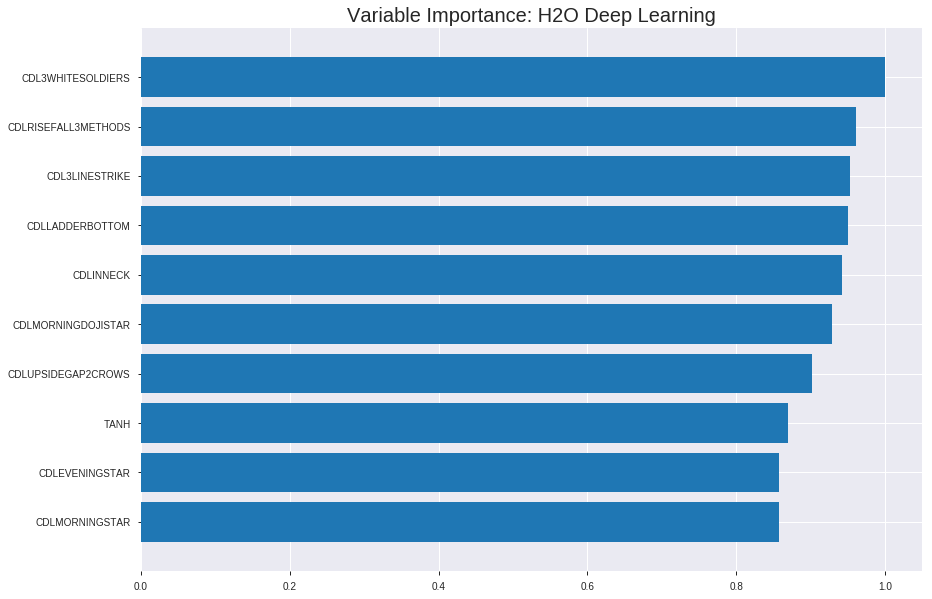

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_135653_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21850669119299382
RMSE: 0.4674469929232552
LogLoss: 0.6889969319863908
Mean Per-Class Error: 0.2993743813675076
AUC: 0.7693117803296414
pr_auc: 0.7636625286785536
Gini: 0.5386235606592829
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46444729522083017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      422  405   0.4897   (405.0/827.0)
1      125  801   0.135    (125.0/926.0)
Total  547  1206  0.3023   (530.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464447     0.751407  237
max f2                       0.119166     0.863254  350
max f0point5                 0.696398     0.716561  155
max accuracy                 0.696398     0.702225  155
max precision                0.991624     0.94186   6
max recall                   0.00033858   1         399
max specificity              0.999924     0.998791  0
max absolute_mcc             0.464447     0.404349  237
max min_per_class_accuracy   0.728781     0.695284  142
max mean_per_class_accuracy  0.696398     0.700626  155

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 62.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.998328           1.68275   1.68275            0.888889         0.999663   0.888889                    0.999663            0.0172786       0.0172786                  68.2745   68.2745
    2        0.0205362                   0.996629           1.68275   1.68275            0.888889         0.997407   0.888889                    0.998535            0.0172786       0.0345572                  68.2745   68.2745
    3        0.0302339                   0.994173           1.89309   1.75021            1                0.995391   0.924528                    0.997527            0.0183585       0.0529158                  89.3089   75.0214
    4        0.040502                    0.992284           1.78792   1.75977            0.944444         0.993206   0.929577                    0.996431            0.0183585       0.0712743                  78.7917   75.9772
    5        0.0501997                   0.99059            1.89309   1.78553            1                0.991568   0.943182                    0.995492            0.0183585       0.0896328                  89.3089   78.5527
    6        0.100399                    0.978852           1.61343   1.69948            0.852273         0.985125   0.897727                    0.990308            0.0809935       0.170626                   61.3428   69.9477
    7        0.150029                    0.965185           1.52317   1.64116            0.804598         0.972391   0.86692                     0.984381            0.075594        0.24622                    52.3175   64.1157
    8        0.200228                    0.951204           1.37679   1.57488            0.727273         0.958646   0.831909                    0.977929            0.0691145       0.315335                   37.6792   57.4877
    9        0.300057                    0.910127           1.34139   1.4972             0.708571         0.933799   0.790875                    0.963247            0.133909        0.449244                   34.1388   49.7196
    10       0.399886                    0.850336           1.18994   1.42049            0.628571         0.885548   0.750357                    0.94385             0.11879         0.568035                   18.9941   42.0492
    11       0.500285                    0.741776           1.15091   1.36639            0.607955         0.796822   0.721779                    0.914344            0.115551        0.683585                   15.0912   36.6391
    12       0.600114                    0.608699           0.973588  1.30105            0.514286         0.677895   0.687262                    0.875011            0.0971922       0.780778                   -2.64116  30.1049
    13       0.699943                    0.436805           0.908683  1.24509            0.48             0.526289   0.657702                    0.825274            0.0907127       0.87149                    -9.13175  24.5088
    14       0.799772                    0.236691           0.638241  1.16934            0.337143         0.330346   0.617689                    0.763497            0.0637149       0.935205                   -36.1759  16.934
    15       0.899601                    0.0777142          0.443524  1.0888             0.234286         0.154107   0.575143                    0.695873            0.0442765       0.979482                   -55.6476  8.8796
    16       1                           3.08957e-09        0.204368  1                  0.107955         0.0303092  0.528237                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3526571988971903
RMSE: 0.5938494749489893
LogLoss: 6.227985279048492
Mean Per-Class Error: 0.43227785410742237
AUC: 0.5536313384669457
pr_auc: 0.37839670392117936
Gini: 0.10726267693389135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.187665440978907: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   200  0.8403   (200.0/238.0)
1      9    254  0.0342   (9.0/263.0)
Total  47   454  0.4172   (209.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.187665     0.708508  291
max f2                       0.0125982    0.848935  334
max f0point5                 0.222643     0.613046  281
max accuracy                 0.222643     0.586826  281
max precision                0.93253      0.586777  79
max recall                   0.0125982    1         334
max specificity              1            0.668067  0
max absolute_mcc             0.187665     0.214851  291
max min_per_class_accuracy   0.917079     0.558824  89
max mean_per_class_accuracy  0.222643     0.567722  281

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 76.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.295409                    1                  0.9396    0.9396             0.493243         1         0.493243                    1                   0.277567        0.277567                   -6.03998   -6.03998
    2        0.301397                    1                  0         0.920933           0                1         0.483444                    1                   0               0.277567                   -100       -7.90673
    3        0.401198                    0.981804           1.21916   0.995119           0.64             0.997329  0.522388                    0.999336            0.121673        0.39924                    21.9163    -0.488054
    4        0.500998                    0.918998           1.56205   1.10805            0.82             0.951276  0.581673                    0.989762            0.155894        0.555133                   56.2053    10.8054
    5        0.600798                    0.85926            0.952471  1.08221            0.5              0.889512  0.568106                    0.973109            0.095057        0.65019                    -4.75285   8.22101
    6        0.700599                    0.710934           0.99057   1.06916            0.52             0.775215  0.561254                    0.944919            0.0988593       0.749049                   -0.942966  6.9156
    7        0.800399                    0.456004           1.10487   1.07361            0.58             0.599796  0.563591                    0.901886            0.110266        0.859316                   10.4867    7.36088
    8        0.9002                      0.189434           0.99057   1.0644             0.52             0.335805  0.558758                    0.839128            0.0988593       0.958175                   -0.942966  6.44027
    9        1                           0.000144671        0.419087  1                  0.22             0.093782  0.52495                     0.764742            0.0418251       1                          -58.0913   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:58:50  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:58:55  5.751 sec   316 obs/sec       0.930405  1             1631       0.548448         1.40131             -0.20703       0.717282        0.66713            1.78792          0.3668                           0.646809           8.22637               -0.677626        0.536234          0.32223              0.94787            0.443114
    2019-08-27 13:59:04  14.496 sec  367 obs/sec       2.79407   3             4898       0.606619         1.43812             -0.476654      0.749977        0.756149           1.89309          0.349686                         0.659204           8.22624               -0.74254         0.583443          0.660164             1.90494            0.47505
    2019-08-27 13:59:11  21.907 sec  406 obs/sec       4.67427   5             8194       0.471931         0.70209             0.106275       0.757757        0.755177           1.78792          0.326298                         0.607983           7.61473               -0.482265        0.568872          0.624966             1.90494            0.47505
    2019-08-27 13:59:18  28.454 sec  439 obs/sec       6.54763   7             11478      0.467447         0.688997            0.123177       0.769312        0.763663           1.68275          0.302339                         0.593849           6.22799               -0.41415         0.553631          0.378397             0.9396             0.417166
    2019-08-27 13:59:26  36.730 sec  485 obs/sec       9.35881   10            16406      0.502095         0.835521            -0.0116222     0.795403        0.759639           1.78792          0.27895                          0.613168           7.34891               -0.507653        0.537599          0.338547             0.979077           0.439122
    2019-08-27 13:59:33  43.973 sec  526 obs/sec       12.1666   13            21328      0.52069          0.887635            -0.0879401     0.769727        0.793666           1.89309          0.311466                         0.627848           7.65688               -0.580711        0.567291          0.602153             0.952471           0.47505
    2019-08-27 13:59:40  50.843 sec  561 obs/sec       14.9795   16            26259      0.424021         0.5488              0.278522       0.807374        0.786451           1.89309          0.27895                          0.590947           7.69884               -0.400361        0.541202          0.321305             0.94787            0.401198
    2019-08-27 13:59:46  56.627 sec  599 obs/sec       17.7781   19            31165      0.422749         0.542283            0.282847       0.826132        0.829892           1.89309          0.264119                         0.601527           6.91254               -0.450953        0.539588          0.350519             0.963947           0.397206
    2019-08-27 13:59:47  57.218 sec  599 obs/sec       17.7781   19            31165      0.

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDL3WHITESOLDIERS         1.0                    1.0                  0.02743641482992834
CDLRISEFALL3METHODS       0.9611936807632446     0.9611936807632446   0.026371708557326092
CDL3LINESTRIKE            0.9533107876777649     0.9533107876777649   0.026155430232572895
CDLLADDERBOTTOM           0.9507112503051758     0.9507112503051758   0.026084108246852637
CDLINNECK                 0.9425798058509827     0.9425798058509827   0.025861010563640877
---                       ---                    ---                  ---
NATR_8                    0.6353377103805542     0.6353377103805542   0.017431388979097753
aroonup_30                0.6333911418914795     0.6333911418914795   0.017377982118536632
BBANDS_upperband_20_1_3   0.632941484451294      0.632941484451294    0.01736564513047634
BBANDS_middleband_20_5_4  0.6163866519927979     0.6163866519927979   0.016911439879705076
LINEARREG_30              0.6021861433982849     0.6021861433982849   0.016521828835110056


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5)

('logloss', 16.23735304621298)

('mean_per_class_error', 0.5)

('rmse', 0.6856526248125582)

('mse', 0.4701195219123506)

deeplearning prediction progress: |███████████████████████████████████████| 100%


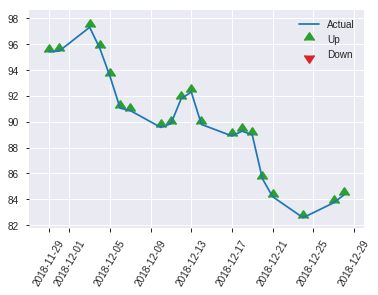


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4701195219123506
RMSE: 0.6856526248125582
LogLoss: 16.23735304621298
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.692708  0
max f2                       1            0.849298  0
max f0point5                 1            0.584872  0
max accuracy                 1            0.52988   0
max precision                1            0.52988   0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.52988          1        0.52988                     1                   1               1                          0       0

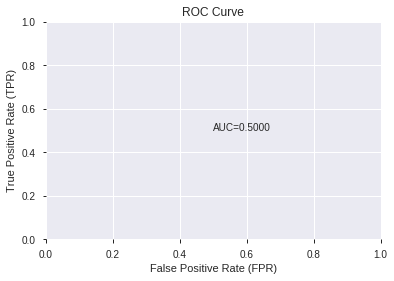

This function is available for GLM models only


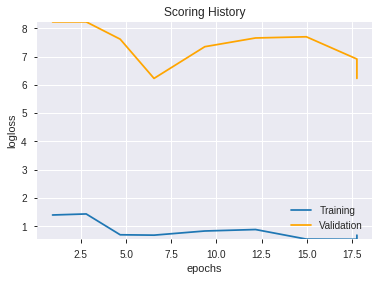

--2019-08-27 14:06:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_135653_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_135653_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3WHITESOLDIERS',
 'CDLRISEFALL3METHODS',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLUPSIDEGAP2CROWS',
 'TANH',
 'CDLEVENINGSTAR',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'EXP',
 'CDLDARKCLOUDCOVER',
 'is_quarter_end',
 'CDLDOJISTAR',
 'CDLLONGLINE',
 'BOP',
 'HT_TRENDMODE',
 'is_month_end',
 'ATAN',
 'CORREL_24',
 'DIV',
 'days_in_month',
 'aroondown_30',
 'BBANDS_middleband_24_7_5',
 'MACDFIX_14',
 'aroondown_12',
 'CDLCLOSINGMARUBOZU',
 'RSI_14',
 'STDDEV_14',
 'BBANDS_middleband_8_4_3',
 'VAR_12',
 'BBANDS_lowerband_12_5_2',
 'ADX_24',
 'AROONOSC_24',
 'ROCP_14',
 'CCI_8',
 'WILLR_12',
 'HT_PHASOR_quadrature',
 'PLUS_DI_12',
 'MFI_30',
 'EMA_24',
 'NATR_8',
 'aroonup_30',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_5_4',
 'LINEARREG_30']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_140637_model_1  0.5  18.301423                   0.5  0.727929  0.52988

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.118277           1.000000    0.147279
1         CDLCLOSINGMARUBOZU             0.077507           0.655304    0.096512
2                CDLLONGLINE             0.076818           0.649477    0.095654
3                   WILLR_12             0.049090           0.415042    0.061127
4                        DIV             0.045387           0.383738    0.056516
5          CDLDARKCLOUDCOVER             0.032929           0.278404    0.041003
6              CDLHANGINGMAN             0.029043           0.245553    0.036165
7                      CCI_8             0.023216           0.196287    0.028909
8             CDLEVENINGSTAR             0.021927           0.185385    0.027303
9           CDLDRAGONFLYDOJI             0.019879           0.168072    0.024753
10                    RSI_14             0.019478           0.164677    0.024253
11                    NATR_8             0.015943           0.134795    0.019852
12                 CORREL_24             0.015203           0.128538    0.018931
13                aroonup_30             0.014968           0.126547    0.018638
14                   ROCP_14             0.014236           0.120362    0.017727
15            CDLMORNINGSTAR             0.012874           0.108844    0.016030
16               AROONOSC_24             0.012725           0.107584    0.015845
17              aroondown_12             0.012362           0.104518    0.015393
18        CDLMORNINGDOJISTAR             0.012302           0.104014    0.015319
19                MACDFIX_14             0.011491           0.097156    0.014309
20                 STDDEV_14             0.011034           0.093287    0.013739
21                 CDLINNECK             0.010855           0.091777    0.013517
22       CDLRISEFALL3METHODS             0.010539           0.089101    0.013123
23         CDL3WHITESOLDIERS             0.009752           0.082447    0.012143
24                    VAR_12             0.009223           0.077980    0.011485
25            is_quarter_end             0.008180           0.069163    0.010186
26      HT_PHASOR_quadrature             0.008054           0.068093    0.010029
27       CDLGAPSIDESIDEWHITE             0.007695           0.065056    0.009581
28           CDLADVANCEBLOCK             0.006510           0.055040    0.008106
29            CDL3LINESTRIKE             0.006396           0.054079    0.007965
30                    ADX_24             0.006326           0.053483    0.007877
31                PLUS_DI_12             0.006326           0.053481    0.007877
32           CDLLADDERBOTTOM             0.005909           0.049958    0.007358
33        CDLUPSIDEGAP2CROWS             0.005649           0.047757    0.007034
34              LINEARREG_30             0.005325           0.045023    0.006631
35   BBANDS_upperband_20_1_3             0.005091           0.043045    0.006340
36  BBANDS_middleband_24_7_5             0.004873           0.041203    0.006068
37  BBANDS_middleband_20_5_4             0.004757           0.040217    0.005923
38   BBANDS_lowerband_12_5_2             0.004535           0.038338    0.005646
39   BBANDS_middleband_8_4_3             0.004500           0.038048    0.005604
40                    EMA_24             0.004359           0.036853    0.005428
41              aroondown_30             0.004325           0.036569    0.005386
42              is_month_end             0.004195           0.035469    0.005224
43                      TANH             0.004001           0.033828    0.004982
44                      ATAN             0.002709           0.022900    0.003373
45                    MFI_30             0.002514           0.021257    0.003131
46             days_in_month             0.002016           0.017047    0.002511
47               CDLDOJISTAR             0.000987           0.008343    0.001229
48              HT_TRENDMODE             0.000782  

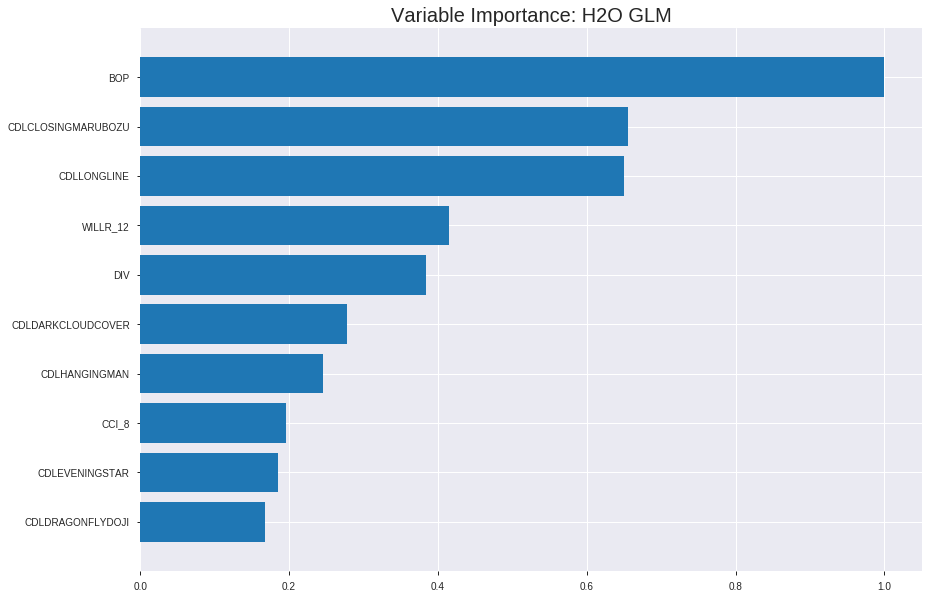

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_140637_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22260817312996195
RMSE: 0.4718137059581482
LogLoss: 0.6372420713608787
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2424.5800523999424
Residual deviance: 2234.1707021912407
AIC: 2336.1707021912407
AUC: 0.7466446940592999
pr_auc: 0.746812846138361
Gini: 0.4932893881185998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4673570228466326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      268  559   0.6759   (559.0/827.0)
1      54   872   0.0583   (54.0/926.0)
Total  322  1431  0.3497   (613.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467357     0.739924  287
max f2                       0.435397     0.859806  320
max f0point5                 0.527954     0.702886  199
max accuracy                 0.524857     0.685682  203
max precision                0.764003     1         0
max recall                   0.373642     1         371
max specificity              0.764003     1         0
max absolute_mcc             0.508297     0.369083  228
max min_per_class_accuracy   0.529028     0.678356  197
max mean_per_class_accuracy  0.527954     0.684556  199

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.691757           1.78792   1.78792            0.944444         0.710046  0.944444                    0.710046            0.0183585       0.0183585                  78.7917   78.7917
    2        0.0205362                   0.681115           1.57757   1.68275            0.833333         0.685171  0.888889                    0.697609            0.0161987       0.0345572                  57.7574   68.2745
    3        0.0302339                   0.673998           1.55901   1.64306            0.823529         0.677706  0.867925                    0.691225            0.0151188       0.049676                   55.9014   64.3058
    4        0.040502                    0.666125           1.89309   1.70645            1                0.670576  0.901408                    0.68599             0.0194384       0.0691145                  89.3089   70.6446
    5        0.0501997                   0.658955           1.55901   1.67796            0.823529         0.661602  0.886364                    0.681279            0.0151188       0.0842333                  55.9014   67.7965
    6        0.100399                    0.628724           1.52738   1.60267            0.806818         0.64284   0.846591                    0.662059            0.0766739       0.160907                   52.7378   60.2672
    7        0.150029                    0.601883           1.54493   1.58357            0.816092         0.614736  0.836502                    0.646405            0.0766739       0.237581                   54.4934   58.3572
    8        0.200228                    0.584473           1.29074   1.51016            0.681818         0.592825  0.797721                    0.632972            0.0647948       0.302376                   29.0742   51.0156
    9        0.300057                    0.563521           1.30894   1.44321            0.691429         0.572686  0.762357                    0.612915            0.13067         0.433045                   30.8936   44.321
    10       0.399886                    0.545558           1.27648   1.40159            0.674286         0.554742  0.740371                    0.598392            0.12743         0.560475                   27.6483   40.1588
    11       0.500285                    0.530473           1.08637   1.33833            0.573864         0.53772   0.706956                    0.586216            0.109071        0.669546                   8.63747   33.8329
    12       0.600114                    0.513747           0.984406  1.27945            0.52             0.522356  0.675856                    0.575593            0.0982721       0.767819                   -1.5594   27.9454
    13       0.699943                    0.497928           0.843777  1.21732            0.445714         0.5059    0.643032                    0.565653            0.0842333       0.852052                   -15.6223  21.7316
    14       0.799772                    0.471479           0.757235  1.15989            0.4              0.485827  0.612696                    0.555689            0.075594        0.927646                   -24.2765  15.9888
    15       0.899601                    0.425984           0.508429  1.0876             0.268571         0.451735  0.574509                    0.544153            0.0507559       0.978402                   -49.1571  8.75956
    16       1                           0.302483           0.215124  1                  0.113636         0.385626  0.528237                    0.528237          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2637475300644026
RMSE: 0.5135635599070505
LogLoss: 2.788063526979048
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.3071704359105
Residual deviance: 36036.36766260128
AIC: 36138.36766260128
AUC: 0.6715659647889574
pr_auc: 0.7008121551115244
Gini: 0.3431319295779147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45858774267216373: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   141  0.5924   (141.0/238.0)
1      46   217  0.1749   (46.0/263.0)
Total  143  358  0.3733   (187.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458588     0.698873  322
max f2                       3.78197e-07  0.846748  399
max f0point5                 0.492469     0.655391  262
max accuracy                 0.492469     0.640719  262
max precision                0.73982      1         0
max recall                   3.78197e-07  1         399
max specificity              0.73982      1         0
max absolute_mcc             0.566537     0.327294  87
max min_per_class_accuracy   0.503215     0.62605   232
max mean_per_class_accuracy  0.492469     0.637226  262

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 44.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.675841           1.58745   1.58745            0.833333         0.689642      0.833333                    0.689642            0.0190114       0.0190114                  58.7452    58.7452
    2        0.0219561                   0.655124           1.14297   1.38541            0.6              0.662377      0.727273                    0.677249            0.0114068       0.0304183                  14.2966    38.5413
    3        0.0319361                   0.640851           1.90494   1.54777            1                0.642256      0.8125                      0.666314            0.0190114       0.0494297                  90.4943    54.7766
    4        0.0419162                   0.635165           1.90494   1.63281            1                0.637599      0.857143                    0.659477            0.0190114       0.0684411                  90.4943    63.2808
    5        0.0518962                   0.630818           1.14297   1.53861            0.6              0.632816      0.807692                    0.65435             0.0114068       0.0798479                  14.2966    53.8608
    6        0.101796                    0.597439           1.75255   1.64348            0.92             0.61361       0.862745                    0.634379            0.0874525       0.1673                     75.2548    64.348
    7        0.151697                    0.575574           1.52395   1.60416            0.8              0.58576       0.842105                    0.618386            0.0760456       0.243346                   52.3954    60.4162
    8        0.201597                    0.562314           1.44776   1.56545            0.76             0.568673      0.821782                    0.606081            0.0722433       0.315589                   44.7757    56.5448
    9        0.301397                    0.541924           0.952471  1.36248            0.5              0.549641      0.715232                    0.587392            0.095057        0.410646                   -4.75285   36.2476
    10       0.401198                    0.523238           1.10487   1.29839            0.58             0.532352      0.681592                    0.573701            0.110266        0.520913                   10.4867    29.8394
    11       0.500998                    0.504758           1.02867   1.24466            0.54             0.513321      0.653386                    0.561673            0.102662        0.623574                   2.86692    24.4664
    12       0.600798                    0.489779           0.99057   1.20246            0.52             0.496616      0.631229                    0.550866            0.0988593       0.722433                   -0.942966  20.2456
    13       0.700599                    0.465438           0.876274  1.15599            0.46             0.4797        0.606838                    0.540728            0.0874525       0.809886                   -12.3726   15.5991
    14       0.800399                    0.405912           0.380989  1.05936            0.2              0.4406        0.55611                     0.528243            0.0380228       0.847909                   -61.9011   5.93573
    15       0.9002                      3.38713e-124       0.609582  1.00949            0.32             0.209885      0.529933                    0.492949            0.0608365       0.908745                   -39.0418   0.949306
    16       1                           0                  0.914373  1     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:06:38  0.000 sec   2            20        51            1.37158           95.0137
    2019-08-27 14:06:38  0.024 sec   4            13        51            1.36516           100.576
    2019-08-27 14:06:38  0.049 sec   6            7.8       51            1.35566           103.398
    2019-08-27 14:06:38  0.070 sec   8            4.8       51            1.34211           106.172
    2019-08-27 14:06:38  0.087 sec   10           3         51            1.32387           106.161
    2019-08-27 14:06:38  0.109 sec   12           1.9       51            1.30096           103.363
    2019-08-27 14:06:38  0.133 sec   14           1.2       51            1.27448           71.9289
    2019-08-27 14:06:38  0.156 sec   16           0.72      51            1.24668           93.6252
    2019-08-27 14:06:38  0.181 sec   18           0.45      51            1.22008           96.9203
    2019-08-27 14:06:38  0.205 sec   20           0.28      51            1.19673           99.5445
    2019-08-27 14:06:38  0.231 sec   22           0.17      51            1.17762           103.194
    2019-08-27 14:06:38  0.258 sec   24           0.11      51            1.16274           106.909

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5298804780876494)

('F1', 0.6927083333333333)

('auc', 0.5)

('logloss', 18.30142334869768)

('mean_per_class_error', 0.5)

('rmse', 0.7279288963131285)

('mse', 0.5298804780876494)

glm prediction progress: |████████████████████████████████████████████████| 100%


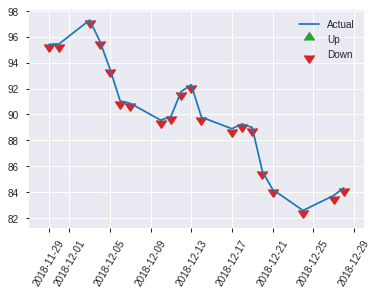


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5298804780876494
RMSE: 0.7279288963131285
LogLoss: 18.30142334869768
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.0656557889856
Residual deviance: 185905.25474774328
AIC: 186007.25474774328
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.251747485241255e-77: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    133  0        (0.0/133.0)
Total  0    251  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.25175e-77  0.692708  0
max f2                       2.25175e-77  0.849298  0
max f0point5                 2.25175e-77  0.584872  0
max accuracy                 2.25175e-77  0.52988   0
max precision                2.25175e-77  0.52988   0
max recall                   2.25175e-77  1         0
max specificity              2.25175e-77  0         0
max absolute_mcc             2.25175e-77  0         0
max min_per_class_accuracy   2.25175e-77  0         0
max mean_per_class_accuracy  2.25175e-77  0.5       0

Gains/Lift Table: Avg response rate: 52.99 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   6.27685e-182       1.88722   1.88722            1                1.88396e-75  1                           1.88396e-75         0.0225564       0.0225564                  88.7218   88.7218
    2        1                           0                  0.989268  1                  0.524194         0            0.52988                     2.25175e-77         0.977444        1                          -1.07325  0

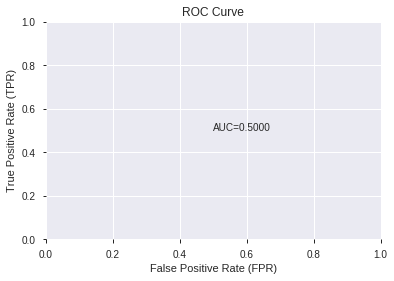

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


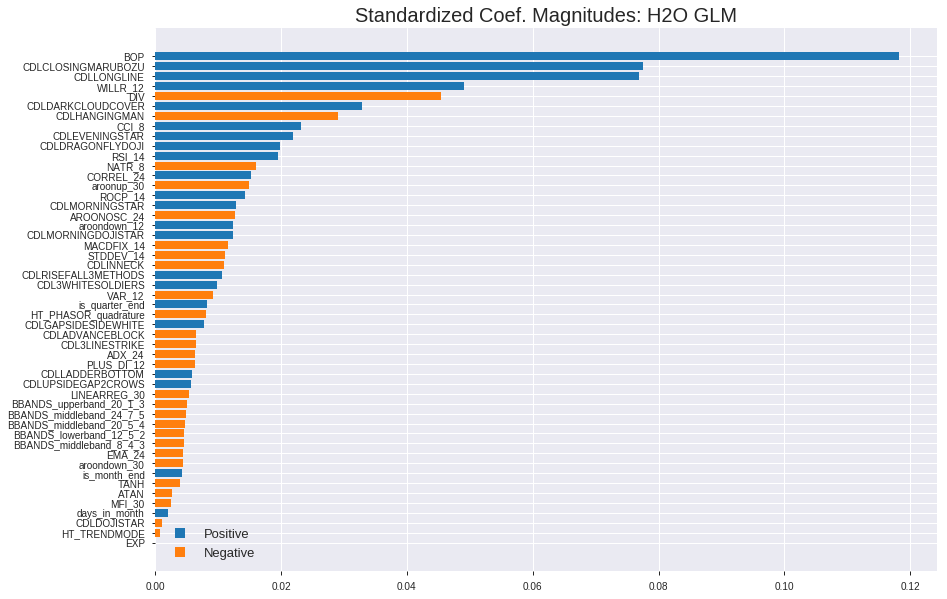

'log_likelihood'
--2019-08-27 14:06:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_140637_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_140637_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'WILLR_12',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CCI_8',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'RSI_14',
 'NATR_8',
 'CORREL_24',
 'aroonup_30',
 'ROCP_14',
 'CDLMORNINGSTAR',
 'AROONOSC_24',
 'aroondown_12',
 'CDLMORNINGDOJISTAR',
 'MACDFIX_14',
 'STDDEV_14',
 'CDLINNECK',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'VAR_12',
 'is_quarter_end',
 'HT_PHASOR_quadrature',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'ADX_24',
 'PLUS_DI_12',
 'CDLLADDERBOTTOM',
 'CDLUPSIDEGAP2CROWS',
 'LINEARREG_30',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_24_7_5',
 'BBANDS_middleband_20_5_4',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_middleband_8_4_3',
 'EMA_24',
 'aroondown_30',
 'is_month_end',
 'TANH',
 'ATAN',
 'MFI_30',
 'days_in_month',
 'CDLDOJISTAR',
 'HT_TRENDMODE',
 'EXP']

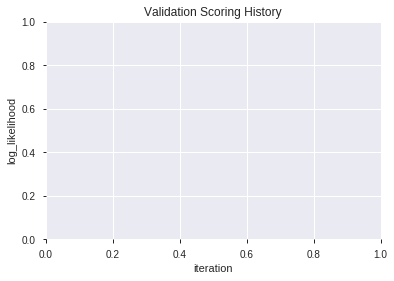

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_140653_model_4  0.729260  0.611536              0.328947  0.460090  0.211683
1               XGBoost_3_AutoML_20190827_140653  0.721167  0.637193              0.356761  0.472004  0.222788
2               XGBoost_2_AutoML_20190827_140653  0.711864  0.640201              0.357238  0.472724  0.223468
3  XGBoost_grid_1_AutoML_20190827_140653_model_5  0.707340  0.652016              0.345897  0.478390  0.228857
4  XGBoost_grid_1_AutoML_20190827_140653_model_7  0.702816  0.636807              0.404390  0.471945  0.222732
5  XGBoost_grid_1_AutoML_20190827_140653_model_3  0.701096  0.638374              0.379381  0.472437  0.223196
6  XGBoost_grid_1_AutoML_20190827_140653_model_1  0.698898  0.643457              0.378903  0.475976  0.226553
7  XGBoost_grid_1_AutoML_20190827_140653_model_2  0.696317  0.636582              0.359150  0.472516  0.223272
8  XGBoost_grid_1_AutoML_20190827_140653_model_6  0.694724  0.648668              0.357716  0.478230  0.228704
9               XGBoost_1_AutoML_20190827_140653  0.691220  0.643426              0.349656  0.474691  0.225331

variable  relative_importance  scaled_importance  percentage
0                        BOP          2255.374512           1.000000    0.470667
1                        DIV           418.386353           0.185506    0.087312
2                   WILLR_12           245.725174           0.108951    0.051280
3       HT_PHASOR_quadrature           149.721909           0.066384    0.031245
4                      CCI_8           147.600906           0.065444    0.030802
5         CDLCLOSINGMARUBOZU           136.216095           0.060396    0.028426
6               aroondown_12           127.392975           0.056484    0.026585
7                 PLUS_DI_12           123.587265           0.054797    0.025791
8                  CORREL_24           115.765602           0.051329    0.024159
9                 aroonup_30            84.468475           0.037452    0.017627
10                   ROCP_14            82.426414           0.036547    0.017201
11                MACDFIX_14            80.405594           0.035651    0.016780
12               AROONOSC_24            78.843201           0.034958    0.016454
13                    NATR_8            67.272438           0.029828    0.014039
14                    ADX_24            66.167130           0.029338    0.013808
15   BBANDS_middleband_8_4_3            60.406429           0.026783    0.012606
16                    MFI_30            59.437187           0.026354    0.012404
17              aroondown_30            58.717693           0.026035    0.012254
18              LINEARREG_30            56.189571           0.024914    0.011726
19                 STDDEV_14            52.800114           0.023411    0.011019
20                    VAR_12            52.578457           0.023313    0.010972
21  BBANDS_middleband_20_5_4            51.063774           0.022641    0.010656
22                    RSI_14            39.136528           0.017353    0.008167
23   BBANDS_upperband_20_1_3            37.436790           0.016599    0.007813
24               CDLLONGLINE            36.095856           0.016004    0.007533
25   BBANDS_lowerband_12_5_2            34.191208           0.015160    0.007135
26  BBANDS_middleband_24_7_5            31.767490           0.014085    0.006629
27             days_in_month            16.193748           0.007180    0.003379
28                      ATAN            16.117188           0.007146    0.003363
29                    EMA_24            10.384157           0.004604    0.002167

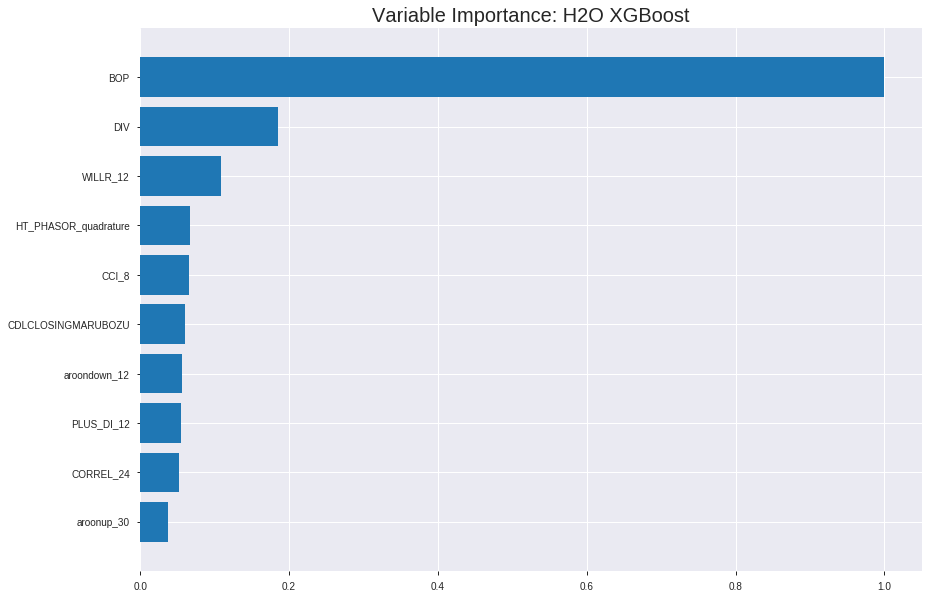

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_140653_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17930841531589994
RMSE: 0.42344824396365127
LogLoss: 0.538461265002119
Mean Per-Class Error: 0.2576534143290302
AUC: 0.8163448254248488
pr_auc: 0.8272666707024051
Gini: 0.6326896508496975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43579696615537006: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      465  362   0.4377   (362.0/827.0)
1      115  811   0.1242   (115.0/926.0)
Total  580  1173  0.2721   (477.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435797     0.772749  245
max f2                       0.189808     0.864804  361
max f0point5                 0.59757      0.765379  159
max accuracy                 0.548173     0.743297  187
max precision                0.874401     1         0
max recall                   0.160319     1         377
max specificity              0.874401     1         0
max absolute_mcc             0.548173     0.484824  187
max min_per_class_accuracy   0.562385     0.739741  179
max mean_per_class_accuracy  0.548173     0.742347  187

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.84956            1.89309   1.89309            1                0.861044  1                           0.861044            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.835583           1.89309   1.89309            1                0.842655  1                           0.851849            0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.827345           1.89309   1.89309            1                0.830391  1                           0.844966            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.819631           1.68275   1.83976            0.888889         0.823385  0.971831                    0.839495            0.0172786       0.074514                   68.2745   83.9762
    5        0.0501997                   0.810461           1.89309   1.85006            1                0.814016  0.977273                    0.834573            0.0183585       0.0928726                  89.3089   85.0064
    6        0.100399                    0.777997           1.7425    1.79628            0.920455         0.793662  0.948864                    0.814118            0.087473        0.180346                   74.2502   79.6283
    7        0.150029                    0.747792           1.56669   1.72034            0.827586         0.76266   0.908745                    0.797095            0.0777538       0.258099                   56.6694   72.0335
    8        0.200228                    0.723251           1.63494   1.69893            0.863636         0.735498  0.897436                    0.781652            0.0820734       0.340173                   63.494    69.8926
    9        0.300057                    0.680715           1.41711   1.60517            0.748571         0.70145   0.847909                    0.754969            0.141469        0.481641                   41.7112   60.5166
    10       0.399886                    0.636829           1.29812   1.52851            0.685714         0.659782  0.807418                    0.731206            0.12959         0.611231                   29.8118   52.8514
    11       0.500285                    0.570598           1.11864   1.44626            0.590909         0.604574  0.763968                    0.705793            0.112311        0.723542                   11.8643   44.6259
    12       0.600114                    0.49834            0.962771  1.36583            0.508571         0.534803  0.721483                    0.677349            0.0961123       0.819654                   -3.72293  36.5831
    13       0.699943                    0.398861           0.69233   1.26977            0.365714         0.45271   0.670742                    0.64531             0.0691145       0.888769                   -30.767   26.9773
    14       0.799772                    0.294192           0.584153  1.18419            0.308571         0.347294  0.625535                    0.608111            0.0583153       0.947084                   -41.5847  18.4193
    15       0.899601                    0.198631           0.389435  1.096              0.205714         0.247789  0.578947                    0.568126            0.0388769       0.985961                   -61.0565  9.59986
    16       1                           0.114168           0.13983   1                  0.0738636        0.159442  0.528237                    0.527094         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2100064120480594
RMSE: 0.4582645655601788
LogLoss: 0.6083445518327766
Mean Per-Class Error: 0.3030641914560501
AUC: 0.7427788605936672
pr_auc: 0.7429963762923265
Gini: 0.4855577211873343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3627324104309082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   160  0.6723   (160.0/238.0)
1      22   241  0.0837   (22.0/263.0)
Total  100  401  0.3633   (182.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362732     0.725904  315
max f2                       0.248102     0.854785  366
max f0point5                 0.614806     0.727449  145
max accuracy                 0.614806     0.690619  145
max precision                0.800906     1         0
max recall                   0.166196     1         395
max specificity              0.800906     1         0
max absolute_mcc             0.614806     0.404568  145
max min_per_class_accuracy   0.564403     0.684411  193
max mean_per_class_accuracy  0.614806     0.696936  145

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 52.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.778569           1.26996   1.26996            0.666667         0.788091  0.666667                    0.788091            0.0152091       0.0152091                  26.9962   26.9962
    2        0.0219561                   0.755024           1.52395   1.38541            0.8              0.761973  0.727273                    0.776219            0.0152091       0.0304183                  52.3954   38.5413
    3        0.0319361                   0.749667           1.90494   1.54777            1                0.751313  0.8125                      0.768436            0.0190114       0.0494297                  90.4943   54.7766
    4        0.0419162                   0.744902           1.90494   1.63281            1                0.747015  0.857143                    0.763336            0.0190114       0.0684411                  90.4943   63.2808
    5        0.0518962                   0.734594           1.90494   1.68514            1                0.739604  0.884615                    0.758772            0.0190114       0.0874525                  90.4943   68.5142
    6        0.101796                    0.713603           1.60015   1.64348            0.84             0.722955  0.862745                    0.741215            0.0798479       0.1673                     60.0152   64.348
    7        0.151697                    0.687418           1.29536   1.52897            0.68             0.700273  0.802632                    0.727747            0.0646388       0.231939                   29.5361   52.8967
    8        0.201597                    0.669792           1.60015   1.54659            0.84             0.679044  0.811881                    0.715692            0.0798479       0.311787                   60.0152   54.6587
    9        0.301397                    0.637975           1.48586   1.52648            0.78             0.655012  0.801325                    0.695599            0.148289        0.460076                   48.5856   52.6477
    10       0.401198                    0.608471           1.25726   1.45951            0.66             0.623323  0.766169                    0.67762             0.125475        0.585551                   25.7262   45.9509
    11       0.500998                    0.567707           0.876274  1.34333            0.46             0.590334  0.705179                    0.660232            0.0874525       0.673004                   -12.3726  34.3326
    12       0.600798                    0.524108           0.800076  1.25309            0.42             0.546572  0.657807                    0.641352            0.0798479       0.752852                   -19.9924  25.3085
    13       0.700599                    0.463668           0.838175  1.19398            0.44             0.495928  0.626781                    0.620636            0.0836502       0.836502                   -16.1825  19.3981
    14       0.800399                    0.362732           0.800076  1.14487            0.42             0.416729  0.600998                    0.595211            0.0798479       0.91635                    -19.9924  14.4866
    15       0.9002                      0.261486           0.419087  1.0644             0.22             0.315033  0.558758                    0.564149            0.0418251       0.958175                   -58.0913  6.44027
    16       1                           0.130851           0.419087  1                  0.22             0.205923  0.52495                     0.528398          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:07:02  3.482 sec   0                  0.5              0.693147            0.5             0                  1                0.471763                         0.5                0.693147              0.5               0                    1                  0.47505
    2019-08-27 14:07:02  3.697 sec   5                  0.479208         0.652215            0.775204        0.778404           1.89309          0.312037                         0.487504           0.668383              0.717585          0.71031              1.58745            0.37525
    2019-08-27 14:07:02  3.760 sec   10                 0.464872         0.624222            0.78207         0.79161            1.89309          0.317171                         0.479233           0.652033              0.733289          0.726132             1.36067            0.363273
    2019-08-27 14:07:03  3.828 sec   15                 0.454887         0.604486            0.790375        0.80208            1.89309          0.308043                         0.472581           0.638766              0.742563          0.739026             1.36067            0.361277
    2019-08-27 14:07:03  3.898 sec   20                 0.447955         0.590382            0.793215        0.804874           1.89309          0.288078                         0.468109           0.629678              0.745487          0.744944             1.58745            0.367265
    2019-08-27 14:07:03  3.971 sec   25                 0.442742         0.579576            0.795803        0.811954           1.89309          0.310325                         0.465873           0.625041              0.745239          0.746833             1.90494            0.341317
    2019-08-27 14:07:03  4.046 sec   30                 0.438409         0.570623            0.799667        0.814127           1.89309          0.286366                         0.463744           0.620512              0.745862          0.747413             1.90494            0.365269
    2019-08-27 14:07:03  4.123 sec   35                 0.435266         0.563793            0.80203         0.816131           1.89309          0.279521                         0.462037           0.6168                0.747875          0.752493             1.58745            0.359281
    2019-08-27 14:07:03  4.197 sec   40                 0.432758         0.558291            0.804696        0.818464           1.89309          0.281232                         0.461157           0.614806              0.747636          0.751057             1.58745            0.359281
    2019-08-27 14:07:03  4.276 sec   45                 0.429994         0.552406            0.807427        0.819787           1.89309          0.281232                         0.460838           0.613946              0.742619          0.741787             1.58745            0.359281
    2019-08-27 14:07:03  4.349 sec   50                 0.427652         0.547376            0.810727        0.824903           1.89309          0.277239                         0.459713           0.611549              0.742308          0.738668             1.58745            0.359281
    2019-08-27 14:07:03  4.428 sec   55                 0.42557          0.542837            0.813022        0.824379           1.89309          0.277809                         0.458585           0.60911               0.742923          0.7

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       2255.37451171875       1.0                   0.4706668590344071
DIV                       418.3863525390625      0.18550637615400886   0.08731170339526258
WILLR_12                  245.7251739501953      0.10895094037527979   0.051279596895277904
HT_PHASOR_quadrature      149.72190856933594     0.06638449968791994   0.031244983956683854
CCI_8                     147.6009063720703      0.06544407840256575   0.030802358824137097
---                       ---                    ---                   ---
BBANDS_lowerband_12_5_2   34.19120788574219      0.015159880413690648  0.0071352532976490055
BBANDS_middleband_24_7_5  31.76749038696289      0.014085239600741026  0.006629455481627825
days_in_month             16.193748474121094     0.007180070711085737  0.003379421329231666
ATAN                      16.1171875             0.007146124697364606  0.0033634440655768024
EMA_24                    10.384157180786133     0.004604183086591988  0.0021670363917855925


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7368421052631579)

('auc', 0.7292595896520964)

('logloss', 0.6115359249224732)

('mean_per_class_error', 0.32117369695425)

('rmse', 0.4600904550614008)

('mse', 0.21168322683860685)

xgboost prediction progress: |████████████████████████████████████████████| 100%


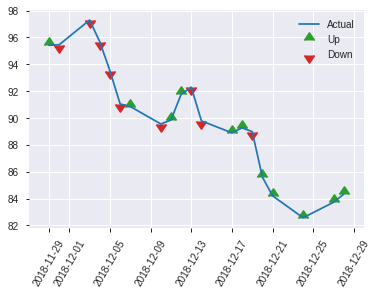


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21168322683860685
RMSE: 0.4600904550614008
LogLoss: 0.6115359249224732
Mean Per-Class Error: 0.32117369695425
AUC: 0.7292595896520964
pr_auc: 0.7371532574560972
Gini: 0.4585191793041927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40361878275871277: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   59   0.5      (59.0/118.0)
1      21   112  0.1579   (21.0/133.0)
Total  80   171  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403619     0.736842  170
max f2                       0.175472     0.862516  238
max f0point5                 0.560076     0.705244  104
max accuracy                 0.403619     0.681275  170
max precision                0.810809     1         0
max recall                   0.175472     1         238
max specificity              0.810809     1         0
max absolute_mcc             0.403619     0.366424  170
max min_per_class_accuracy   0.516872     0.661654  125
max mean_per_class_accuracy  0.560076     0.678826  104

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772022           1.88722   1.88722            1                0.787277  1                           0.787277            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.754541           1.88722   1.88722            1                0.76194   1                           0.774608            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.745824           1.88722   1.88722            1                0.753159  1                           0.769246            0.0150376       0.0601504                  88.7218   88.7218
    4        0.0438247                   0.73229            1.88722   1.88722            1                0.736522  1                           0.760321            0.0225564       0.0827068                  88.7218   88.7218
    5        0.0517928                   0.730281           0.943609  1.74205            0.5              0.731081  0.923077                    0.755823            0.0075188       0.0902256                  -5.6391   74.2047
    6        0.103586                    0.67608            1.45171   1.59688            0.769231         0.700918  0.846154                    0.72837             0.075188        0.165414                   45.1706   59.6877
    7        0.151394                    0.646507           1.25815   1.48991            0.666667         0.654547  0.789474                    0.705058            0.0601504       0.225564                   25.8145   48.9909
    8        0.203187                    0.636253           1.45171   1.48017            0.769231         0.641535  0.784314                    0.688866            0.075188        0.300752                   45.1706   48.0171
    9        0.302789                    0.605958           1.13233   1.36575            0.6              0.620145  0.723684                    0.66626             0.112782        0.413534                   13.2331   36.575
    10       0.40239                     0.563373           1.43429   1.38271            0.76             0.586816  0.732673                    0.646596            0.142857        0.556391                   43.4286   38.2714
    11       0.501992                    0.516872           1.05684   1.31806            0.56             0.543268  0.698413                    0.626094            0.105263        0.661654                   5.68421   31.8057
    12       0.601594                    0.44782            0.905865  1.24981            0.48             0.487526  0.662252                    0.603153            0.0902256       0.75188                    -9.41353  24.9813
    13       0.701195                    0.388228           0.905865  1.20096            0.48             0.420589  0.636364                    0.57722             0.0902256       0.842105                   -9.41353  20.0957
    14       0.800797                    0.307632           0.754887  1.14548            0.4              0.352765  0.606965                    0.549303            0.075188        0.917293                   -24.5113  14.5476
    15       0.900398                    0.21233            0.528421  1.07722            0.28             0.263282  0.570796                    0.517663            0.0526316       0.969925                   -47.1579  7.72174
    16       1                           0.115341           0.301955  1                  0.16             0.171492  0.52988                     0.483184          

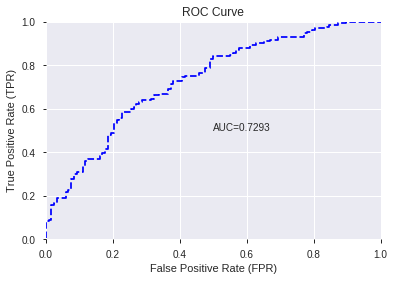

This function is available for GLM models only


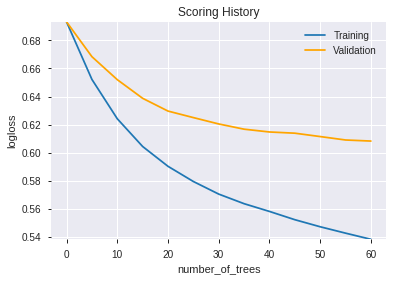

--2019-08-27 14:07:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_140653_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_140653_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'WILLR_12',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'PLUS_DI_12',
 'CORREL_24',
 'aroonup_30',
 'ROCP_14',
 'MACDFIX_14',
 'AROONOSC_24',
 'NATR_8',
 'ADX_24',
 'BBANDS_middleband_8_4_3',
 'MFI_30',
 'aroondown_30',
 'LINEARREG_30',
 'STDDEV_14',
 'VAR_12',
 'BBANDS_middleband_20_5_4',
 'RSI_14',
 'BBANDS_upperband_20_1_3',
 'CDLLONGLINE',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_middleband_24_7_5',
 'days_in_month',
 'ATAN',
 'EMA_24']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

40

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLENGULFING',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_140725_model_5  0.725436  0.668352              0.342615  0.474939  0.225567
1               DeepLearning_1_AutoML_20190827_140725  0.725054  0.668229              0.371862  0.483521  0.233792
2  DeepLearning_grid_1_AutoML_20190827_140725_model_6  0.724927  0.620532              0.354371  0.462755  0.214143
3  DeepLearning_grid_1_AutoML_20190827_140725_model_9  0.723270  0.621379              0.364757  0.463674  0.214994
4  DeepLearning_grid_1_AutoML_20190827_140725_model_4  0.721996  0.665225              0.315694  0.471263  0.222089
5  DeepLearning_grid_1_AutoML_20190827_140725_model_2  0.720721  0.722466              0.384574  0.482640  0.232942
6  DeepLearning_grid_1_AutoML_20190827_140725_model_8  0.718682  0.641382              0.356283  0.468998  0.219959
7  DeepLearning_grid_1_AutoML_20190827_140725_model_7  0.718619  0.658188              0.353001  0.470780  0.221633
8  DeepLearning_grid_1_AutoML_20190827_140725_model_3  0.691092  0.713145              0.353893  0.487673  0.237825
9  DeepLearning_grid_1_AutoML_20190827_140725_model_1  0.663566  0.954212              0.473143  0.516720  0.267000

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.047945
1   CDLCLOSINGMARUBOZU             0.759969           0.759969    0.036437
2                  DIV             0.659485           0.659485    0.031619
3       STOCHRSI_fastk             0.597385           0.597385    0.028642
4                CCI_8             0.590629           0.590629    0.028318
5    CDLDARKCLOUDCOVER             0.582293           0.582293    0.027918
6               TRANGE             0.570331           0.570331    0.027345
7         CDLENGULFING             0.552221           0.552221    0.026476
8              CDLDOJI             0.548602           0.548602    0.026303
9              WILLR_8             0.547544           0.547544    0.026252
10            WILLR_12             0.544486           0.544486    0.026106
11         CDLLONGLINE             0.544200           0.544200    0.026092
12                 SUB             0.543348           0.543348    0.026051
13         CDLBELTHOLD             0.535367           0.535367    0.025668
14        STOCHF_fastk             0.535262           0.535262    0.025663
15   CDLLONGLEGGEDDOJI             0.534843           0.534843    0.025643
16            WILLR_14             0.517460           0.517460    0.024810
17              ULTOSC             0.509459           0.509459    0.024426
18        CDLSHORTLINE             0.500592           0.500592    0.024001
19              CCI_12             0.499779           0.499779    0.023962
20             ROCP_12             0.484675           0.484675    0.023238
21            WILLR_24             0.483667           0.483667    0.023190
22              CMO_14             0.479836           0.479836    0.023006
23             ROCR_12             0.472324           0.472324    0.022646
24              ROC_12             0.469125           0.469125    0.022492
25              RSI_14             0.468249           0.468249    0.022450
26              ROCR_8             0.465268           0.465268    0.022307
27            WILLR_30             0.463224           0.463224    0.022209
28              ROCP_8             0.460424           0.460424    0.022075
29               ROC_8             0.459228           0.459228    0.022018
30         CDLMARUBOZU             0.456657           0.456657    0.021895
31              CCI_14             0.452951           0.452951    0.021717
32               CMO_8             0.451809           0.451809    0.021662
33           ROCR100_8             0.451292           0.451292    0.021637
34              RSI_12             0.450848           0.450848    0.021616
35               MOM_8             0.446319           0.446319    0.021399
36          ROCR100_12             0.443583           0.443583    0.021268
37              CMO_12             0.442595           0.442595    0.021220
38            WILLR_20             0.441238           0.441238    0.021155
39               RSI_8             0.440533           0.440533    0.021121

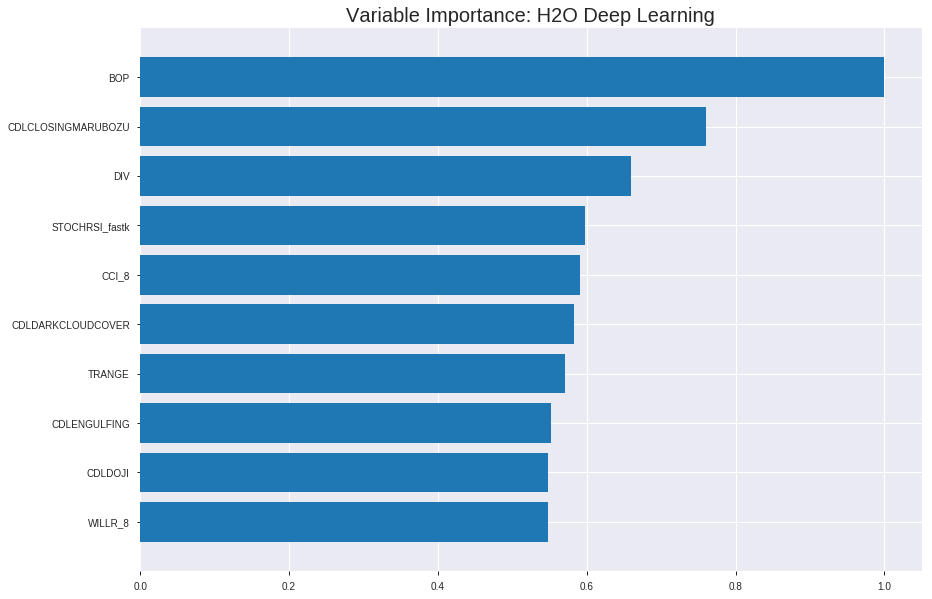

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_140725_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19487174826276815
RMSE: 0.4414428029346137
LogLoss: 0.5693287585145176
Mean Per-Class Error: 0.29722957109017734
AUC: 0.7687156732419085
pr_auc: 0.7696844187784014
Gini: 0.537431346483817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40296226521037404: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      455  372   0.4498   (372.0/827.0)
1      144  782   0.1555   (144.0/926.0)
Total  599  1154  0.2944   (516.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402962     0.751923  247
max f2                       0.122748     0.867667  352
max f0point5                 0.55131      0.721438  189
max accuracy                 0.463977     0.707359  221
max precision                0.989866     1         0
max recall                   0.0513696    1         380
max specificity              0.989866     1         0
max absolute_mcc             0.402962     0.415413  247
max min_per_class_accuracy   0.537451     0.699784  194
max mean_per_class_accuracy  0.463977     0.70277   221

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.967684           1.89309   1.89309            1                0.976997   1                           0.976997            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.948531           1.78792   1.8405             0.944444         0.959354   0.972222                    0.968175            0.0183585       0.037797                   78.7917   84.0503
    3        0.0302339                   0.932528           1.67037   1.78593            0.882353         0.940082   0.943396                    0.959164            0.0161987       0.0539957                  67.0372   78.5933
    4        0.040502                    0.915254           1.57757   1.73311            0.833333         0.922939   0.915493                    0.94998             0.0161987       0.0701944                  57.7574   73.3109
    5        0.0501997                   0.900675           1.55901   1.69948            0.823529         0.907876   0.897727                    0.941847            0.0151188       0.0853132                  55.9014   69.9477
    6        0.100399                    0.830251           1.59192   1.6457             0.840909         0.863909   0.869318                    0.902878            0.0799136       0.165227                   59.1915   64.5696
    7        0.150029                    0.768714           1.47966   1.59077            0.781609         0.800114   0.840304                    0.868884            0.0734341       0.238661                   47.9655   59.077
    8        0.200228                    0.728578           1.41982   1.54791            0.75             0.748373   0.817664                    0.83867             0.0712743       0.309935                   41.9816   54.791
    9        0.300057                    0.658934           1.36302   1.4864             0.72             0.690771   0.785171                    0.789464            0.136069        0.446004                   36.3024   48.6398
    10       0.399886                    0.602761           1.16831   1.40699            0.617143         0.630407   0.743224                    0.749757            0.116631        0.562635                   16.8306   40.6989
    11       0.500285                    0.544705           1.24772   1.37503            0.659091         0.575025   0.72634                     0.714691            0.12527         0.687905                   24.7717   37.5026
    12       0.600114                    0.453582           1.00604   1.31365            0.531429         0.501524   0.693916                    0.679231            0.100432        0.788337                   0.604135  31.3645
    13       0.699943                    0.362543           0.832959  1.24509            0.44             0.409216   0.657702                    0.64072             0.0831533       0.87149                    -16.7041  24.5088
    14       0.799772                    0.250052           0.638241  1.16934            0.337143         0.311316   0.617689                    0.599603            0.0637149       0.935205                   -36.1759  16.934
    15       0.899601                    0.114424           0.530065  1.0984             0.28             0.180777   0.580216                    0.553126            0.0529158       0.988121                   -46.9935  9.83995
    16       1                           0.00637416         0.118318  1                  0.0625           0.0601615  0.528237                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2042551447045584
RMSE: 0.45194595330034587
LogLoss: 0.5955909439071375
Mean Per-Class Error: 0.3244799821069112
AUC: 0.7446640253059399
pr_auc: 0.7458024070876227
Gini: 0.4893280506118798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23257783004450852: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      66   172  0.7227   (172.0/238.0)
1      8    255  0.0304   (8.0/263.0)
Total  74   427  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232578     0.73913   338
max f2                       0.170554     0.866667  355
max f0point5                 0.642542     0.70658   126
max accuracy                 0.430388     0.676647  255
max precision                0.967971     1         0
max recall                   0.0167193    1         397
max specificity              0.967971     1         0
max absolute_mcc             0.642542     0.372432  126
max min_per_class_accuracy   0.556534     0.669202  190
max mean_per_class_accuracy  0.642542     0.67552   126

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.943567           1.90494   1.90494            1                0.9581     1                           0.9581              0.0228137       0.0228137                  90.4943   90.4943
    2        0.0219561                   0.930279           1.52395   1.73177            0.8              0.93258    0.909091                    0.9465              0.0152091       0.0380228                  52.3954   73.1766
    3        0.0319361                   0.908142           1.52395   1.66683            0.8              0.911807   0.875                       0.935658            0.0152091       0.0532319                  52.3954   66.6825
    4        0.0419162                   0.872734           1.52395   1.63281            0.8              0.888766   0.857143                    0.924494            0.0152091       0.0684411                  52.3954   63.2808
    5        0.0518962                   0.859333           1.14297   1.53861            0.6              0.866273   0.807692                    0.913297            0.0114068       0.0798479                  14.2966   53.8608
    6        0.101796                    0.794226           1.75255   1.64348            0.92             0.831115   0.862745                    0.873012            0.0874525       0.1673                     75.2548   64.348
    7        0.151697                    0.730219           1.52395   1.60416            0.8              0.765098   0.842105                    0.837514            0.0760456       0.243346                   52.3954   60.4162
    8        0.201597                    0.70645            1.44776   1.56545            0.76             0.71649    0.821782                    0.807557            0.0722433       0.315589                   44.7757   56.5448
    9        0.301397                    0.652383           1.37156   1.50125            0.72             0.678808   0.788079                    0.764925            0.136882        0.452471                   37.1559   50.1246
    10       0.401198                    0.610361           1.02867   1.38369            0.54             0.630547   0.726368                    0.731498            0.102662        0.555133                   2.86692   38.369
    11       0.500998                    0.558695           1.06677   1.32056            0.56             0.585196   0.693227                    0.702354            0.106464        0.661597                   6.67681   32.0558
    12       0.600798                    0.483507           0.952471  1.25941            0.5              0.521485   0.66113                     0.672309            0.095057        0.756654                   -4.75285  25.9414
    13       0.700599                    0.40768            0.876274  1.20484            0.46             0.444662   0.632479                    0.639881            0.0874525       0.844106                   -12.3726  20.4836
    14       0.800399                    0.310386           0.723878  1.14487            0.38             0.361234   0.600998                    0.605137            0.0722433       0.91635                    -27.6122  14.4866
    15       0.9002                      0.158351           0.723878  1.09819            0.38             0.23435    0.576497                    0.56403             0.0722433       0.988593                   -27.6122  9.81933
    16       1                           0.00354952         0.114297  1                  0.06             0.0828651  0.52495                     0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:11:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:11:41  1 min 42.231 sec  1297 obs/sec      0.998859  1             1751       0.465514         0.621171            0.130413       0.732211        0.739658           1.78792          0.358243                         0.486111           0.668174              0.0524232        0.695953          0.713508             1.90494            0.369261
    2019-08-27 14:11:47  1 min 48.194 sec  2332 obs/sec      8.9846    9             15750      0.441443         0.569329            0.218019       0.768716        0.769684           1.89309          0.294353                         0.451946           0.595591              0.18094          0.744664          0.745802             1.90494            0.359281
    2019-08-27 14:11:53  1 min 53.839 sec  2654 obs/sec      17.9663   18            31495      0.439514         0.56399             0.224838       0.772647        0.781711           1.89309          0.32972                          0.460941           0.615142              0.148013         0.721587          0.719119             1.58745            0.373253
    2019-08-27 14:11:58  1 min 59.218 sec  2829 obs/sec      26.9515   27            47246      0.437896         0.558904            0.230533       0.772168        0.784718           1.89309          0.326298                         0.463887           0.622806              0.137085         0.712472          0.706852             1.58745            0.371257
    2019-08-27 14:12:04  2 min  4.973 sec  2952 obs/sec      36.9321   37            64742      0.430898         0.546504            0.254933       0.797091        0.808777           1.89309          0.284655                         0.463361           0.621155              0.139042         0.70875           0.696891             1.26996            0.365269
    2019-08-27 14:12:09  2 min 10.762 sec  3026 obs/sec      46.9156   47            82243      0.424271         0.529644            0.277672       0.803498        0.819202           1.89309          0.282944                         0.462147           0.625751              0.143547         0.721475          0.699215             1.26996            0.361277
    2019-08-27 14:12:15  2 min 16.458 sec  3084 obs/sec      56.8985   57            99743      0.420709         0.522616            0.28975        0.814827        0.828399           1.89309          0.289218                         0.467174           0.640895              0.124814         0.717529          0.68769              1.26996            0.363273
    2019-08-27 14:12:16  2 min 17.020 sec  3082 obs/sec      56.8985   57            99743      0.441443         0.569329            0.218019       0.768716        0.769684           1.89309          0.294353                         0.451946           0.595591              0.18094          0.744664          0.745802             1.90494            0.359281

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04794531233239665
CDLCLOSINGMARUBOZU  0.7599689960479736     0.7599689960479736   0.03643695087845801
DIV                 0.6594850420951843     0.6594850420951843   0.031619216321797365
STOCHRSI_fastk      0.5973854064941406     0.5973854064941406   0.028641829897177305
CCI_8               0.5906285047531128     0.5906285047531128   0.02831786813280441
---                 ---                    ---                  ---
MOM_8               0.4463188052177429     0.4463188052177429   0.021398894515986786
ROCR100_12          0.443582683801651      0.443582683801651    0.0212677103201129
CMO_12              0.44259461760520935    0.44259461760520935  0.02122033717771942
WILLR_20            0.441238135099411      0.441238135099411    0.02115530020030549
RSI_8               0.440532922744751      0.440532922744751    0.021121488573700647


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7331189710610932)

('auc', 0.7254364725372754)

('logloss', 0.668351816282337)

('mean_per_class_error', 0.3108512807442334)

('rmse', 0.47493868928930527)

('mse', 0.22556675858384323)

deeplearning prediction progress: |███████████████████████████████████████| 100%


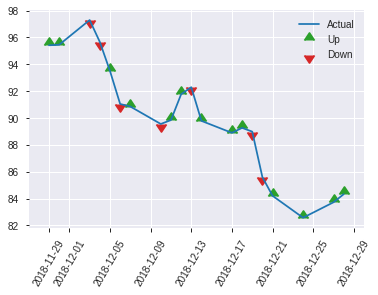


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22556675858384323
RMSE: 0.47493868928930527
LogLoss: 0.668351816282337
Mean Per-Class Error: 0.3108512807442334
AUC: 0.7254364725372754
pr_auc: 0.73722904354659
Gini: 0.4508729450745508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2578872656759993: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   64   0.5424   (64.0/118.0)
1      19   114  0.1429   (19.0/133.0)
Total  73   178  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257887     0.733119  177
max f2                       0.0152563    0.852564  247
max f0point5                 0.498465     0.714286  111
max accuracy                 0.358872     0.689243  150
max precision                0.94541      1         0
max recall                   0.0152563    1         247
max specificity              0.94541      1         0
max absolute_mcc             0.498465     0.379825  111
max min_per_class_accuracy   0.434623     0.669492  128
max mean_per_class_accuracy  0.498465     0.689149  111

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 41.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.925681           1.88722   1.88722            1                0.940036   1                           0.940036            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.912554           1.88722   1.88722            1                0.915554   1                           0.927795            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.848207           1.88722   1.88722            1                0.861053   1                           0.911109            0.0150376       0.0601504                  88.7218   88.7218
    4        0.0438247                   0.818775           1.25815   1.71565            0.666667         0.831618   0.909091                    0.88943             0.0150376       0.075188                   25.8145   71.5653
    5        0.0517928                   0.781122           1.88722   1.74205            1                0.78422    0.923077                    0.873244            0.0150376       0.0902256                  88.7218   74.2047
    6        0.103586                    0.720538           1.45171   1.59688            0.769231         0.744964   0.846154                    0.809104            0.075188        0.165414                   45.1706   59.6877
    7        0.151394                    0.665676           1.25815   1.48991            0.666667         0.692756   0.789474                    0.772363            0.0601504       0.225564                   25.8145   48.9909
    8        0.203187                    0.631648           1.45171   1.48017            0.769231         0.644885   0.784314                    0.739868            0.075188        0.300752                   45.1706   48.0171
    9        0.302789                    0.572202           1.3588    1.44025            0.72             0.597704   0.763158                    0.693104            0.135338        0.43609                    35.8797   44.0245
    10       0.40239                     0.512295           1.13233   1.36403            0.6              0.542888   0.722772                    0.655921            0.112782        0.548872                   13.2331   36.4029
    11       0.501992                    0.441954           1.13233   1.31806            0.6              0.481955   0.698413                    0.621404            0.112782        0.661654                   13.2331   31.8057
    12       0.601594                    0.358872           1.13233   1.28731            0.6              0.407226   0.682119                    0.585944            0.112782        0.774436                   13.2331   28.7308
    13       0.701195                    0.26049            0.754887  1.21168            0.4              0.304669   0.642045                    0.54599             0.075188        0.849624                   -24.5113  21.168
    14       0.800797                    0.136245           0.452932  1.11731            0.24             0.189272   0.59204                     0.501622            0.0451128       0.894737                   -54.7068  11.7308
    15       0.900398                    0.0755855          0.60391   1.06052            0.32             0.103385   0.561947                    0.45757             0.0601504       0.954887                   -39.609   6.05163
    16       1                           0.0088564          0.452932  1                  0.24             0.0428147  0.52988                     

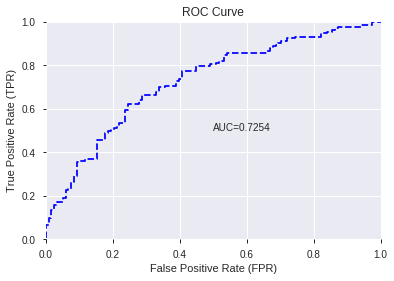

This function is available for GLM models only


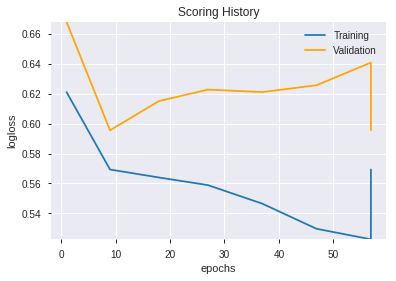

--2019-08-27 14:16:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_140725_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_140725_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCHRSI_fastk',
 'CCI_8',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'CDLENGULFING',
 'CDLDOJI',
 'WILLR_8',
 'WILLR_12',
 'CDLLONGLINE',
 'SUB',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CDLLONGLEGGEDDOJI',
 'WILLR_14',
 'ULTOSC',
 'CDLSHORTLINE',
 'CCI_12',
 'ROCP_12',
 'WILLR_24',
 'CMO_14',
 'ROCR_12',
 'ROC_12',
 'RSI_14',
 'ROCR_8',
 'WILLR_30',
 'ROCP_8',
 'ROC_8',
 'CDLMARUBOZU',
 'CCI_14',
 'CMO_8',
 'ROCR100_8',
 'RSI_12',
 'MOM_8',
 'ROCR100_12',
 'CMO_12',
 'WILLR_20',
 'RSI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_141651_model_1  0.734548  0.621152              0.378489  0.464316  0.215589

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.552650           1.000000    0.144922
1                CCI_8             0.325085           0.588229    0.085247
2             WILLR_12             0.300653           0.544021    0.078840
3             WILLR_14             0.272989           0.493964    0.071586
4   CDLCLOSINGMARUBOZU             0.233112           0.421807    0.061129
5                  DIV             0.206468           0.373596    0.054142
6       STOCHRSI_fastk             0.164179           0.297077    0.043053
7             WILLR_24             0.156497           0.283176    0.041038
8               CCI_12             0.152325           0.275626    0.039944
9    CDLDARKCLOUDCOVER             0.135558           0.245288    0.035547
10                 SUB             0.121614           0.220057    0.031891
11             WILLR_8             0.118112           0.213719    0.030972
12        CDLENGULFING             0.108365           0.196082    0.028417
13              CCI_14             0.089285           0.161558    0.023413
14            WILLR_20             0.086466           0.156458    0.022674
15              TRANGE             0.084752           0.153356    0.022225
16        STOCHF_fastk             0.076214           0.137907    0.019986
17         CDLLONGLINE             0.073305           0.132642    0.019223
18             CDLDOJI             0.072675           0.131503    0.019058
19               CMO_8             0.059082           0.106906    0.015493
20               RSI_8             0.056916           0.102988    0.014925
21         CDLBELTHOLD             0.050720           0.091777    0.013300
22   CDLLONGLEGGEDDOJI             0.045682           0.082661    0.011979
23              CMO_14             0.040731           0.073700    0.010681
24              RSI_14             0.039235           0.070994    0.010289
25               MOM_8             0.023444           0.042422    0.006148
26              ULTOSC             0.021973           0.039759    0.005762
27              RSI_12             0.019320           0.034959    0.005066
28              CMO_12             0.019311           0.034942    0.005064
29         CDLMARUBOZU             0.017840           0.032281    0.004678
30        CDLSHORTLINE             0.014380           0.026020    0.003771
31           ROCR100_8             0.014170           0.025640    0.003716
32               ROC_8             0.014080           0.025477    0.003692
33              ROCR_8             0.013977           0.025291    0.003665
34            WILLR_30             0.013853           0.025067    0.003633
35              ROCP_8             0.013775           0.024925    0.003612
36              ROC_12             0.001441           0.002608    0.000378
37          ROCR100_12             0.001174           0.002124    0.000308
38             ROCR_12             0.001028           0.001860    0.000270
39             ROCP_12             0.001004           0.001817    0.000263

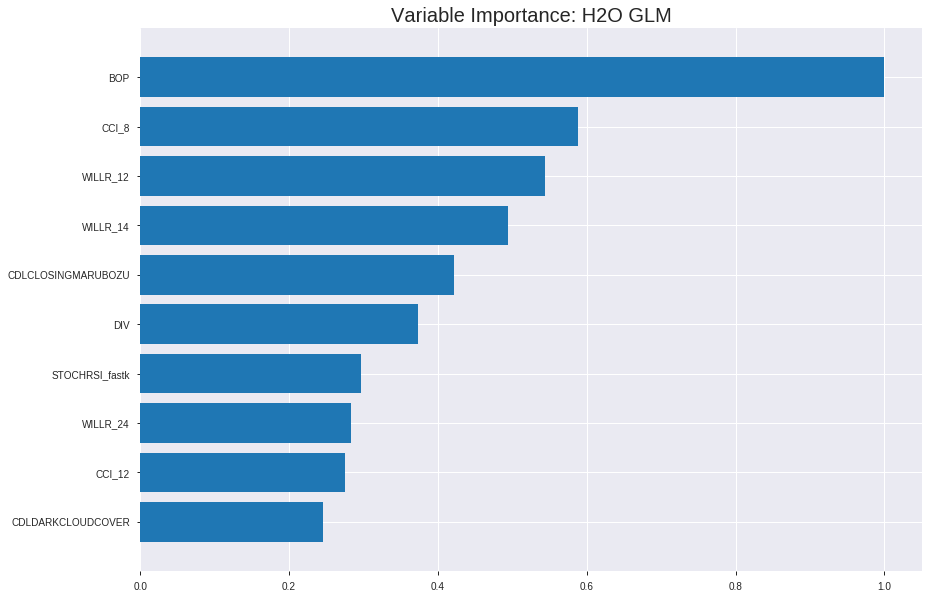

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_141651_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1945441396042815
RMSE: 0.44107158104357785
LogLoss: 0.5713412480159656
Null degrees of freedom: 1752
Residual degrees of freedom: 1712
Null deviance: 2424.5800523999424
Residual deviance: 2003.1224155439756
AIC: 2085.122415543976
AUC: 0.7668059106662035
pr_auc: 0.762948573888368
Gini: 0.533611821332407
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3636873048504756: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      364  463   0.5599   (463.0/827.0)
1      86   840   0.0929   (86.0/926.0)
Total  450  1303  0.3132   (549.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363687     0.753701  276
max f2                       0.185312     0.863696  349
max f0point5                 0.576474     0.730734  177
max accuracy                 0.576474     0.709641  177
max precision                0.957783     1         0
max recall                   0.0830619    1         387
max specificity              0.957783     1         0
max absolute_mcc             0.576474     0.42073   177
max min_per_class_accuracy   0.564518     0.702539  183
max mean_per_class_accuracy  0.576474     0.710683  177

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.910177           1.78792   1.78792            0.944444         0.924059  0.944444                    0.924059            0.0183585       0.0183585                  78.7917   78.7917
    2        0.0205362                   0.892654           1.4724    1.63016            0.777778         0.900436  0.861111                    0.912247            0.0151188       0.0334773                  47.2402   63.016
    3        0.0302339                   0.877026           1.78173   1.67878            0.941176         0.88563   0.886792                    0.90371             0.0172786       0.0507559                  78.173    67.8777
    4        0.040502                    0.868527           1.78792   1.70645            0.944444         0.872599  0.901408                    0.895823            0.0183585       0.0691145                  78.7917   70.6446
    5        0.0501997                   0.856959           1.67037   1.69948            0.882353         0.86415   0.897727                    0.889704            0.0161987       0.0853132                  67.0372   69.9477
    6        0.100399                    0.79901            1.61343   1.65645            0.852273         0.824949  0.875                       0.857326            0.0809935       0.166307                   61.3428   65.6452
    7        0.150029                    0.758491           1.37086   1.56198            0.724138         0.775736  0.825095                    0.830336            0.0680346       0.234341                   37.0857   56.1978
    8        0.200228                    0.726479           1.33377   1.50476            0.704545         0.742451  0.794872                    0.808302            0.0669546       0.301296                   33.3767   50.4763
    9        0.300057                    0.677847           1.34139   1.45041            0.708571         0.701087  0.76616                     0.772632            0.133909        0.435205                   34.1388   45.0408
    10       0.399886                    0.625342           1.34139   1.42319            0.708571         0.652399  0.751783                    0.742617            0.133909        0.569114                   34.1388   42.3192
    11       0.500285                    0.572584           1.27999   1.39445            0.676136         0.599091  0.736602                    0.713813            0.12851         0.697624                   27.9986   39.4453
    12       0.600114                    0.485827           0.854594  1.30465            0.451429         0.531694  0.689163                    0.683518            0.0853132       0.782937                   -14.5406  30.4648
    13       0.699943                    0.397884           0.897865  1.24663            0.474286         0.441147  0.658517                    0.64895             0.0896328       0.87257                    -10.2135  24.663
    14       0.799772                    0.308604           0.627424  1.16934            0.331429         0.356181  0.617689                    0.612406            0.062635        0.935205                   -37.2576  16.934
    15       0.899601                    0.194734           0.465159  1.0912             0.245714         0.251048  0.576411                    0.572306            0.0464363       0.981641                   -53.4841  9.11969
    16       1                           0.0267261          0.182855  1                  0.0965909        0.133371  0.528237                    0.528237            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2053413016516227
RMSE: 0.45314600478391365
LogLoss: 0.5973995400673824
Null degrees of freedom: 500
Residual degrees of freedom: 460
Null deviance: 693.3071704359105
Residual deviance: 598.5943391475172
AIC: 680.5943391475172
AUC: 0.7442007221139406
pr_auc: 0.7411953243175892
Gini: 0.48840144422788123
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2730909072373352: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      59   179  0.7521   (179.0/238.0)
1      6    257  0.0228   (6.0/263.0)
Total  65   436  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273091     0.735336  340
max f2                       0.264875     0.865191  343
max f0point5                 0.670427     0.703218  112
max accuracy                 0.46638      0.680639  255
max precision                0.850147     0.88      21
max recall                   0.066179     1         398
max specificity              0.912453     0.995798  0
max absolute_mcc             0.670427     0.374538  112
max min_per_class_accuracy   0.573369     0.655462  189
max mean_per_class_accuracy  0.527308     0.673643  214

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.894873           1.26996   1.26996            0.666667         0.902845  0.666667                    0.902845            0.0152091       0.0152091                  26.9962    26.9962
    2        0.0219561                   0.881593           1.90494   1.55859            1                0.888126  0.818182                    0.896155            0.0190114       0.0342205                  90.4943    55.859
    3        0.0319361                   0.865824           1.52395   1.54777            0.8              0.873117  0.8125                      0.888956            0.0152091       0.0494297                  52.3954    54.7766
    4        0.0419162                   0.854039           1.90494   1.63281            1                0.859908  0.857143                    0.88204             0.0190114       0.0684411                  90.4943    63.2808
    5        0.0518962                   0.846874           1.90494   1.68514            1                0.849894  0.884615                    0.875858            0.0190114       0.0874525                  90.4943    68.5142
    6        0.101796                    0.772252           1.44776   1.56878            0.76             0.807929  0.823529                    0.84256             0.0722433       0.159696                   44.7757    56.8777
    7        0.151697                    0.734344           1.75255   1.62923            0.92             0.75072   0.855263                    0.812349            0.0874525       0.247148                   75.2548    62.9228
    8        0.201597                    0.706966           1.60015   1.62203            0.84             0.71737   0.851485                    0.78884             0.0798479       0.326996                   60.0152    62.2031
    9        0.301397                    0.665173           1.37156   1.53909            0.72             0.685445  0.807947                    0.754603            0.136882        0.463878                   37.1559    53.9093
    10       0.401198                    0.623317           0.876274  1.37421            0.46             0.642956  0.721393                    0.72683             0.0874525       0.551331                   -12.3726   37.4213
    11       0.500998                    0.578742           0.99057   1.29779            0.52             0.601322  0.681275                    0.701828            0.0988593       0.65019                    -0.942966  29.779
    12       0.600798                    0.504491           1.14297   1.27207            0.6              0.540496  0.667774                    0.675029            0.114068        0.764259                   14.2966    27.2072
    13       0.700599                    0.438239           0.800076  1.20484            0.42             0.470811  0.632479                    0.645938            0.0798479       0.844106                   -19.9924   20.4836
    14       0.800399                    0.355032           0.723878  1.14487            0.38             0.398235  0.600998                    0.615052            0.0722433       0.91635                    -27.6122   14.4866
    15       0.9002                      0.234659           0.647681  1.08975            0.34             0.295791  0.572062                    0.579658            0.0646388       0.980989                   -35.2319   8.97456
    16       1                           0.0161954          0.190494  1                  0.1              0.162273  0.52495                     0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:16:52  0.000 sec   2            .2E2      41            1.3612713828374807  1.369298168699867
     2019-08-27 14:16:52  0.011 sec   4            .13E2     41            1.3513383531215744  1.3624267483168297
     2019-08-27 14:16:52  0.022 sec   6            .78E1     41            1.3383368576356558  1.3531146216090013
     2019-08-27 14:16:52  0.032 sec   8            .48E1     41            1.3220296518918464  1.3409309489422117
     2019-08-27 14:16:52  0.043 sec   10           .3E1      41            1.30234532351623    1.3255125259903637
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:16:52  0.197 sec   34           .99E-2    41            1.1400700680302964  1.1950660280867333
     2019-08-27 14:16:52  0.209 sec   36           .61E-2    41            1.1383425659637028  1.195648711647193
     2019-08-27 14:16:52  0.223 sec   38           .38E-2    41            1.1372383709963207  1.1964439907027071
     2019-08-27 14:16:52  0.238 sec   40           .24E-2    41            1.136584138138098   1.1971942409638352
     2019-08-27 14:16:52  0.249 sec   41           .15E-2    41            1.1362070069222505  1.1978055170677109


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7383720930232558)

('auc', 0.7345482349942654)

('logloss', 0.6211518223449343)

('mean_per_class_error', 0.3178921880973621)

('rmse', 0.46431600814333224)

('mse', 0.21558935541815896)

glm prediction progress: |████████████████████████████████████████████████| 100%


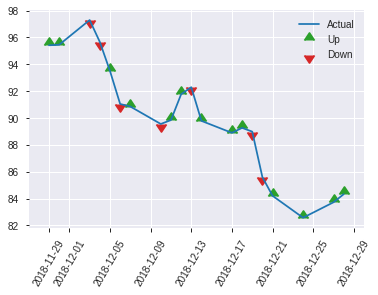


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21558935541815896
RMSE: 0.46431600814333224
LogLoss: 0.6211518223449343
Null degrees of freedom: 250
Residual degrees of freedom: 210
Null deviance: 347.0656557889856
Residual deviance: 311.81821481715696
AIC: 393.81821481715696
AUC: 0.7345482349942654
pr_auc: 0.7469839441189098
Gini: 0.4690964699885307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17656535493454112: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      34   84   0.7119   (84.0/118.0)
1      6    127  0.0451   (6.0/133.0)
Total  40   211  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.176565     0.738372  210
max f2                       0.0766498    0.858065  242
max f0point5                 0.515743     0.707965  107
max accuracy                 0.515743     0.677291  107
max precision                0.922323     1         0
max recall                   0.0766498    1         242
max specificity              0.922323     1         0
max absolute_mcc             0.515743     0.367152  107
max min_per_class_accuracy   0.452556     0.669173  125
max mean_per_class_accuracy  0.515743     0.682108  107

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 44.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.877681           1.88722   1.88722            1                0.908881   1                           0.908881            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.86485            1.88722   1.88722            1                0.867121   1                           0.888001            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.827783           0.943609  1.65132            0.5              0.830992   0.875                       0.873749            0.0075188       0.0526316                  -5.6391   65.1316
    4        0.0438247                   0.807494           1.88722   1.71565            1                0.813932   0.909091                    0.857435            0.0225564       0.075188                   88.7218   71.5653
    5        0.0517928                   0.790164           1.88722   1.74205            1                0.7979     0.923077                    0.848276            0.0150376       0.0902256                  88.7218   74.2047
    6        0.103586                    0.722719           1.59688   1.66946            0.846154         0.750719   0.884615                    0.799498            0.0827068       0.172932                   59.6877   66.9462
    7        0.151394                    0.691362           1.72995   1.68856            0.916667         0.707104   0.894737                    0.770321            0.0827068       0.255639                   72.995    68.8564
    8        0.203187                    0.658257           1.16136   1.55418            0.615385         0.675539   0.823529                    0.746161            0.0601504       0.315789                   16.1365   55.418
    9        0.302789                    0.591948           1.13233   1.41541            0.6              0.618869   0.75                        0.704288            0.112782        0.428571                   13.2331   41.5414
    10       0.40239                     0.538776           1.3588    1.4014             0.72             0.563296   0.742574                    0.669389            0.135338        0.56391                    35.8797   40.14
    11       0.501992                    0.452556           1.05684   1.33303            0.56             0.492748   0.706349                    0.634341            0.105263        0.669173                   5.68421   33.3035
    12       0.601594                    0.382705           0.830376  1.24981            0.44             0.414008   0.662252                    0.597862            0.0827068       0.75188                    -16.9624  24.9813
    13       0.701195                    0.290239           0.830376  1.19023            0.44             0.33457    0.630682                    0.560463            0.0827068       0.834586                   -16.9624  19.0234
    14       0.800797                    0.219369           0.754887  1.13609            0.4              0.246302   0.60199                     0.521388            0.075188        0.909774                   -24.5113  13.6086
    15       0.900398                    0.129883           0.60391   1.07722            0.32             0.169056   0.570796                    0.482413            0.0601504       0.969925                   -39.609   7.72174
    16       1                           0.0271136          0.301955  1                  0.16             0.0911341  0.52988                     0.

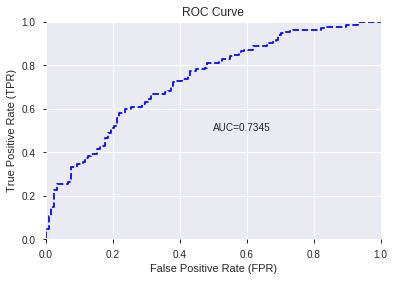

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


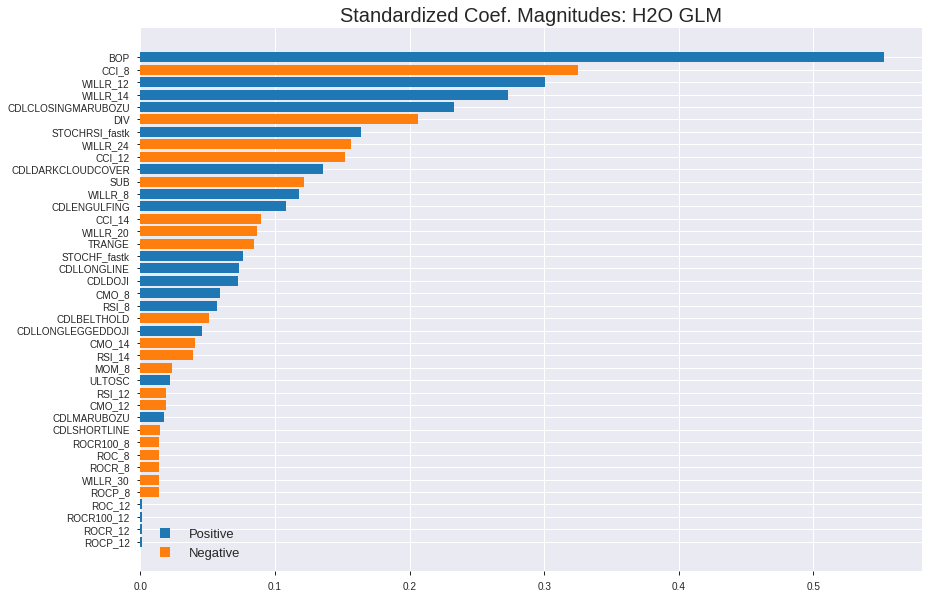

'log_likelihood'
--2019-08-27 14:16:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_141651_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_141651_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'WILLR_12',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'STOCHRSI_fastk',
 'WILLR_24',
 'CCI_12',
 'CDLDARKCLOUDCOVER',
 'SUB',
 'WILLR_8',
 'CDLENGULFING',
 'CCI_14',
 'WILLR_20',
 'TRANGE',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLDOJI',
 'CMO_8',
 'RSI_8',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'CMO_14',
 'RSI_14',
 'MOM_8',
 'ULTOSC',
 'RSI_12',
 'CMO_12',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'ROCR100_8',
 'ROC_8',
 'ROCR_8',
 'WILLR_30',
 'ROCP_8',
 'ROC_12',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12']

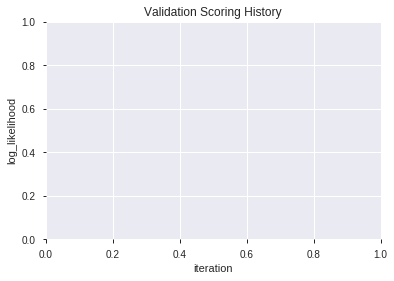

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_141706_model_3  0.753154  0.606887              0.303046  0.456729  0.208601
1               XGBoost_1_AutoML_20190827_141706  0.749204  0.600175              0.317669  0.454422  0.206499
2  XGBoost_grid_1_AutoML_20190827_141706_model_4  0.746018  0.602679              0.322321  0.455773  0.207729
3  XGBoost_grid_1_AutoML_20190827_141706_model_2  0.745380  0.614820              0.292182  0.460592  0.212145
4  XGBoost_grid_1_AutoML_20190827_141706_model_1  0.744998  0.612992              0.326144  0.459787  0.211404
5  XGBoost_grid_1_AutoML_20190827_141706_model_6  0.740920  0.606278              0.307283  0.457396  0.209211
6               XGBoost_2_AutoML_20190827_141706  0.739263  0.612134              0.329425  0.459482  0.211123
7               XGBoost_3_AutoML_20190827_141706  0.734612  0.612780              0.335574  0.461075  0.212590
8  XGBoost_grid_1_AutoML_20190827_141706_model_5  0.734293  0.620699              0.374251  0.463791  0.215102
9  XGBoost_grid_1_AutoML_20190827_141706_model_7  0.723079  0.619438              0.322862  0.462100  0.213537

variable  relative_importance  scaled_importance  percentage
0                  BOP          1867.989258           1.000000    0.284983
1                  DIV           332.862427           0.178193    0.050782
2       STOCHRSI_fastk           300.866882           0.161065    0.045901
3               TRANGE           300.188477           0.160701    0.045797
4         STOCHF_fastk           288.452301           0.154419    0.044007
5                  SUB           286.659424           0.153459    0.043733
6             WILLR_12           280.229401           0.150017    0.042752
7               CCI_12           239.742676           0.128343    0.036575
8                CCI_8           233.138672           0.124807    0.035568
9              WILLR_8           226.350891           0.121174    0.034532
10              ULTOSC           221.682190           0.118674    0.033820
11               ROC_8           172.962357           0.092593    0.026387
12              ROC_12           162.512283           0.086999    0.024793
13            WILLR_20           133.461151           0.071446    0.020361
14            WILLR_14           125.436432           0.067151    0.019137
15            WILLR_30           123.942680           0.066351    0.018909
16              CCI_14           123.609383           0.066172    0.018858
17  CDLCLOSINGMARUBOZU           115.299576           0.061724    0.017590
18            WILLR_24           102.635849           0.054945    0.015658
19               MOM_8            94.633835           0.050661    0.014437
20             ROCP_12            88.796844           0.047536    0.013547
21              RSI_12            80.820801           0.043266    0.012330
22              CMO_14            78.284424           0.041908    0.011943
23         CDLBELTHOLD            65.326904           0.034972    0.009966
24               CMO_8            63.404236           0.033943    0.009673
25              ROCP_8            56.593933           0.030297    0.008634
26               RSI_8            56.110382           0.030038    0.008560
27              CMO_12            48.704979           0.026073    0.007430
28         CDLLONGLINE            43.863293           0.023482    0.006692
29              ROCR_8            39.139366           0.020953    0.005971
30              RSI_14            38.328236           0.020518    0.005847
31             ROCR_12            33.863964           0.018129    0.005166
32        CDLSHORTLINE            31.008459           0.016600    0.004731
33             CDLDOJI            24.516863           0.013125    0.003740
34   CDLLONGLEGGEDDOJI            23.503464           0.012582    0.003586
35          ROCR100_12            16.426674           0.008794    0.002506
36           ROCR100_8            14.254870           0.007631    0.002175
37        CDLENGULFING            10.061388           0.005386    0.001535
38   CDLDARKCLOUDCOVER             8.525841           0.004564    0.001301
39         CDLMARUBOZU             0.547031           0.000293    0.000083

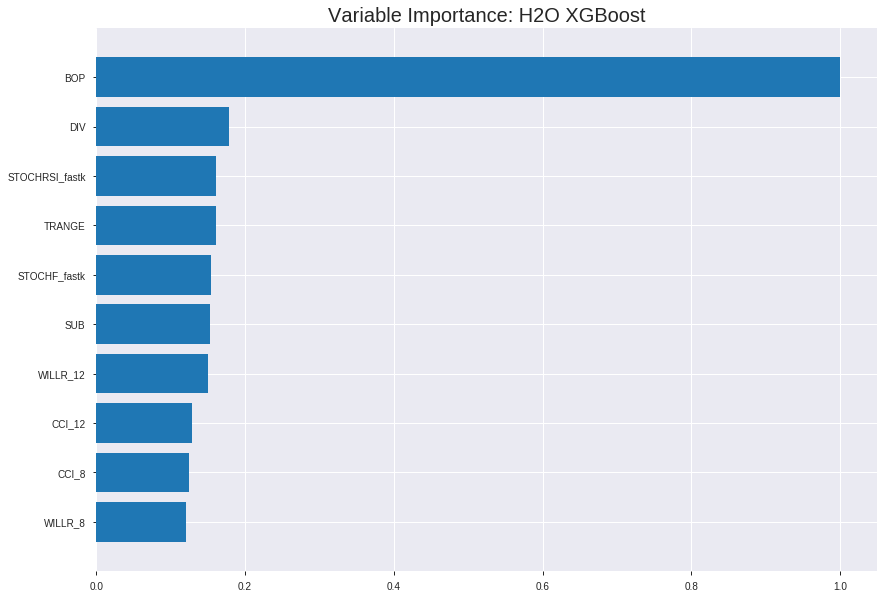

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_141706_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15445529589215837
RMSE: 0.39300800995928614
LogLoss: 0.47946868274919036
Mean Per-Class Error: 0.1987302200829979
AUC: 0.8819636146157884
pr_auc: 0.8964609419999487
Gini: 0.7639272292315769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5183313488960266: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      590  237   0.2866   (237.0/827.0)
1      143  783   0.1544   (143.0/926.0)
Total  733  1020  0.2168   (380.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518331     0.804728  205
max f2                       0.268154     0.888394  316
max f0point5                 0.641155     0.834715  138
max accuracy                 0.602047     0.79749   161
max precision                0.92109      1         0
max recall                   0.138628     1         370
max specificity              0.92109      1         0
max absolute_mcc             0.602047     0.604598  161
max min_per_class_accuracy   0.567246     0.783555  182
max mean_per_class_accuracy  0.602047     0.80127   161

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.92 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.889078           1.89309    1.89309            1                0.90055   1                           0.90055             0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.870258           1.89309    1.89309            1                0.878531  1                           0.88954             0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.856852           1.89309    1.89309            1                0.863325  1                           0.881131            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.846884           1.89309    1.89309            1                0.851445  1                           0.873605            0.0194384       0.0766739                  89.3089   89.3089
    5        0.0501997                   0.836369           1.89309    1.89309            1                0.840791  1                           0.867266            0.0183585       0.0950324                  89.3089   89.3089
    6        0.100399                    0.792205           1.85006    1.87158            0.977273         0.813461  0.988636                    0.840364            0.0928726       0.187905                   85.0064   87.1576
    7        0.150029                    0.762668           1.82781    1.8571             0.965517         0.776467  0.980989                    0.819227            0.0907127       0.278618                   82.781    85.7098
    8        0.200228                    0.732822           1.80704    1.84455            0.954545         0.747465  0.974359                    0.801235            0.0907127       0.36933                    80.7039   84.4548
    9        0.300057                    0.681124           1.57938    1.75633            0.834286         0.707059  0.927757                    0.769903            0.157667        0.526998                   57.9377   75.6326
    10       0.399886                    0.631068           1.41711    1.67164            0.748571         0.656871  0.883024                    0.741685            0.141469        0.668467                   41.7112   67.1643
    11       0.500285                    0.576066           1.05411    1.54771            0.556818         0.60225   0.81756                     0.713703            0.105832        0.774298                   5.41061   54.7713
    12       0.600114                    0.504988           0.832959   1.42881            0.44             0.541921  0.754753                    0.685127            0.0831533       0.857451                   -16.7041  42.8814
    13       0.699943                    0.402605           0.7356     1.32994            0.388571         0.45457   0.702526                    0.652244            0.0734341       0.930886                   -26.44    32.9945
    14       0.799772                    0.30113            0.454341   1.22065            0.24             0.351995  0.644793                    0.614766            0.0453564       0.976242                   -54.5659  22.0651
    15       0.899601                    0.194041           0.216353   1.1092             0.114286         0.245883  0.585923                    0.573831            0.0215983       0.99784                    -78.3647  10.9203
    16       1                           0.0524714          0.0215124  1                  0.0113636        0.129159  0.528237                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2101591592178536
RMSE: 0.45843119354801065
LogLoss: 0.6077195887947181
Mean Per-Class Error: 0.3264610026520114
AUC: 0.7277534587979678
pr_auc: 0.7404170400452944
Gini: 0.45550691759593565
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.360781729221344: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      84   154  0.6471   (154.0/238.0)
1      23   240  0.0875   (23.0/263.0)
Total  107  394  0.3533   (177.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360782     0.730594  304
max f2                       0.183395     0.854058  376
max f0point5                 0.568859     0.689525  200
max accuracy                 0.568859     0.674651  200
max precision                0.90575      1         0
max recall                   0.0705824    1         399
max specificity              0.90575      1         0
max absolute_mcc             0.568859     0.347311  200
max min_per_class_accuracy   0.579186     0.659664  193
max mean_per_class_accuracy  0.568859     0.673539  200

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 53.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.841383           1.90494   1.90494            1                0.863775  1                           0.863775            0.0228137       0.0228137                  90.4943   90.4943
    2        0.0219561                   0.830557           1.52395   1.73177            0.8              0.834929  0.909091                    0.850663            0.0152091       0.0380228                  52.3954   73.1766
    3        0.0319361                   0.813405           1.90494   1.78588            1                0.8183    0.9375                      0.84055             0.0190114       0.0570342                  90.4943   78.5884
    4        0.0419162                   0.798552           1.90494   1.81423            1                0.807465  0.952381                    0.832672            0.0190114       0.0760456                  90.4943   81.4231
    5        0.0518962                   0.787787           1.52395   1.75841            0.8              0.790867  0.923077                    0.824633            0.0152091       0.0912548                  52.3954   75.8409
    6        0.101796                    0.746237           1.52395   1.64348            0.8              0.766155  0.862745                    0.795967            0.0760456       0.1673                     52.3954   64.348
    7        0.151697                    0.722128           1.67635   1.65429            0.88             0.733823  0.868421                    0.775525            0.0836502       0.250951                   67.635    65.4293
    8        0.201597                    0.699282           1.14297   1.52773            0.6              0.710987  0.80198                     0.75955             0.0570342       0.307985                   14.2966   52.7727
    9        0.301397                    0.660806           1.18106   1.41294            0.62             0.67962   0.741722                    0.733083            0.117871        0.425856                   18.1065   41.2938
    10       0.401198                    0.622987           1.18106   1.35526            0.62             0.641455  0.711443                    0.71029             0.117871        0.543726                   18.1065   35.5258
    11       0.500998                    0.582045           1.14297   1.31297            0.6              0.603258  0.689243                    0.688969            0.114068        0.657795                   14.2966   31.2969
    12       0.600798                    0.528965           0.914373  1.24676            0.48             0.555358  0.654485                    0.666774            0.0912548       0.749049                   -8.56274  24.6757
    13       0.700599                    0.446864           0.800076  1.18313            0.42             0.48618   0.621083                    0.641049            0.0798479       0.828897                   -19.9924  18.3127
    14       0.800399                    0.341818           0.876274  1.14487            0.46             0.394532  0.600998                    0.610311            0.0874525       0.91635                    -12.3726  14.4866
    15       0.9002                      0.241457           0.571483  1.0813             0.3              0.293099  0.567627                    0.575143            0.0570342       0.973384                   -42.8517  8.1298
    16       1                           0.0705824          0.266692  1                  0.14             0.168566  0.52495                     0.534567           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:17:13  2.268 sec   0                  0.5              0.693147            0.5             0                  1                0.471763                         0.5                0.693147              0.5               0                    1                  0.47505
    2019-08-27 14:17:13  2.370 sec   5                  0.475772         0.645551            0.804031        0.817606           1.89309          0.300627                         0.485971           0.665341              0.705299          0.710267             1.63281            0.38523
    2019-08-27 14:17:13  2.447 sec   10                 0.456929         0.60905             0.820125        0.833762           1.89309          0.277239                         0.476767           0.647117              0.717233          0.724267             1.90494            0.383234
    2019-08-27 14:17:13  2.515 sec   15                 0.444607         0.584812            0.826219        0.840494           1.89309          0.273816                         0.474705           0.642441              0.696057          0.707486             1.90494            0.413174
    2019-08-27 14:17:13  2.591 sec   20                 0.434676         0.564803            0.836637        0.853985           1.89309          0.268682                         0.467204           0.627358              0.721842          0.730091             1.58745            0.37525
    2019-08-27 14:17:13  2.665 sec   25                 0.425828         0.546999            0.846779        0.864075           1.89309          0.267541                         0.465174           0.622733              0.724582          0.742482             1.90494            0.369261
    2019-08-27 14:17:13  2.740 sec   30                 0.419328         0.533693            0.854231        0.872437           1.89309          0.264689                         0.462754           0.6176                0.728616          0.739999             1.90494            0.365269
    2019-08-27 14:17:13  2.820 sec   35                 0.414252         0.522965            0.857245        0.874302           1.89309          0.245864                         0.463163           0.617979              0.723001          0.741204             1.90494            0.377246
    2019-08-27 14:17:13  2.903 sec   40                 0.40833          0.510829            0.864598        0.881907           1.89309          0.236167                         0.461408           0.614238              0.727066          0.740857             1.90494            0.363273
    2019-08-27 14:17:13  2.991 sec   45                 0.404125         0.501888            0.868246        0.885427           1.89309          0.253851                         0.460332           0.611772              0.726156          0.741243             1.90494            0.37525
    2019-08-27 14:17:13  3.081 sec   50                 0.399611         0.492727            0.873886        0.891407           1.89309          0.227039                         0.460133           0.611408              0.726364          0.743186             1.90494            0.369261
    2019-08-27 14:17:13  3.160 sec   55                 0.396676         0.486632            0.877314        0.893261           1.89309          0.224758                         0.459158           0.60945               0.72721           0.739

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                1867.9892578125        1.0                    0.2849830505289937
DIV                332.8624267578125      0.1781929020018078     0.05078195679508921
STOCHRSI_fastk     300.86688232421875     0.161064567724842      0.04590067184235918
TRANGE             300.1884765625         0.1607013933870446     0.04579717331169982
STOCHF_fastk       288.4523010253906      0.15441860804016685    0.04400668597772774
---                ---                    ---                    ---
ROCR100_12         16.426673889160156     0.008793773208522909   0.002506076314624995
ROCR100_8          14.254870414733887     0.007631130829642449   0.0021747429428173558
CDLENGULFING       10.06138801574707      0.0053862129954266496  0.0015349794102355956
CDLDARKCLOUDCOVER  8.525840759277344      0.004564180828995499   0.0013007141758130888
CDLMARUBOZU        0.5470314025878906     0.0002928450473149343  8.345587491611748e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.75)

('auc', 0.7531540716197273)

('logloss', 0.6068870096752612)

('mean_per_class_error', 0.3010067541735695)

('rmse', 0.45672852776937933)

('mse', 0.2086009480783847)

xgboost prediction progress: |████████████████████████████████████████████| 100%


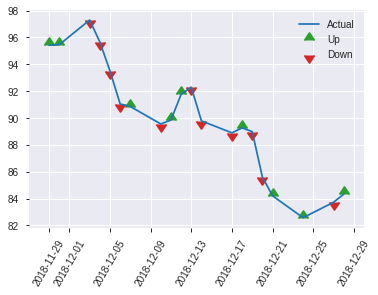


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2086009480783847
RMSE: 0.45672852776937933
LogLoss: 0.6068870096752612
Mean Per-Class Error: 0.3010067541735695
AUC: 0.7531540716197273
pr_auc: 0.7586259668902979
Gini: 0.5063081432394545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3681551218032837: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   52   0.4407   (52.0/118.0)
1      22   111  0.1654   (22.0/133.0)
Total  88   163  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368155     0.75      162
max f2                       0.102768     0.859173  241
max f0point5                 0.490334     0.721232  120
max accuracy                 0.387921     0.705179  156
max precision                0.869848     1         0
max recall                   0.102768     1         241
max specificity              0.869848     1         0
max absolute_mcc             0.368155     0.412028  162
max min_per_class_accuracy   0.471028     0.684211  127
max mean_per_class_accuracy  0.490334     0.698993  120

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.793814           1.88722   1.88722            1                0.836238  1                           0.836238            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.777375           1.88722   1.88722            1                0.780528  1                           0.808383            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.743358           1.88722   1.88722            1                0.763275  1                           0.797106            0.0150376       0.0601504                  88.7218   88.7218
    4        0.0438247                   0.727235           1.88722   1.88722            1                0.730734  1                           0.779005            0.0225564       0.0827068                  88.7218   88.7218
    5        0.0517928                   0.710115           0.943609  1.74205            0.5              0.718098  0.923077                    0.769634            0.0075188       0.0902256                  -5.6391   74.2047
    6        0.103586                    0.682986           1.45171   1.59688            0.769231         0.695378  0.846154                    0.732506            0.075188        0.165414                   45.1706   59.6877
    7        0.151394                    0.651008           1.57268   1.58924            0.833333         0.667227  0.842105                    0.711891            0.075188        0.240602                   57.2682   58.9236
    8        0.203187                    0.628646           1.30654   1.51718            0.692308         0.635939  0.803922                    0.692531            0.0676692       0.308271                   30.6536   51.7175
    9        0.302789                    0.577827           1.50977   1.51474            0.8              0.603069  0.802632                    0.663103            0.150376        0.458647                   50.9774   51.4741
    10       0.40239                     0.5225             1.05684   1.4014             0.56             0.546889  0.742574                    0.634337            0.105263        0.56391                    5.68421   40.14
    11       0.501992                    0.480466           1.13233   1.34801            0.6              0.502781  0.714286                    0.608235            0.112782        0.676692                   13.2331   34.8013
    12       0.601594                    0.408999           1.05684   1.29981            0.56             0.44264   0.688742                    0.580818            0.105263        0.781955                   5.68421   29.9806
    13       0.701195                    0.343806           0.830376  1.23313            0.44             0.370665  0.653409                    0.550967            0.0827068       0.864662                   -16.9624  23.3125
    14       0.800797                    0.273129           0.528421  1.14548            0.28             0.316431  0.606965                    0.521796            0.0526316       0.917293                   -47.1579  14.5476
    15       0.900398                    0.171409           0.452932  1.06887            0.24             0.216683  0.566372                    0.488044            0.0451128       0.962406                   -54.7068  6.88669
    16       1                           0.0500281          0.377444  1                  0.2              0.117882  0.52988                     0.451176           

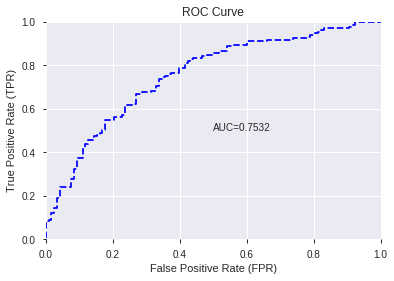

This function is available for GLM models only


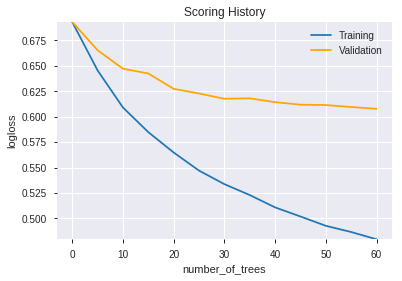

--2019-08-27 14:17:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_141706_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_141706_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHRSI_fastk',
 'TRANGE',
 'STOCHF_fastk',
 'SUB',
 'WILLR_12',
 'CCI_12',
 'CCI_8',
 'WILLR_8',
 'ULTOSC',
 'ROC_8',
 'ROC_12',
 'WILLR_20',
 'WILLR_14',
 'WILLR_30',
 'CCI_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_24',
 'MOM_8',
 'ROCP_12',
 'RSI_12',
 'CMO_14',
 'CDLBELTHOLD',
 'CMO_8',
 'ROCP_8',
 'RSI_8',
 'CMO_12',
 'CDLLONGLINE',
 'ROCR_8',
 'RSI_14',
 'ROCR_12',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'ROCR100_12',
 'ROCR100_8',
 'CDLENGULFING',
 'CDLDARKCLOUDCOVER',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

130

['MA_14_6',
 'MAVP_14_6',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_middleband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'MA_14_7',
 'BBANDS_upperband_14_7_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_0_3',
 'BBANDS_middleband_20_0_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_middleband_20_1_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_20_6_3',
 'BBANDS_upperband_20_7_3',
 'BBANDS_upperband_24_6_4',
 'TRIMA_30',
 'BBANDS_middleband_30_0_4',
 'MAVP_30_1',
 'BBANDS_lowerband_30_1_4',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_middleband_30_7_3',
 'BBANDS_upperband_30_7_5',
 'BOP',
 'ADXR_8',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_8',
 'ADX_12',
 'DX_12',
 'MFI_12',
 'ROCP_12',
 'ROCR1

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_141855_model_6  0.724162  0.639335              0.372818  0.472785  0.223526
1  DeepLearning_grid_1_AutoML_20190827_141855_model_5  0.718427  0.646947              0.327992  0.475221  0.225835
2  DeepLearning_grid_1_AutoML_20190827_141855_model_8  0.714413  0.651592              0.330381  0.479182  0.229615
3  DeepLearning_grid_1_AutoML_20190827_141855_model_9  0.706385  0.640674              0.351090  0.474240  0.224904
4  DeepLearning_grid_1_AutoML_20190827_141855_model_3  0.662228  0.858848              0.500000  0.508613  0.258687
5  DeepLearning_grid_1_AutoML_20190827_141855_model_2  0.657066  1.057073              0.435899  0.546553  0.298721
6  DeepLearning_grid_1_AutoML_20190827_141855_model_4  0.648337  0.772485              0.474576  0.512791  0.262954
7               DeepLearning_1_AutoML_20190827_141855  0.640308  0.715716              0.487288  0.498547  0.248549
8  DeepLearning_grid_1_AutoML_20190827_141855_model_1  0.563400  1.841055              0.500000  0.605202  0.366270
9  DeepLearning_grid_1_AutoML_20190827_141855_model_7  0.553269  0.834272              0.491525  0.556283  0.309450

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.017991
1         CDLCLOSINGMARUBOZU             0.866643           0.866643    0.015592
2                CDLLONGLINE             0.728980           0.728980    0.013115
3                     TRANGE             0.574220           0.574220    0.010331
4             STOCHRSI_fastk             0.551031           0.551031    0.009914
..                       ...                  ...                ...         ...
125               CDLHIKKAKE             0.378786           0.378786    0.006815
126   LINEARREG_INTERCEPT_12             0.378703           0.378703    0.006813
127  BBANDS_upperband_20_0_2             0.377501           0.377501    0.006792
128  BBANDS_upperband_14_7_2             0.373435           0.373435    0.006719
129  BBANDS_lowerband_30_1_4             0.371786           0.371786    0.006689

[130 rows x 4 columns]

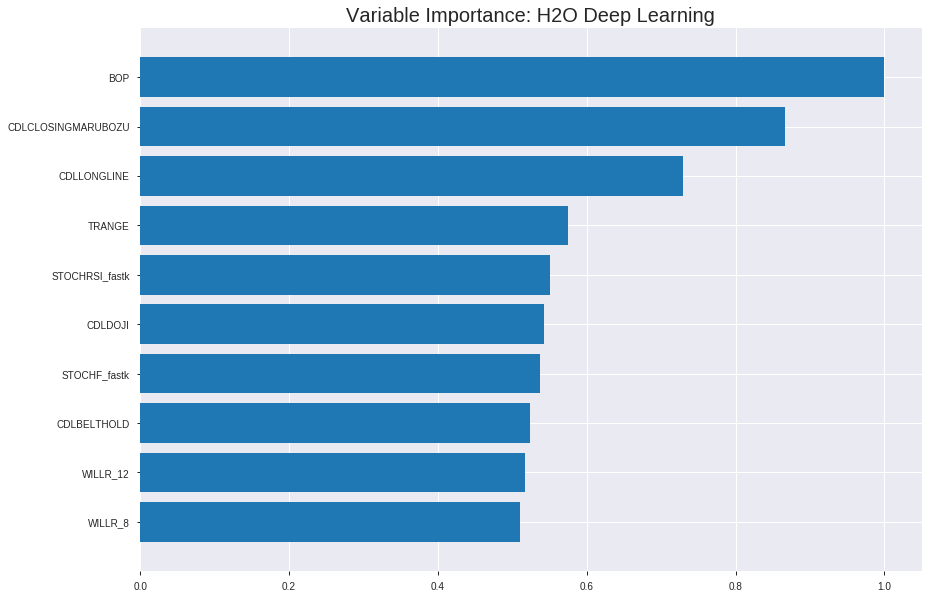

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_141855_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19229760052781952
RMSE: 0.43851750310314813
LogLoss: 0.564096878868083
Mean Per-Class Error: 0.28265857232026037
AUC: 0.7756619857352162
pr_auc: 0.778496514798342
Gini: 0.5513239714704323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43702275475246977: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      383  444   0.5369   (444.0/827.0)
1      91   835   0.0983   (91.0/926.0)
Total  474  1279  0.3052   (535.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437023     0.75737   253
max f2                       0.263193     0.863027  322
max f0point5                 0.590823     0.732927  180
max accuracy                 0.571014     0.719338  189
max precision                0.969566     1         0
max recall                   0.0666467    1         386
max specificity              0.969566     1         0
max absolute_mcc             0.571014     0.435972  189
max min_per_class_accuracy   0.598552     0.712213  177
max mean_per_class_accuracy  0.571014     0.717341  189

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 55.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.947036           1.89309   1.89309            1                0.956066  1                           0.956066            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.932618           1.78792   1.8405             0.944444         0.939936  0.972222                    0.948001            0.0183585       0.037797                   78.7917   84.0503
    3        0.0302339                   0.913225           1.89309   1.85737            1                0.919231  0.981132                    0.938773            0.0183585       0.0561555                  89.3089   85.737
    4        0.040502                    0.891539           1.57757   1.78644            0.833333         0.904677  0.943662                    0.930129            0.0161987       0.0723542                  57.7574   78.6436
    5        0.0501997                   0.874365           1.67037   1.76401            0.882353         0.880706  0.931818                    0.920581            0.0161987       0.0885529                  67.0372   76.4014
    6        0.100399                    0.821571           1.5704    1.66721            0.829545         0.848144  0.880682                    0.884363            0.0788337       0.167387                   57.0403   66.7209
    7        0.150029                    0.783272           1.50142   1.61236            0.793103         0.803601  0.851711                    0.857647            0.074514        0.241901                   50.1415   61.2364
    8        0.200228                    0.751463           1.37679   1.5533             0.727273         0.767087  0.820513                    0.834942            0.0691145       0.311015                   37.6792   55.3303
    9        0.300057                    0.699746           1.31975   1.4756             0.697143         0.72379   0.779468                    0.797962            0.131749        0.442765                   31.9753   47.5601
    10       0.399886                    0.650544           1.34139   1.4421             0.708571         0.673548  0.761769                    0.766903            0.133909        0.576674                   34.1388   44.2096
    11       0.500285                    0.602435           1.20469   1.39445            0.636364         0.628317  0.736602                    0.739091            0.12095         0.697624                   20.4693   39.4453
    12       0.600114                    0.541874           0.9195    1.31544            0.485714         0.570684  0.694867                    0.711076            0.0917927       0.789417                   -8.04998  31.5445
    13       0.699943                    0.463741           0.854594  1.24972            0.451429         0.503284  0.660147                    0.68144             0.0853132       0.87473                    -14.5406  24.9716
    14       0.799772                    0.350471           0.681512  1.17879            0.36             0.411135  0.622682                    0.6477              0.0680346       0.942765                   -31.8488  17.8792
    15       0.899601                    0.202288           0.389435  1.0912             0.205714         0.281096  0.576411                    0.607018            0.0388769       0.981641                   -61.0565  9.11969
    16       1                           0.0265361          0.182855  1                  0.0965909        0.113391  0.528237                    0.557458          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.215736809602588
RMSE: 0.46447476745522787
LogLoss: 0.6207556431470561
Mean Per-Class Error: 0.3333546346295173
AUC: 0.7151883567115059
pr_auc: 0.7045761851163839
Gini: 0.43037671342301187
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4355835040533279: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   157  0.6597   (157.0/238.0)
1      21   242  0.0798   (21.0/263.0)
Total  102  399  0.3553   (178.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435584     0.731118  304
max f2                       0.312612     0.856574  352
max f0point5                 0.589393     0.683829  186
max accuracy                 0.538321     0.672655  233
max precision                0.887193     1         0
max recall                   0.14362      1         393
max specificity              0.887193     1         0
max absolute_mcc             0.528284     0.346092  241
max min_per_class_accuracy   0.580012     0.663866  192
max mean_per_class_accuracy  0.538321     0.666645  233

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 54.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.808718           1.58745   1.58745            0.833333         0.833593  0.833333                    0.833593            0.0190114       0.0190114                  58.7452   58.7452
    2        0.0219561                   0.781906           1.52395   1.55859            0.8              0.79433   0.818182                    0.815746            0.0152091       0.0342205                  52.3954   55.859
    3        0.0319361                   0.777972           1.52395   1.54777            0.8              0.779033  0.8125                      0.804273            0.0152091       0.0494297                  52.3954   54.7766
    4        0.0419162                   0.762352           0.761977  1.36067            0.4              0.766773  0.714286                    0.795345            0.00760456      0.0570342                  -23.8023  36.0674
    5        0.0518962                   0.752386           1.90494   1.46534            1                0.75588   0.769231                    0.787755            0.0190114       0.0760456                  90.4943   46.5341
    6        0.101796                    0.702725           1.75255   1.60613            0.92             0.723345  0.843137                    0.756182            0.0874525       0.163498                   75.2548   60.6128
    7        0.151697                    0.68332            1.44776   1.55403            0.76             0.692185  0.815789                    0.73513             0.0722433       0.235741                   44.7757   55.4032
    8        0.201597                    0.6635             1.06677   1.43342            0.56             0.673359  0.752475                    0.71984             0.0532319       0.288973                   6.67681   43.3422
    9        0.301397                    0.635007           1.21916   1.36248            0.64             0.64872   0.715232                    0.69629             0.121673        0.410646                   21.9163   36.2476
    10       0.401198                    0.612526           1.29536   1.34578            0.68             0.624026  0.706468                    0.678314            0.129278        0.539924                   29.5361   34.5781
    11       0.500998                    0.585258           1.14297   1.30538            0.6              0.599302  0.685259                    0.662575            0.114068        0.653992                   14.2966   30.5379
    12       0.600798                    0.552344           1.02867   1.25941            0.54             0.567277  0.66113                     0.646744            0.102662        0.756654                   2.86692   25.9414
    13       0.700599                    0.495407           0.800076  1.19398            0.42             0.523383  0.626781                    0.629172            0.0798479       0.836502                   -19.9924  19.3981
    14       0.800399                    0.431167           0.838175  1.14962            0.44             0.463896  0.603491                    0.608564            0.0836502       0.920152                   -16.1825  14.9616
    15       0.9002                      0.323808           0.571483  1.08552            0.3              0.378913  0.569845                    0.583103            0.0570342       0.977186                   -42.8517  8.55218
    16       1                           0.0668995          0.228593  1                  0.12             0.232891  0.52495                     0.548152          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:24:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:24:18  2 min 40.596 sec  774 obs/sec       0.849971  1             1490       0.542438         1.12068             -0.180723      0.679324        0.665491           1.68275          0.415288                         0.648821           1.82086               -0.688076        0.702591          0.688643             1.58745            0.353293
    2019-08-27 14:24:25  2 min 47.849 sec  1223 obs/sec      5.91843   7             10375      0.444865         0.577604            0.205847       0.758506        0.763534           1.78792          0.306902                         0.471868           0.634323              0.10714          0.697239          0.701128             1.90494            0.365269
    2019-08-27 14:24:32  2 min 55.106 sec  1576 obs/sec      13.5288   16            23716      0.438518         0.564097            0.228349       0.775662        0.778497           1.89309          0.305191                         0.464475           0.620756              0.134899         0.715188          0.704576             1.58745            0.355289
    2019-08-27 14:24:39  3 min  2.515 sec  1773 obs/sec      22.0131   26            38589      0.433298         0.552433            0.246608       0.78641         0.792962           1.89309          0.301198                         0.468356           0.630013              0.120381         0.721371          0.711329             1.58745            0.38523
    2019-08-27 14:24:47  3 min  9.752 sec  1888 obs/sec      30.4655   36            53406      0.431377         0.547877            0.253275       0.795289        0.803859           1.89309          0.301198                         0.46498            0.623016              0.133015         0.729111          0.714532             1.58745            0.373253
    2019-08-27 14:24:54  3 min 16.950 sec  1964 obs/sec      38.9527   46            68284      0.4215           0.52702             0.287077       0.810967        0.81933            1.89309          0.289218                         0.466141           0.625484              0.128682         0.719358          0.700517             1.58745            0.353293
    2019-08-27 14:25:02  3 min 24.693 sec  2023 obs/sec      48.263    57            84605      0.415587         0.51403             0.30694        0.823065        0.832942           1.89309          0.285796                         0.465795           0.626351              0.129973         0.714038          0.701043             1.58745            0.347305
    2019-08-27 14:25:02  3 min 25.393 sec  2022 obs/sec      48.263    57            84605      0.438518         0.564097            0.228349       0.775662        0.778497           1.89309          0.305191                         0.464475           0.620756              0.134899         0.715188          0.704576             1.58745            0.355289

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.017991497472749664
CDLCLOSINGMARUBOZU       0.866642951965332      0.866642951965332    0.01559220448006058
CDLLONGLINE              0.7289797067642212     0.7289797067642212   0.013115436551934277
TRANGE                   0.5742197036743164     0.5742197036743164   0.010331072347459525
STOCHRSI_fastk           0.551031231880188      0.551031231880188    0.009913877015778536
---                      ---                    ---                  ---
CDLHIKKAKE               0.3787859380245209     0.3787859380245209   0.0068149262466812785
LINEARREG_INTERCEPT_12   0.3787034749984741     0.3787034749984741   0.006813442613356563
BBANDS_upperband_20_0_2  0.3775009214878082     0.3775009214878082   0.006791806874908572
BBANDS_upperband_14_7_2  0.37343522906303406    0.37343522906303406  0.00671865897992327
BBANDS_lowerband_30_1_4  0.3717857599258423     0.3717857599258423   0.006688982560110105


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7359050445103857)

('auc', 0.7241621001656684)

('logloss', 0.6393352996764116)

('mean_per_class_error', 0.31473811647763483)

('rmse', 0.47278530092383725)

('mse', 0.22352594076964336)

deeplearning prediction progress: |███████████████████████████████████████| 100%


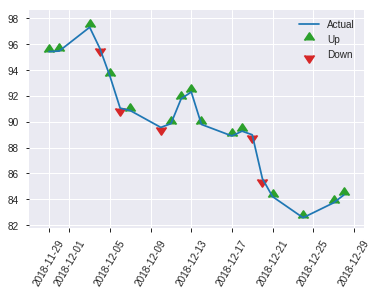


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22352594076964336
RMSE: 0.47278530092383725
LogLoss: 0.6393352996764116
Mean Per-Class Error: 0.31473811647763483
AUC: 0.7241621001656684
pr_auc: 0.7235537917215911
Gini: 0.4483242003313368
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4241248261881761: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   80   0.678    (80.0/118.0)
1      9    124  0.0677   (9.0/133.0)
Total  47   204  0.3546   (89.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424125     0.735905  203
max f2                       0.163244     0.851472  248
max f0point5                 0.534971     0.706422  102
max accuracy                 0.50082      0.689243  144
max precision                0.771342     1         0
max recall                   0.163244     1         248
max specificity              0.771342     1         0
max absolute_mcc             0.494568     0.375163  152
max min_per_class_accuracy   0.515665     0.676692  126
max mean_per_class_accuracy  0.50082      0.685262  144

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.69924            1.88722   1.88722            1                0.730241  1                           0.730241            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.688136           1.25815   1.57268            0.666667         0.690255  0.833333                    0.710248            0.0150376       0.037594                   25.8145   57.2682
    3        0.0318725                   0.676482           1.88722   1.65132            1                0.680332  0.875                       0.702769            0.0150376       0.0526316                  88.7218   65.1316
    4        0.0438247                   0.655831           0.629073  1.37252            0.333333         0.667815  0.727273                    0.693236            0.0075188       0.0601504                  -37.0927  37.2522
    5        0.0517928                   0.653314           1.88722   1.45171            1                0.654317  0.769231                    0.687248            0.0150376       0.075188                   88.7218   45.1706
    6        0.103586                    0.630936           1.59688   1.52429            0.846154         0.640699  0.807692                    0.663974            0.0827068       0.157895                   59.6877   52.4291
    7        0.151394                    0.607161           1.57268   1.53957            0.833333         0.618771  0.815789                    0.649699            0.075188        0.233083                   57.2682   53.9573
    8        0.203187                    0.589727           1.30654   1.48017            0.692308         0.597072  0.784314                    0.636284            0.0676692       0.300752                   30.6536   48.0171
    9        0.302789                    0.556488           1.28331   1.41541            0.68             0.574548  0.75                        0.615976            0.12782         0.428571                   28.3308   41.5414
    10       0.40239                     0.535247           1.3588    1.4014             0.72             0.545413  0.742574                    0.59851             0.135338        0.56391                    35.8797   40.14
    11       0.501992                    0.515684           1.05684   1.33303            0.56             0.526053  0.706349                    0.584134            0.105263        0.669173                   5.68421   33.3035
    12       0.601594                    0.497077           0.981353  1.27481            0.52             0.50759   0.675497                    0.571461            0.0977444       0.766917                   -1.86466  27.481
    13       0.701195                    0.470001           0.679398  1.19023            0.36             0.485217  0.630682                    0.55921             0.0676692       0.834586                   -32.0602  19.0234
    14       0.800797                    0.430469           0.754887  1.13609            0.4              0.446821  0.60199                     0.545232            0.075188        0.909774                   -24.5113  13.6086
    15       0.900398                    0.344267           0.301955  1.04382            0.16             0.398622  0.553097                    0.529014            0.0300752       0.93985                    -69.8045  4.38153
    16       1                           0.150962           0.60391   1                  0.32             0.253885  0.52988                     0.50161             

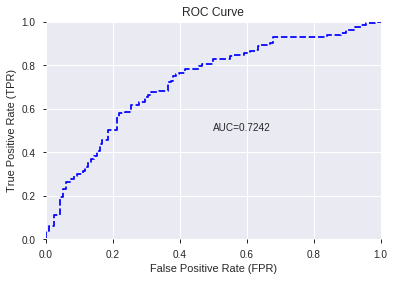

This function is available for GLM models only


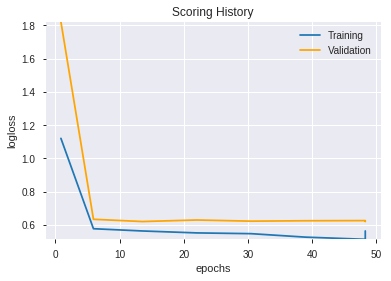

--2019-08-27 14:29:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_141855_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_141855_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'WILLR_12',
 'WILLR_8',
 'STOCHRSI_fastd',
 'PLUS_DM_8',
 'HT_PHASOR_quadrature',
 'ULTOSC',
 'aroonup_8',
 'STOCHF_fastd',
 'DX_12',
 'CCI_8',
 'aroonup_24',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_12',
 'NATR_12',
 'STOCH_slowd',
 'BETA_14',
 'aroondown_20',
 'BETA_12',
 'ADXR_8',
 'AROONOSC_14',
 'ROCR_8',
 'BETA_8',
 'AROONOSC_8',
 'DX_30',
 'ADX_20',
 'WILLR_30',
 'ROCP_12',
 'CORREL_8',
 'aroondown_30',
 'LINEARREG_ANGLE_8',
 'ROC_14',
 'DX_20',
 'LINEARREG_SLOPE_8',
 'MINUS_DM_24',
 'MACDEXT',
 'AROONOSC_24',
 'PLUS_DI_20',
 'ROCP_24',
 'MACDFIX_signal_20',
 'VAR_8',
 'ADX_12',
 'HT_PHASOR_inphase',
 'CDLSPINNINGTOP',
 'BBANDS_lowerband_20_2_4',
 'MFI_12',
 'aroondown_8',
 'MOM_14',
 'STDDEV_12',
 'MINUS_DI_30',
 'ATR_12',
 'LINEARREG_INTERCEPT_8',
 'CORREL_14',
 'ROCR100_8',
 'aroondown_24',
 'ROCR100_12',
 'MACDFIX_hist_8',
 'AROONOSC_30',
 'RSI_12',
 'MACD_sig

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142929_model_1  0.726902  0.613886              0.340289  0.460626  0.212176

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.382136           1.000000    0.073182
1                    TRANGE             0.235354           0.615891    0.045072
2        CDLCLOSINGMARUBOZU             0.196012           0.512938    0.037538
3                  WILLR_12             0.186145           0.487117    0.035648
4                     CCI_8             0.153661           0.402110    0.029427
..                      ...                  ...                ...         ...
125               ROCR100_8             0.002095           0.005483    0.000401
126       LINEARREG_ANGLE_8             0.001592           0.004166    0.000305
127  LINEARREG_INTERCEPT_12             0.001198           0.003135    0.000229
128          MACDFIX_hist_8             0.000633           0.001658    0.000121
129                  ATR_24             0.000615           0.001608    0.000118

[130 rows x 4 columns]

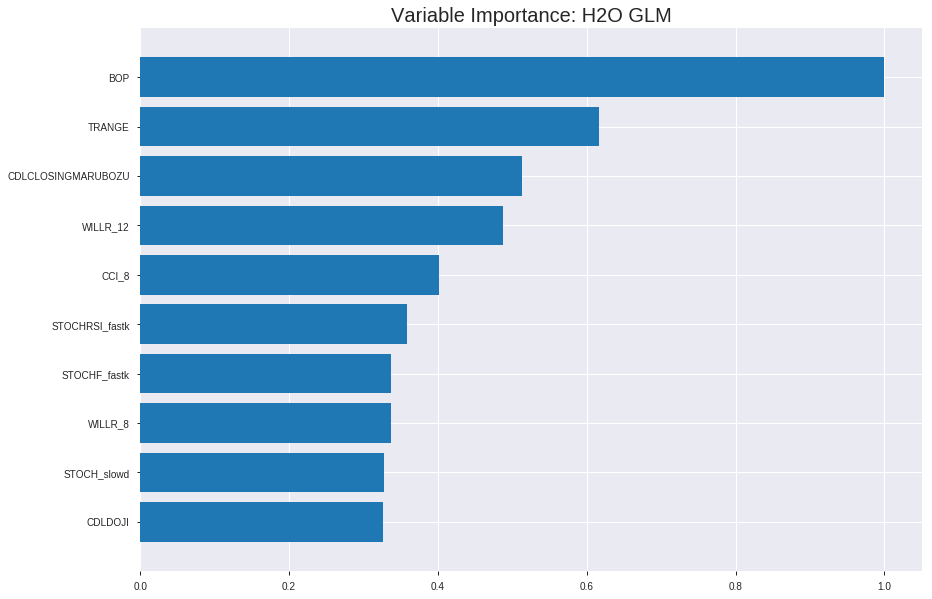

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142929_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19368676105729613
RMSE: 0.44009858106712424
LogLoss: 0.5702517364254469
Null degrees of freedom: 1752
Residual degrees of freedom: 1622
Null deviance: 2424.5800523999424
Residual deviance: 1999.3025879076165
AIC: 2261.3025879076167
AUC: 0.7711255650938493
pr_auc: 0.7664295452309211
Gini: 0.5422511301876987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40952052844404285: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      417  410   0.4958   (410.0/827.0)
1      114  812   0.1231   (114.0/926.0)
Total  531  1222  0.2989   (524.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409521     0.756052  256
max f2                       0.212433     0.862069  346
max f0point5                 0.538967     0.728857  192
max accuracy                 0.489463     0.720479  215
max precision                0.940208     1         0
max recall                   0.112819     1         382
max specificity              0.940208     1         0
max absolute_mcc             0.489463     0.438814  215
max min_per_class_accuracy   0.554572     0.706263  183
max mean_per_class_accuracy  0.508721     0.715919  207

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.899683           1.57757   1.57757            0.833333         0.915837  0.833333                    0.915837            0.0161987       0.0161987                  57.7574   57.7574
    2        0.0205362                   0.885315           1.89309   1.73533            1                0.893491  0.916667                    0.904664            0.0194384       0.0356371                  89.3089   73.5331
    3        0.0302339                   0.873283           1.89309   1.78593            1                0.878519  0.943396                    0.896278            0.0183585       0.0539957                  89.3089   78.5933
    4        0.040502                    0.860588           1.68275   1.75977            0.888889         0.86598   0.929577                    0.888597            0.0172786       0.0712743                  68.2745   75.9772
    5        0.0501997                   0.841892           1.67037   1.7425             0.882353         0.851794  0.920455                    0.881487            0.0161987       0.087473                   67.0372   74.2502
    6        0.100399                    0.789172           1.54889   1.6457             0.818182         0.813616  0.869318                    0.847552            0.0777538       0.165227                   54.8891   64.5696
    7        0.150029                    0.748033           1.3491    1.54758            0.712644         0.764828  0.81749                     0.820187            0.0669546       0.232181                   34.9098   54.7582
    8        0.200228                    0.71387            1.54889   1.54791            0.818182         0.72987   0.817664                    0.797543            0.0777538       0.309935                   54.8891   54.791
    9        0.300057                    0.664639           1.27648   1.45761            0.674286         0.690597  0.769962                    0.761962            0.12743         0.437365                   27.6483   45.7606
    10       0.399886                    0.616859           1.35221   1.43129            0.714286         0.639782  0.756063                    0.731461            0.134989        0.572354                   35.2206   43.1294
    11       0.500285                    0.561612           1.21545   1.38798            0.642045         0.590432  0.733181                    0.703159            0.12203         0.694384                   21.5449   38.7977
    12       0.600114                    0.481667           1.02768   1.32804            0.542857         0.525195  0.701521                    0.673554            0.102592        0.796976                   2.76766   32.8041
    13       0.699943                    0.40663            0.822141  1.25589            0.434286         0.442698  0.663407                    0.640629            0.0820734       0.87905                    -17.7859  25.5888
    14       0.799772                    0.326417           0.540882  1.16664            0.285714         0.365792  0.616262                    0.606323            0.0539957       0.933045                   -45.9118  16.6639
    15       0.899601                    0.229843           0.497612  1.0924             0.262857         0.278919  0.577045                    0.569991            0.049676        0.982721                   -50.2388  9.23973
    16       1                           0.0460025          0.172099  1                  0.0909091        0.154115  0.528237                    0.528237          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20747080425258768
RMSE: 0.45548963133378534
LogLoss: 0.6044731581204373
Null degrees of freedom: 500
Residual degrees of freedom: 370
Null deviance: 693.3071704359105
Residual deviance: 605.6821044366782
AIC: 867.6821044366782
AUC: 0.7382257085343643
pr_auc: 0.7224291937965498
Gini: 0.4764514170687286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42531611156444893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  120  0.5042   (120.0/238.0)
1      36   227  0.1369   (36.0/263.0)
Total  154  347  0.3114   (156.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425316     0.744262  264
max f2                       0.263981     0.859894  356
max f0point5                 0.640698     0.700483  149
max accuracy                 0.437544     0.690619  258
max precision                0.89964      0.857143  5
max recall                   0.0942574    1         396
max specificity              0.938522     0.995798  0
max absolute_mcc             0.437544     0.389576  258
max min_per_class_accuracy   0.579635     0.673004  195
max mean_per_class_accuracy  0.437544     0.682158  258

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 54.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.900755           1.58745   1.58745            0.833333         0.911189  0.833333                    0.911189            0.0190114       0.0190114                  58.7452   58.7452
    2        0.0219561                   0.88177            1.14297   1.38541            0.6              0.890279  0.727273                    0.901684            0.0114068       0.0304183                  14.2966   38.5413
    3        0.0319361                   0.871227           1.52395   1.42871            0.8              0.873918  0.75                        0.893007            0.0152091       0.0456274                  52.3954   42.8707
    4        0.0419162                   0.855663           1.90494   1.5421             1                0.860927  0.809524                    0.885369            0.0190114       0.0646388                  90.4943   54.2097
    5        0.0518962                   0.844767           1.52395   1.53861            0.8              0.849997  0.807692                    0.878567            0.0152091       0.0798479                  52.3954   53.8608
    6        0.101796                    0.785797           1.60015   1.56878            0.84             0.817074  0.823529                    0.848423            0.0798479       0.159696                   60.0152   56.8777
    7        0.151697                    0.754264           1.52395   1.55403            0.8              0.769877  0.815789                    0.822586            0.0760456       0.235741                   52.3954   55.4032
    8        0.201597                    0.726146           1.37156   1.50887            0.72             0.740271  0.792079                    0.802211            0.0684411       0.304183                   37.1559   50.8866
    9        0.301397                    0.674709           1.25726   1.42555            0.66             0.703056  0.748344                    0.769378            0.125475        0.429658                   25.7262   42.5553
    10       0.401198                    0.630027           1.33346   1.40264            0.7              0.654539  0.736318                    0.740811            0.13308         0.562738                   33.346    40.2645
    11       0.500998                    0.58202            1.02867   1.32815            0.54             0.607366  0.697211                    0.714228            0.102662        0.665399                   2.86692   32.8147
    12       0.600798                    0.506819           0.952471  1.26574            0.5              0.546653  0.664452                    0.686392            0.095057        0.760456                   -4.75285  26.5743
    13       0.700599                    0.421183           1.02867   1.23197            0.54             0.46343   0.646724                    0.654631            0.102662        0.863118                   2.86692   23.1972
    14       0.800399                    0.368794           0.533384  1.14487            0.28             0.392406  0.600998                    0.621935            0.0532319       0.91635                    -46.6616  14.4866
    15       0.9002                      0.267041           0.609582  1.08552            0.32             0.317722  0.569845                    0.588208            0.0608365       0.977186                   -39.0418  8.55218
    16       1                           0.019937           0.228593  1                  0.12             0.182018  0.52495                     0.54767          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:29:29  0.000 sec   2            .2E2      131           1.363604834487176   1.3709782412966105
     2019-08-27 14:29:29  0.055 sec   4            .15E2     131           1.3578989005639233  1.3668541883399037
     2019-08-27 14:29:29  0.114 sec   6            .11E2     131           1.3507847891016938  1.3615272881767042
     2019-08-27 14:29:29  0.166 sec   8            .78E1     131           1.3421007118736303  1.3547935258773005
     2019-08-27 14:29:29  0.218 sec   10           .57E1     131           1.3316691886097218  1.3463946612140174
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:29:30  1.170 sec   42           .35E-1    131           1.1359456402318877  1.2094321212004322
     2019-08-27 14:29:30  1.225 sec   44           .26E-1    131           1.132144117255975   1.2107298736191614
     2019-08-27 14:29:30  1.277 sec   46           .19E-1    131           1.1290142417686522  1.212281629863754
     2019-08-27 14:29:31  1.332 sec   48           .14E-1    131           1.126404623426302   1.2142347965583642
     2019-08-27 14:29:31  1.387 sec   50           .99E-2    131           1.124161516345798   1.2164657048450216


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7421383647798743)

('auc', 0.7269020007646234)

('logloss', 0.6138856036462298)

('mean_per_class_error', 0.31610806677711234)

('rmse', 0.4606261856687163)

('mse', 0.21217648292371072)

glm prediction progress: |████████████████████████████████████████████████| 100%


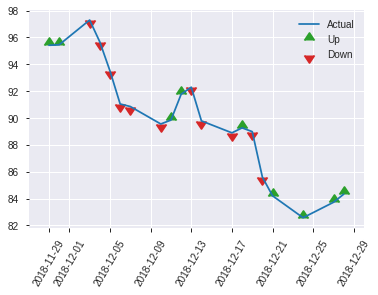


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21217648292371072
RMSE: 0.4606261856687163
LogLoss: 0.6138856036462298
Null degrees of freedom: 250
Residual degrees of freedom: 120
Null deviance: 347.0656557889856
Residual deviance: 308.1705730304074
AIC: 570.1705730304075
AUC: 0.7269020007646234
pr_auc: 0.7210736420172261
Gini: 0.4538040015292468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3310356431551264: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   67   0.5678   (67.0/118.0)
1      15   118  0.1128   (15.0/133.0)
Total  66   185  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331036     0.742138  184
max f2                       0.118468     0.859173  241
max f0point5                 0.486398     0.702541  133
max accuracy                 0.486398     0.685259  133
max precision                0.901969     1         0
max recall                   0.118468     1         241
max specificity              0.901969     1         0
max absolute_mcc             0.486398     0.367971  133
max min_per_class_accuracy   0.507997     0.669492  128
max mean_per_class_accuracy  0.486398     0.683892  133

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.887874           1.88722   1.88722            1                0.895747  1                           0.895747            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.864848           1.25815   1.57268            0.666667         0.872717  0.833333                    0.884232            0.0150376       0.037594                   25.8145   57.2682
    3        0.0318725                   0.817447           0.943609  1.41541            0.5              0.821812  0.75                        0.868627            0.0075188       0.0451128                  -5.6391   41.5414
    4        0.0438247                   0.813955           1.25815   1.37252            0.666667         0.815139  0.727273                    0.854039            0.0150376       0.0601504                  25.8145   37.2522
    5        0.0517928                   0.811125           1.88722   1.45171            1                0.811778  0.769231                    0.847537            0.0150376       0.075188                   88.7218   45.1706
    6        0.103586                    0.758436           1.59688   1.52429            0.846154         0.777221  0.807692                    0.812379            0.0827068       0.157895                   59.6877   52.4291
    7        0.151394                    0.719441           1.25815   1.44025            0.666667         0.737607  0.763158                    0.788767            0.0601504       0.218045                   25.8145   44.0245
    8        0.203187                    0.690345           1.59688   1.48017            0.846154         0.706309  0.784314                    0.767748            0.0827068       0.300752                   59.6877   48.0171
    9        0.302789                    0.633189           1.3588    1.44025            0.72             0.660818  0.763158                    0.732574            0.135338        0.43609                    35.8797   44.0245
    10       0.40239                     0.575503           1.13233   1.36403            0.6              0.598744  0.722772                    0.699448            0.112782        0.548872                   13.2331   36.4029
    11       0.501992                    0.510597           1.13233   1.31806            0.6              0.542557  0.698413                    0.668318            0.112782        0.661654                   13.2331   31.8057
    12       0.601594                    0.435502           0.981353  1.26231            0.52             0.475269  0.668874                    0.636357            0.0977444       0.759398                   -1.86466  26.2311
    13       0.701195                    0.349012           0.754887  1.19023            0.4              0.387238  0.630682                    0.60097             0.075188        0.834586                   -24.5113  19.0234
    14       0.800797                    0.282722           0.830376  1.14548            0.44             0.316576  0.606965                    0.565598            0.0827068       0.917293                   -16.9624  14.5476
    15       0.900398                    0.181669           0.301955  1.05217            0.16             0.230103  0.557522                    0.528486            0.0300752       0.947368                   -69.8045  5.21658
    16       1                           0.0488251          0.528421  1                  0.28             0.127321  0.52988                     0.488529         

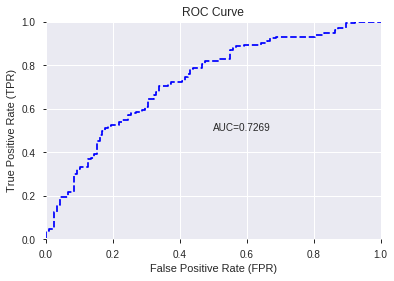

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


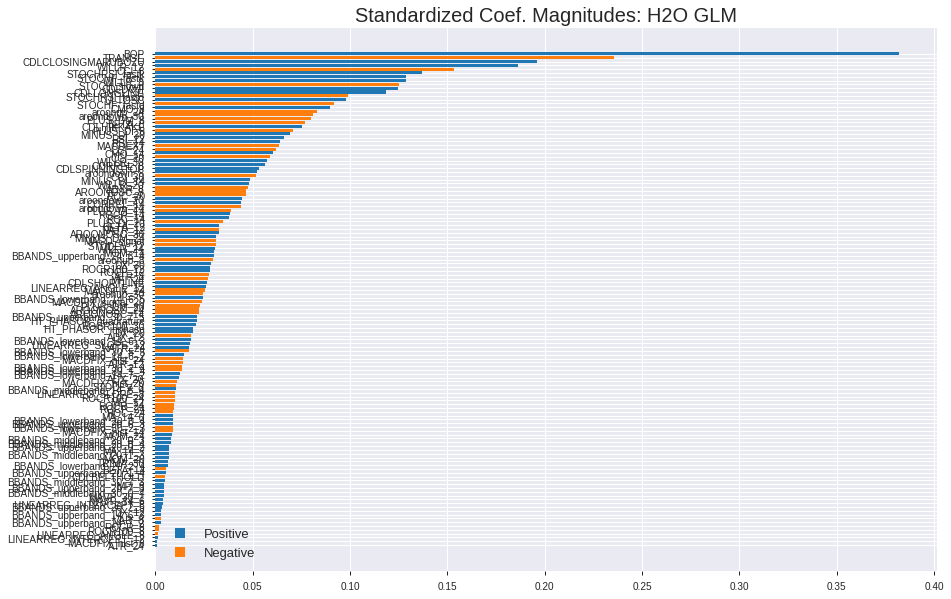

'log_likelihood'
--2019-08-27 14:29:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142929_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142929_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'CCI_8',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCH_slowd',
 'CDLDOJI',
 'CDLLONGLINE',
 'STOCHRSI_fastd',
 'ULTOSC',
 'STOCHF_fastd',
 'CMO_8',
 'aroonup_24',
 'aroondown_30',
 'PLUS_DM_8',
 'BETA_8',
 'CDLHIKKAKE',
 'PLUS_DI_8',
 'MINUS_DI_30',
 'RSI_12',
 'RSI_14',
 'MACDEXT',
 'CCI_24',
 'CMO_14',
 'CCI_20',
 'WILLR_30',
 'CORREL_8',
 'CDLSPINNINGTOP',
 'aroondown_8',
 'CCI_30',
 'MINUS_DI_14',
 'WILLR_20',
 'ADXR_8',
 'AROONOSC_8',
 'ROC_20',
 'aroondown_20',
 'CORREL_14',
 'aroondown_24',
 'PLUS_DI_14',
 'ROCR_14',
 'ROC_14',
 'PLUS_DI_20',
 'BETA_12',
 'NATR_12',
 'AROONOSC_30',
 'MINUS_DM_24',
 'MACD_signal',
 'STDDEV_12',
 'WILLR_24',
 'MOM_14',
 'BBANDS_upperband_24_6_4',
 'aroonup_8',
 'DX_30',
 'ROCR100_12',
 'ROCP_12',
 'ATR_8',
 'MFI_24',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_12',
 'MACDFIX_24',
 'aroonup_30',
 'BBANDS_lowerband_14_6_5',
 'MACDFIX_signal_20',
 'PLUS_DM_20',
 'AROONOSC_24',
 'AROONOSC_14',
 

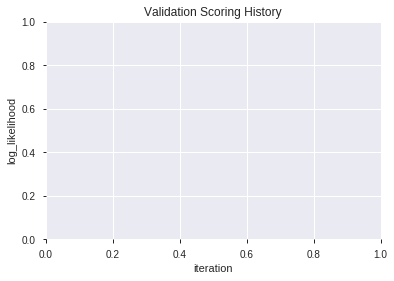

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_142945_model_3  0.719383  0.640369              0.380336  0.472325  0.223091
1               XGBoost_1_AutoML_20190827_142945  0.714031  0.652491              0.348764  0.478655  0.229111
2  XGBoost_grid_1_AutoML_20190827_142945_model_2  0.712438  0.647978              0.338378  0.477109  0.227633
3  XGBoost_grid_1_AutoML_20190827_142945_model_6  0.710717  0.659719              0.347330  0.482400  0.232710
4  XGBoost_grid_1_AutoML_20190827_142945_model_5  0.708296  0.663810              0.356283  0.484356  0.234601
5  XGBoost_grid_1_AutoML_20190827_142945_model_7  0.706831  0.653691              0.368102  0.479244  0.229675
6  XGBoost_grid_1_AutoML_20190827_142945_model_1  0.706193  0.650879              0.330381  0.475756  0.226344
7               XGBoost_2_AutoML_20190827_142945  0.706130  0.643710              0.360042  0.474278  0.224939
8  XGBoost_grid_1_AutoML_20190827_142945_model_4  0.700459  0.636903              0.378425  0.471409  0.222227
9               XGBoost_3_AutoML_20190827_142945  0.694533  0.660130              0.380814  0.481649  0.231986

variable  relative_importance  scaled_importance  percentage
0                         BOP          1646.369019           1.000000    0.201236
1              STOCHRSI_fastk           298.387085           0.181239    0.036472
2                      TRANGE           268.152618           0.162875    0.032776
3                STOCHF_fastk           242.270752           0.147155    0.029613
4        HT_PHASOR_quadrature           189.885544           0.115336    0.023210
..                        ...                  ...                ...         ...
118   BBANDS_lowerband_20_2_4             6.615431           0.004018    0.000809
119                 ROCR100_8             6.366986           0.003867    0.000778
120   BBANDS_upperband_20_6_3             6.331104           0.003845    0.000774
121            CDLSPINNINGTOP             5.588099           0.003394    0.000683
122  BBANDS_middleband_30_0_4             4.969154           0.003018    0.000607

[123 rows x 4 columns]

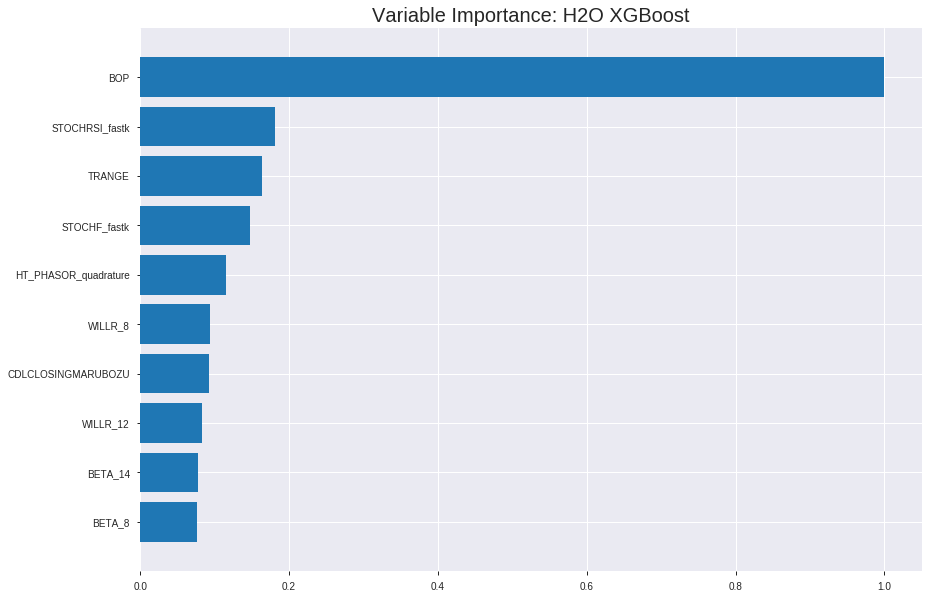

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_142945_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13448164641408222
RMSE: 0.3667173931163918
LogLoss: 0.4361419613026094
Mean Per-Class Error: 0.15998260647007978
AUC: 0.9266468356050258
pr_auc: 0.9371632921144477
Gini: 0.8532936712100516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5012504309415817: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      640  187   0.2261   (187.0/827.0)
1      97   829   0.1048   (97.0/926.0)
Total  737  1016  0.162    (284.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50125      0.853759  208
max f2                       0.366613     0.906538  270
max f0point5                 0.625409     0.873016  149
max accuracy                 0.550326     0.839703  185
max precision                0.929891     1         0
max recall                   0.184416     1         349
max specificity              0.929891     1         0
max absolute_mcc             0.574093     0.679008  174
max min_per_class_accuracy   0.550326     0.838013  185
max mean_per_class_accuracy  0.574093     0.840017  174

Gains/Lift Table: Avg response rate: 52.82 %, avg score: 52.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.888587           1.89309   1.89309            1                0.900169  1                           0.900169            0.0194384       0.0194384                  89.3089   89.3089
    2        0.0205362                   0.877076           1.89309   1.89309            1                0.882223  1                           0.891196            0.0194384       0.0388769                  89.3089   89.3089
    3        0.0302339                   0.866477           1.89309   1.89309            1                0.871284  1                           0.884809            0.0183585       0.0572354                  89.3089   89.3089
    4        0.040502                    0.853091           1.89309   1.89309            1                0.858832  1                           0.878223            0.0194384       0.0766739                  89.3089   89.3089
    5        0.0501997                   0.846714           1.89309   1.89309            1                0.850105  1                           0.872791            0.0183585       0.0950324                  89.3089   89.3089
    6        0.100399                    0.805094           1.89309   1.89309            1                0.82765   1                           0.850221            0.0950324       0.190065                   89.3089   89.3089
    7        0.150029                    0.775211           1.87133   1.88589            0.988506         0.788586  0.996198                    0.829832            0.0928726       0.282937                   87.1329   88.589
    8        0.200228                    0.744787           1.89309   1.8877             1                0.759848  0.997151                    0.812286            0.0950324       0.37797                    89.3089   88.7695
    9        0.300057                    0.694705           1.75246   1.8427             0.925714         0.718509  0.973384                    0.781087            0.174946        0.552916                   75.2459   84.2702
    10       0.399886                    0.64003            1.49284   1.75536            0.788571         0.668177  0.927247                    0.752899            0.149028        0.701944                   49.2836   75.536
    11       0.500285                    0.565687           1.16167   1.63622            0.613636         0.604668  0.86431                     0.723152            0.116631        0.818575                   16.1668   63.6216
    12       0.600114                    0.486001           0.865412  1.50799            0.457143         0.525044  0.796578                    0.690196            0.0863931       0.904968                   -13.4588  50.7993
    13       0.699943                    0.389079           0.562518  1.37314            0.297143         0.437268  0.725346                    0.654123            0.0561555       0.961123                   -43.7482  37.3145
    14       0.799772                    0.28473            0.281259  1.23685            0.148571         0.33978   0.653352                    0.614886            0.0280778       0.989201                   -71.8741  23.6854
    15       0.899601                    0.184098           0.108176  1.1116             0.0571429        0.233522  0.587191                    0.572566            0.0107991       1                          -89.1824  11.1604
    16       1                           0.0605825          0         1                  0                0.138549  0.528237                    0.528991           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21320182020435519
RMSE: 0.46173782626546334
LogLoss: 0.6148744257500792
Mean Per-Class Error: 0.31885643991436874
AUC: 0.7211473943189443
pr_auc: 0.7295927527504072
Gini: 0.4422947886378885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3820565193891525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   152  0.6387   (152.0/238.0)
1      30   233  0.1141   (30.0/263.0)
Total  116  385  0.3633   (182.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382057     0.719136  293
max f2                       0.24341      0.857048  359
max f0point5                 0.524975     0.696203  204
max accuracy                 0.524975     0.682635  204
max precision                0.879796     1         0
max recall                   0.12874      1         396
max specificity              0.879796     1         0
max absolute_mcc             0.524975     0.362937  204
max min_per_class_accuracy   0.540984     0.659664  193
max mean_per_class_accuracy  0.524975     0.681144  204

Gains/Lift Table: Avg response rate: 52.50 %, avg score: 52.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.817937           1.90494   1.90494            1                0.836496  1                           0.836496            0.0228137       0.0228137                  90.4943    90.4943
    2        0.0219561                   0.805464           1.90494   1.90494            1                0.810609  1                           0.824729            0.0190114       0.0418251                  90.4943    90.4943
    3        0.0319361                   0.796403           1.52395   1.78588            0.8              0.798155  0.9375                      0.816425            0.0152091       0.0570342                  52.3954    78.5884
    4        0.0419162                   0.774583           1.52395   1.72352            0.8              0.783829  0.904762                    0.808664            0.0152091       0.0722433                  52.3954    72.352
    5        0.0518962                   0.763728           1.90494   1.75841            1                0.766682  0.923077                    0.800591            0.0190114       0.0912548                  90.4943    75.8409
    6        0.101796                    0.738145           1.21916   1.49407            0.64             0.750293  0.784314                    0.775935            0.0608365       0.152091                   21.9163    49.4073
    7        0.151697                    0.706992           1.60015   1.52897            0.84             0.719829  0.802632                    0.757479            0.0798479       0.231939                   60.0152    52.8967
    8        0.201597                    0.686697           1.44776   1.50887            0.76             0.697947  0.792079                    0.742743            0.0722433       0.304183                   44.7757    50.8866
    9        0.301397                    0.640806           1.33346   1.45078            0.7              0.665246  0.761589                    0.717082            0.13308         0.437262                   33.346     45.0784
    10       0.401198                    0.597643           1.02867   1.34578            0.54             0.62102   0.706468                    0.693186            0.102662        0.539924                   2.86692    34.5781
    11       0.500998                    0.54564            1.14297   1.30538            0.6              0.570272  0.685259                    0.668701            0.114068        0.653992                   14.2966    30.5379
    12       0.600798                    0.49561            0.99057   1.25309            0.52             0.518087  0.657807                    0.643682            0.0988593       0.752852                   -0.942966  25.3085
    13       0.700599                    0.436176           0.723878  1.1777             0.38             0.467527  0.618234                    0.618589            0.0722433       0.825095                   -27.6122   17.77
    14       0.800399                    0.360621           0.761977  1.12586            0.4              0.395434  0.591022                    0.590764            0.0760456       0.901141                   -23.8023   12.5864
    15       0.9002                      0.255123           0.685779  1.07707            0.36             0.311202  0.56541                     0.559771            0.0684411       0.969582                   -31.4221   7.70742
    16       1                           0.106825           0.304791  1                  0.16             0.199887  0.52495                     0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:29:54  2.582 sec   0                  0.5              0.693147            0.5             0                  1                0.471763                         0.5                0.693147              0.5               0                    1                  0.47505
    2019-08-27 14:29:55  2.807 sec   5                  0.475199         0.644484            0.821674        0.823978           1.89309          0.262407                         0.492591           0.678384              0.639318          0.624258             0.952471           0.40519
    2019-08-27 14:29:55  2.928 sec   10                 0.454131         0.603957            0.842823        0.853893           1.89309          0.250998                         0.482657           0.658694              0.680792          0.653795             1.26996            0.349301
    2019-08-27 14:29:55  3.065 sec   15                 0.439048         0.57486             0.853183        0.866435           1.89309          0.249287                         0.478428           0.650088              0.686184          0.68921              1.90494            0.417166
    2019-08-27 14:29:55  3.170 sec   20                 0.428079         0.553417            0.860849        0.87297            1.89309          0.245294                         0.474462           0.642021              0.697551          0.711346             1.90494            0.41517
    2019-08-27 14:29:55  3.274 sec   25                 0.418937         0.535521            0.868511        0.880605           1.89309          0.231033                         0.471559           0.636046              0.70343           0.709012             1.90494            0.365269
    2019-08-27 14:29:55  3.378 sec   30                 0.410565         0.519053            0.876946        0.88939            1.89309          0.233314                         0.468752           0.630192              0.709301          0.715349             1.58745            0.365269
    2019-08-27 14:29:55  3.488 sec   35                 0.403526         0.505244            0.88384         0.896469           1.89309          0.204221                         0.467586           0.62762               0.707959          0.710734             1.58745            0.351297
    2019-08-27 14:29:55  3.603 sec   40                 0.396698         0.492089            0.892568        0.905446           1.89309          0.194524                         0.466544           0.62543               0.709908          0.71397              1.58745            0.355289
    2019-08-27 14:29:56  3.723 sec   45                 0.390104         0.479584            0.900383        0.912311           1.89309          0.195665                         0.466894           0.6259                0.70609           0.711339             1.90494            0.355289
    2019-08-27 14:29:56  3.954 sec   50                 0.385834         0.471126            0.904477        0.915807           1.89309          0.191101                         0.465181           0.622326              0.711003          0.716883             1.90494            0.349301
    2019-08-27 14:29:56  4.074 sec   55                 0.379873         0.460032            0.911414        0.922428           1.89309          0.183685                         0.463412           0.618545              0.717441          0.72

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       1646.3690185546875     1.0                    0.20123597029469886
STOCHRSI_fastk            298.3870849609375      0.1812394922390396     0.03647190507644168
TRANGE                    268.1526184082031      0.16287516066331753    0.03277634099298767
STOCHF_fastk              242.270751953125       0.14715458637930964    0.029612795973355453
HT_PHASOR_quadrature      189.8855438232422      0.11533595547730768    0.0232097429103422
---                       ---                    ---                    ---
BBANDS_lowerband_20_2_4   6.615431308746338      0.004018194726813971   0.0008086053146834519
ROCR100_8                 6.366986274719238      0.0038672898985360406  0.0007782378351427877
BBANDS_upperband_20_6_3   6.331103801727295      0.003845494983430408   0.000773851914254015
CDLSPINNINGTOP            5.588099479675293      0.003394196207956444   0.0006830343672787026
BBANDS_middleband_30_0_4  4.969154357910156      0.0030182506484922023  0.0006073805978419325


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7283582089552237)

('auc', 0.7193832037721423)

('logloss', 0.64036854670458)

('mean_per_class_error', 0.32021791767554486)

('rmse', 0.4723254181634881)

('mse', 0.2230913006433139)

xgboost prediction progress: |████████████████████████████████████████████| 100%


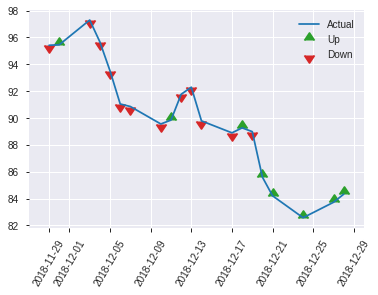


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2230913006433139
RMSE: 0.4723254181634881
LogLoss: 0.64036854670458
Mean Per-Class Error: 0.32021791767554486
AUC: 0.7193832037721423
pr_auc: 0.7404465798379233
Gini: 0.43876640754428453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2903086543083191: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   80   0.678    (80.0/118.0)
1      11   122  0.0827   (11.0/133.0)
Total  49   202  0.3625   (91.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290309     0.728358  201
max f2                       0.0922631    0.849298  250
max f0point5                 0.481206     0.707635  100
max accuracy                 0.410474     0.681275  138
max precision                0.841421     1         0
max recall                   0.0922631    1         250
max specificity              0.841421     1         0
max absolute_mcc             0.481206     0.365963  100
max min_per_class_accuracy   0.438147     0.661017  127
max mean_per_class_accuracy  0.481206     0.679782  100

Gains/Lift Table: Avg response rate: 52.99 %, avg score: 43.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.779344           1.88722   1.88722            1                0.813987  1                           0.813987            0.0225564       0.0225564                  88.7218   88.7218
    2        0.0239044                   0.735092           1.88722   1.88722            1                0.751658  1                           0.782822            0.0225564       0.0451128                  88.7218   88.7218
    3        0.0318725                   0.727202           1.88722   1.88722            1                0.729063  1                           0.769382            0.0150376       0.0601504                  88.7218   88.7218
    4        0.0438247                   0.713517           1.88722   1.88722            1                0.719118  1                           0.755674            0.0225564       0.0827068                  88.7218   88.7218
    5        0.0517928                   0.706447           0         1.59688            0                0.707258  0.846154                    0.748225            0               0.0827068                  -100      59.6877
    6        0.103586                    0.654639           1.59688   1.59688            0.846154         0.676254  0.846154                    0.712239            0.0827068       0.165414                   59.6877   59.6877
    7        0.151394                    0.618892           1.57268   1.58924            0.833333         0.63932   0.842105                    0.689212            0.075188        0.240602                   57.2682   58.9236
    8        0.203187                    0.5811             1.16136   1.48017            0.615385         0.597261  0.784314                    0.665774            0.0601504       0.300752                   16.1365   48.0171
    9        0.302789                    0.528691           1.3588    1.44025            0.72             0.552993  0.763158                    0.628675            0.135338        0.43609                    35.8797   44.0245
    10       0.40239                     0.481206           1.3588    1.42008            0.72             0.505497  0.752475                    0.598185            0.135338        0.571429                   35.8797   42.0085
    11       0.501992                    0.439308           0.830376  1.30308            0.44             0.455084  0.690476                    0.569792            0.0827068       0.654135                   -16.9624  30.3079
    12       0.601594                    0.390972           0.830376  1.22482            0.44             0.413065  0.649007                    0.543844            0.0827068       0.736842                   -16.9624  22.4817
    13       0.701195                    0.348262           0.905865  1.17951            0.48             0.368945  0.625                       0.519               0.0902256       0.827068                   -9.41353  17.9511
    14       0.800797                    0.29099            0.830376  1.13609            0.44             0.317851  0.60199                     0.493982            0.0827068       0.909774                   -16.9624  13.6086
    15       0.900398                    0.206291           0.377444  1.05217            0.2              0.256164  0.557522                    0.467674            0.037594        0.947368                   -62.2556  5.21658
    16       1                           0.0922631          0.528421  1                  0.28             0.1481    0.52988                     0.435844         

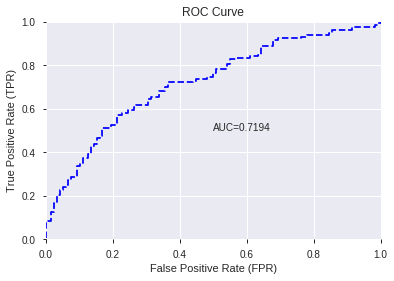

This function is available for GLM models only


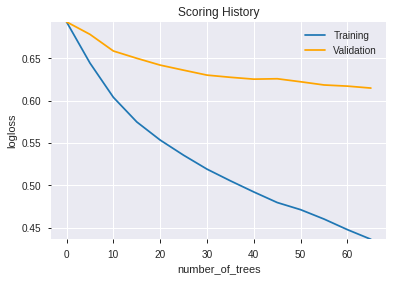

--2019-08-27 14:30:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_142945_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_142945_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b6bc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHRSI_fastk',
 'TRANGE',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'BETA_14',
 'BETA_8',
 'CCI_8',
 'STOCHF_fastd',
 'CCI_24',
 'ULTOSC',
 'BETA_12',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'ADX_12',
 'ROCR_8',
 'PLUS_DM_8',
 'CORREL_14',
 'AROONOSC_14',
 'PLUS_DM_20',
 'PLUS_DI_8',
 'CDLLONGLINE',
 'LINEARREG_ANGLE_12',
 'MOM_14',
 'STDDEV_8',
 'MFI_8',
 'ADXR_8',
 'MOM_24',
 'NATR_12',
 'ADX_20',
 'ROCR100_30',
 'MACDFIX_24',
 'DX_20',
 'STOCHRSI_fastd',
 'DX_12',
 'ATR_24',
 'CORREL_8',
 'MACDFIX_hist_8',
 'MACD_signal',
 'ROC_14',
 'MOM_20',
 'AROONOSC_8',
 'ROC_20',
 'PLUS_DI_14',
 'STDDEV_12',
 'MFI_24',
 'BBANDS_lowerband_30_5_5',
 'aroondown_30',
 'NATR_24',
 'CCI_30',
 'MFI_12',
 'LINEARREG_SLOPE_12',
 'LINEARREG_SLOPE_8',
 'CDLBELTHOLD',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_14_6_5',
 'aroonup_8',
 'WILLR_24',
 'DX_30',
 'ROC_24',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_lowerband_30_1_4',
 'PLUS_DI_20',
 'CDLDOJI',


In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.689
GLM             0.685
XGBoost         0.733
dtype: float64

DeepLearning    GLM  XGBoost
All          0.530  0.530    0.733
DLF          0.530  0.530    0.681
Fwe          0.689  0.677    0.705
RFE          0.689  0.685    0.681
XGBF         0.530  0.530    0.681





F1


DeepLearning    0.736
GLM             0.742
XGBoost         0.770
dtype: float64

DeepLearning    GLM  XGBoost
All          0.693  0.693    0.770
DLF          0.693  0.693    0.737
Fwe          0.733  0.738    0.750
RFE          0.736  0.742    0.728
XGBF         0.693  0.693    0.737





auc


DeepLearning    0.725
GLM             0.735
XGBoost         0.768
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.768
DLF          0.508  0.500    0.729
Fwe          0.725  0.735    0.753
RFE          0.724  0.727    0.719
XGBF         0.500  0.500    0.729





logloss


DeepLearning    18.301
GLM             18.301
XGBoost          0.640
dtype: float64

DeepLearning     GLM  XGBoost
All         16.237  16.237    0.624
DLF         18.301  18.301    0.612
Fwe          0.668   0.621    0.607
RFE          0.639   0.614    0.640
XGBF        16.237  18.301    0.612





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.321
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.269
DLF          0.492  0.500    0.321
Fwe          0.311  0.318    0.301
RFE          0.315  0.316    0.320
XGBF         0.500  0.500    0.321





rmse


DeepLearning    0.728
GLM             0.728
XGBoost         0.472
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.686    0.465
DLF          0.728  0.728    0.460
Fwe          0.475  0.464    0.457
RFE          0.473  0.461    0.472
XGBF         0.686  0.728    0.460





mse


DeepLearning    0.530
GLM             0.530
XGBoost         0.223
dtype: float64

DeepLearning    GLM  XGBoost
All          0.470  0.470    0.217
DLF          0.530  0.530    0.212
Fwe          0.226  0.216    0.209
RFE          0.224  0.212    0.223
XGBF         0.470  0.530    0.212

{'F1':       DeepLearning    GLM  XGBoost
 All          0.693    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.693      NaN
 DLF            NaN    NaN    0.737
 All            NaN  0.693      NaN
 All            NaN    NaN    0.770
 XGBF         0.693    NaN      NaN
 XGBF           NaN  0.693      NaN
 XGBF           NaN    NaN    0.737
 Fwe          0.733    NaN      NaN
 Fwe            NaN  0.738      NaN
 Fwe            NaN    NaN    0.750
 RFE          0.736    NaN      NaN
 RFE            NaN  0.742      NaN
 RFE            NaN    NaN    0.728,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.530    NaN      NaN
 DLF          0.530    NaN      NaN
 DLF            NaN  0.530      NaN
 DLF            NaN    NaN    0.681
 All            NaN  0.530      NaN
 All            NaN    NaN    0.733
 XGBF         0.530    NaN      NaN
 XGBF           NaN  0.530      NaN
 XGBF           NaN    NaN    0.681
 Fwe          0.689    NaN      NaN
 Fwe     